In [26]:
from zipfile import ZipFile
from ultralytics import YOLO
from p2m.mei2abc import MEIConverter
import cv2
import matplotlib.pyplot as plt
import os

In [27]:
model = YOLO("../models/yparser.pt")

In [28]:
results = model("../resources/samples/000051652-1_2_1.png")


image 1/1 /home/mathieujayet/code/matjayet/PicToMusic/notebooks/../resources/samples/000051652-1_2_1.png: 96x640 1 clef, 1 gamme, 1 metrics, 8 notes, 4 pauses, 1194.3ms
Speed: 15.5ms preprocess, 1194.3ms inference, 12.7ms postprocess per image at shape (1, 3, 96, 640)


In [29]:
for result in results:
    xywh = result.boxes.xywh  # center-x, center-y, width, height
    xywhn = result.boxes.xywhn  # normalized
    xyxy = result.boxes.xyxy  # top-left-x, top-left-y, bottom-right-x, bottom-right-y
    xyxyn = result.boxes.xyxyn  # normalized
    names = [result.names[cls.item()] for cls in result.boxes.cls.int()]  # class name of each box
    confs = result.boxes.conf  # confidence score of each box

In [ ]:
for result in results:
    # Extract bounding boxes as a NumPy array (x_min, y_min, x_max, y_max)
    boxes_tensor = result.boxes.xyxy  # (N, 4) tensor (if using YOLOv8)
    boxes_array = boxes_tensor.cpu().numpy()  # Convert to NumPy array
    
    # Sort bounding boxes by x_min (column index 0)
    sorted_indices = boxes_array[:, 0].argsort()
    result.boxes.data = result.boxes.data[sorted_indices]  # Appliquer le tri

    # Display and save sorted results
    # result.show()
    print(result.boxes.cls[0])
    result.save_txt('result.txt')
    

In [ ]:
test_mei = MEIConverter("../resources/samples/000051652-1_2_1.mei")

In [ ]:
print(test_mei.mei_to_abc())


In [ ]:
import numpy as np
un = np.unique_counts(names)
un.values


In [30]:
print(result.names)

{0: 'clef', 1: 'gamme', 2: 'metrics', 3: 'note', 4: 'pause'}


In [73]:
def check_count(count_names, mei_notes_count, mei_pause_count, mei_score_def):
    message = ''
    if count_names['clef'] != 1:
        message += 'Nombre de clefs différent de 1'
    if count_names.get('note', 0) != mei_notes_count:
        message += ' Nombre de notes incorrect'
    if count_names.get('pause', 0) != mei_pause_count:
        message += ' Nombre de pauses incorrect'
    if count_names.get('gamme', 0) != 1 and mei_score_def['key'] != '':
        message += ' Nombre de clefs incorrect'
    if count_names.get('metrics', 0) != 1 and mei_score_def['meter_count'] != '':
        message += ' Nombre de metrics incorrect'
    if message == '':
        message = 'Mapping correct'
    return message


In [38]:
def sort_boxes(boxes):
    # Créer un dictionnaire pour stocker les boîtes par classe
    boxes_array = boxes.xywhn.cpu().numpy()  # Convert to NumPy array

    class_indices = boxes.cls.cpu().numpy().reshape(-1, 1)  # Convert to column vector

    # Concatenate class indices with bounding boxes → (N, 5) array: [class, x_center, y_center, width, height]
    boxes_with_labels = np.hstack((class_indices, boxes_array))
    
    sorted_indices = boxes_with_labels[:, 1].argsort()
    sorted_boxes = boxes_with_labels[sorted_indices]  # Apply sorting

    return sorted_boxes  # Appliquer le tri

In [39]:
import yaml

def get_or_add_class_to_yaml(yaml_path, class_name):
    with open(yaml_path, 'r') as file:
        data = yaml.safe_load(file)
    
    if 'names' not in data:
        data['names'] = {}
    
    for index, name in data['names'].items():
        if name == class_name:
            return int(index)
        
    new_index = max(map(int, data['names'].keys()), default=-1) + 1
    data['names'][new_index] = class_name
    
    with open(yaml_path, 'w') as file:
        yaml.dump(data, file, default_flow_style=False, allow_unicode=True, sort_keys=False)
    
    print(f"Class '{class_name}' added to {yaml_path} as index {new_index}.")
    return new_index

In [40]:
def associate_class_labels(sorted_boxes, labels_dict, mei_labels, yaml_path='../resources/dataset/dataset.yaml'):
    # Associer les étiquettes de classe aux boîtes triées
    class_labels = []
    i_note = 0
    i_pause = 0
    
    for bbox in sorted_boxes:
        if labels_dict[bbox[0]] == 'clef':
            class_index = get_or_add_class_to_yaml(yaml_path, mei_labels['clef'])
            class_labels.append(class_index)
        elif labels_dict[bbox[0]] == 'metrics':
            class_index = get_or_add_class_to_yaml(yaml_path, mei_labels['metrics'])
            class_labels.append(class_index)
        elif labels_dict[bbox[0]] == 'gamme':
            class_index = get_or_add_class_to_yaml(yaml_path, mei_labels['gamme'])
            class_labels.append(class_index)
        elif labels_dict[bbox[0]] == 'note':
            class_index = get_or_add_class_to_yaml(yaml_path, mei_labels['note_labels'][i_note])
            class_labels.append(class_index)
            i_note += 1
        elif labels_dict[bbox[0]] == 'pause':
            class_index = get_or_add_class_to_yaml(yaml_path, mei_labels['pause_labels'][i_pause])
            class_labels.append(class_index)
            i_pause += 1
    return class_labels
    

In [ ]:
import shutil

def compare_mei_to_parser(file_name):
    mei = MEIConverter(file_name +'.mei')
    mei.mei_to_abc()
    mei_clef, mei_gamme = mei.score_def["clef"], mei.score_def["key"],
    mei_metrics = "4/4" if mei.score_def['meter_count'] == '' else str(mei.score_def['meter_count']) + '/' + str(mei.score_def['meter_unit'])

    result = model(file_name +'.png')[0]
    names = [result.names[cls.item()] for cls in result.boxes.cls.int()]
    unique_names, counts = np.unique(names, return_counts=True)

    # Convertir en dictionnaire pour un accès plus simple
    count_names = dict(zip(unique_names, counts))

    check_count_names = check_count(count_names, len(mei.notes_labels), len(mei.pause_labels), mei.score_def)

    if check_count_names != "Mapping correct":
        shutil.copyfile(file_name +'.mei', f'../resources/dataset/no_match/' + file_name.split('/')[-1] + '.mei')
        shutil.copyfile(file_name +'.png', '../resources/dataset/no_match/' + file_name.split('/')[-1] + '.png')
        result.save('../resources/dataset/no_match/' + file_name.split('/')[-1] + '_yolo.png')
        return "Mapping incorrect"
    else:
        shutil.copyfile(file_name +'.mei', '../resources/dataset/match/' + file_name.split('/')[-1] + '.mei')
        shutil.copyfile(file_name +'.png', '../resources/dataset/match/' + file_name.split('/')[-1] + '.png')

        if mei_clef != 'G2' or mei_clef != '':
            notes_labels = mei.treble_clef_transposition()
        else:
            notes_labels = mei.notes_labels

        sorted_boxes = sort_boxes(result.boxes)
            
        mei_labels = {'note_labels': notes_labels, 'pause_labels': mei.pause_labels, 'clef': mei_clef, 'gamme': mei_gamme, 'metrics' : mei_metrics}
        class_labels = associate_class_labels(sorted_boxes, result.names, mei_labels)

        with open('../resources/dataset/match/' + file_name.split('/')[-1] + '.txt', 'w') as f:
                for bbox, label in zip(sorted_boxes, class_labels):
                    f.write(f"{label} {bbox[1]} {bbox[2]} {bbox[3]} {bbox[4]}\n")  # YOLO format: class x_min y_min x_max y_max


In [ ]:
compare_mei_to_parser("../resources/dataset/match/150203441-1_1_1")

In [ ]:
result = model('../resources/samples/000051652-1_2_1.png')

In [ ]:
import shutil
import os
from zipfile import ZipFile
import random
from PIL import Image
import io
import numpy as np
from tqdm import tqdm

def compare_mei_to_parser(zip_path, file_name, myzip, batch_name):
    # Open the corresponding .mei and .png files directly from the ZIP
    with myzip.open('labels/' + file_name + '.mei') as mei_file, myzip.open('images/' + file_name + '.png') as img_file:
        mei_content = mei_file.read().decode('utf-8')  # Decode the byte data to a string
        # Pass the MEI content to the MEIConverter
        mei = MEIConverter(content=mei_content)
        mei.mei_to_abc()
        mei_clef, mei_gamme = mei.score_def["clef"], mei.score_def["key"]
        mei_metrics = "4/4" if mei.score_def['meter_count'] == '' else str(mei.score_def['meter_count']) + '/' + str(mei.score_def['meter_unit'])

        # Read image file content into memory
        img_bytes = img_file.read()
        img = Image.open(io.BytesIO(img_bytes))  # Load image using PIL from byte data

        # Now you can pass the img to your model (assuming it expects a PIL image)
        result = model(img)[0]

        names = [result.names[cls.item()] for cls in result.boxes.cls.int()]
        unique_names, counts = np.unique(names, return_counts=True)

        # Convertir en dictionnaire pour un accès plus simple
        count_names = dict(zip(unique_names, counts))

        check_count_names = check_count(count_names, len(mei.notes_labels), len(mei.pause_labels), mei.score_def)

        if check_count_names != "Mapping correct":
            # Copy files to 'no_match' if mapping is incorrect
            os.makedirs(f'../resources/dataset/{batch_name}/no_match/labels', exist_ok=True)
            os.makedirs(f'../resources/dataset/{batch_name}/no_match/images', exist_ok=True)
            with myzip.open('labels/' + file_name + '.mei') as mei_file, myzip.open('images/' + file_name + '.png') as img_file:
                shutil.copyfileobj(mei_file, open(f'../resources/dataset/{batch_name}/no_match/labels/' + file_name.split('/')[-1] + '.mei', 'wb'))
                shutil.copyfileobj(img_file, open(f'../resources/dataset/{batch_name}/no_match/images/' + file_name.split('/')[-1] + '.png', 'wb'))
            result.save(f'../resources/dataset/{batch_name}/no_match/' + file_name.split('/')[-1] + '_yolo.png')
            return "Mapping incorrect"
        else:
            # Copy files to 'match' if mapping is correct
            with myzip.open('labels/' + file_name + '.mei') as mei_file, myzip.open('images/' + file_name + '.png') as img_file:
                os.makedirs(f'../resources/dataset/{batch_name}/match/labels', exist_ok=True)
                os.makedirs(f'../resources/dataset/{batch_name}/match/yolo_input', exist_ok=True)
                shutil.copyfileobj(mei_file, open(f'../resources/dataset/{batch_name}/match/labels/' + file_name.split('/')[-1] + '.mei', 'wb'))
                shutil.copyfileobj(img_file, open(f'../resources/dataset/{batch_name}/match/yolo_input/' + file_name.split('/')[-1] + '.png', 'wb'))

            if mei_clef != 'G2' or mei_clef != '':
                notes_labels = mei.treble_clef_transposition()
            else:
                notes_labels = mei.notes_labels
                
            sorted_boxes = sort_boxes(result.boxes)
            mei_labels = {'note_labels': notes_labels, 'pause_labels': mei.pause_labels, 'clef': mei_clef, 'gamme': mei_gamme, 'metrics': mei_metrics}
            class_labels = associate_class_labels(sorted_boxes, result.names, mei_labels)

            # Save the result as text in 'match' folder
            with open(f'../resources/dataset/{batch_name}/match/yolo_input/' + file_name.split('/')[-1] + '.txt', 'w') as f:
                for bbox, label in zip(sorted_boxes, class_labels):
                    f.write(f"{label} {bbox[1]} {bbox[2]} {bbox[3]} {bbox[4]}\n")  # YOLO format: class x_min y_min x_max y_max


# Path to the zip file
zip_path = "../resources/dataset/dataset.zip"

start = 0
batch = 0
# while i < 10:
while True:
    with ZipFile(zip_path, "r") as myzip:
        zip_files = myzip.namelist()

        # Filter image and mei files
        image_files = [file for file in zip_files if file.endswith('.png') and 'images/' in file]
        mei_files = {os.path.basename(file).replace('.mei', ''): file for file in zip_files if file.endswith('.mei') and 'labels/' in file}

        for i, image_file in enumerate(tqdm(image_files[start:], desc="Processing Images"), start=start):
            if (i+1) % 20000 == 0:
                batch += 1
            # print(f"Image selected: {image_file}")

            image_name = os.path.basename(image_file).replace('.png', '')
            corresponding_mei_file = mei_files.get(image_name)

            if corresponding_mei_file:
                # print(f"Found corresponding MEI label file: {corresponding_mei_file}")
                compare_mei_to_parser(zip_path, image_name, myzip, f'batch_{batch}')
            else:
                print(f"No corresponding MEI file found for {image_file}")

        i+=1


Processing Images:   0%|          | 0/87316 [00:00<?, ?it/s]

Image selected: images/000111449-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 11 notes, 4 pauses, 374.8ms
Speed: 1.5ms preprocess, 374.8ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 1/87316 [00:01<27:47:06,  1.15s/it]

Image selected: images/212001911-1_4_1.png

0: 288x640 4 clefs, 912.2ms
Speed: 1.7ms preprocess, 912.2ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


Processing Images:   0%|          | 2/87316 [00:02<24:44:02,  1.02s/it]

Image selected: images/201001891-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 22 notes, 1 pause, 282.0ms
Speed: 1.5ms preprocess, 282.0ms inference, 4.5ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 3/87316 [00:03<32:27:47,  1.34s/it]

Image selected: images/201009082-1_1_1.png

0: 64x640 1 clef, 2 metricss, 23 notes, 3 pauses, 728.2ms
Speed: 2.3ms preprocess, 728.2ms inference, 3.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 4/87316 [00:04<27:07:21,  1.12s/it]

Image selected: images/100028978-1_2_1.png

0: 128x640 1 clef, 1 metrics, 10 notes, 3 pauses, 408.2ms
Speed: 2.5ms preprocess, 408.2ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 5/87316 [00:05<25:58:03,  1.07s/it]

Image selected: images/000115617-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 9 notes, 653.1ms
Speed: 0.9ms preprocess, 653.1ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 6/87316 [00:06<27:40:07,  1.14s/it]

Image selected: images/000108799-1_1_1.png

0: 160x640 2 clefs, 3 gammes, 1 metrics, 28 notes, 3 pauses, 658.9ms
Speed: 1.2ms preprocess, 658.9ms inference, 1.0ms postprocess per image at shape (1, 3, 160, 640)


Processing Images:   0%|          | 7/87316 [00:07<24:05:24,  1.01it/s]

Image selected: images/000127309-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 21 notes, 385.8ms
Speed: 2.6ms preprocess, 385.8ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 8/87316 [00:07<19:38:13,  1.24it/s]

Image selected: images/000113161-1_1_1.png

0: 96x640 1 clef, 1 metrics, 21 notes, 465.7ms
Speed: 1.3ms preprocess, 465.7ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 9/87316 [00:10<32:22:21,  1.33s/it]

Image selected: images/230001225-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 25 notes, 1 pause, 1250.8ms
Speed: 0.9ms preprocess, 1250.8ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 10/87316 [00:13<42:17:13,  1.74s/it]

Image selected: images/220010149-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 14 notes, 781.0ms
Speed: 1.0ms preprocess, 781.0ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 11/87316 [00:13<35:32:02,  1.47s/it]

Image selected: images/000138068-1_2_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 11 notes, 1 pause, 1099.8ms
Speed: 16.5ms preprocess, 1099.8ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 12/87316 [00:16<45:23:26,  1.87s/it]

Image selected: images/000126034-1_1_2.png

0: 64x640 1 clef, 1 gamme, 2 metricss, 17 notes, 1 pause, 988.6ms
Speed: 1.2ms preprocess, 988.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 640)
Class 'z34' added to ../resources/dataset/dataset.yaml as index 251.


Processing Images:   0%|          | 13/87316 [00:20<56:39:34,  2.34s/it]

Image selected: images/000114659-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 15 notes, 6 pauses, 611.0ms
Speed: 1.6ms preprocess, 611.0ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 14/87316 [00:22<55:33:22,  2.29s/it]

Image selected: images/000114591-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 14 notes, 2 pauses, 661.9ms
Speed: 3.3ms preprocess, 661.9ms inference, 3.8ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 15/87316 [00:23<49:55:17,  2.06s/it]

Image selected: images/230004991-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 1 pause, 338.9ms
Speed: 0.9ms preprocess, 338.9ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 16/87316 [00:24<41:15:39,  1.70s/it]

Image selected: images/211005456-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 14 notes, 2 pauses, 386.0ms
Speed: 1.2ms preprocess, 386.0ms inference, 4.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 17/87316 [00:27<45:46:30,  1.89s/it]

Image selected: images/210022097-1_3_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 16 notes, 1 pause, 775.4ms
Speed: 1.6ms preprocess, 775.4ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 18/87316 [00:27<37:57:43,  1.57s/it]

Image selected: images/100017119-1_3_1.png

0: 64x640 1 clef, 1 metrics, 14 notes, 4 pauses, 411.7ms
Speed: 1.0ms preprocess, 411.7ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)
Class '^g8' added to ../resources/dataset/dataset.yaml as index 252.
Class '^c2' added to ../resources/dataset/dataset.yaml as index 253.
Class '^c4' added to ../resources/dataset/dataset.yaml as index 254.


Processing Images:   0%|          | 19/87316 [00:29<36:14:41,  1.49s/it]

Image selected: images/000124448-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 20 notes, 369.8ms
Speed: 1.0ms preprocess, 369.8ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 20/87316 [00:30<33:57:44,  1.40s/it]

Image selected: images/201004694-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 18 notes, 6 pauses, 345.8ms
Speed: 4.1ms preprocess, 345.8ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 21/87316 [00:31<34:27:09,  1.42s/it]

Image selected: images/150202356-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 19 notes, 4 pauses, 375.2ms
Speed: 0.8ms preprocess, 375.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 22/87316 [00:34<44:54:03,  1.85s/it]

Image selected: images/000140146-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 29 notes, 1 pause, 1152.5ms
Speed: 1.5ms preprocess, 1152.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 23/87316 [00:37<52:01:45,  2.15s/it]

Image selected: images/220012149-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 14 notes, 4 pauses, 450.1ms
Speed: 0.8ms preprocess, 450.1ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 24/87316 [00:38<45:06:04,  1.86s/it]

Image selected: images/220034343-1_8_1.png

0: 64x640 1 clef, 1 metrics, 20 notes, 5 pauses, 322.1ms
Speed: 0.7ms preprocess, 322.1ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 25/87316 [00:40<40:59:01,  1.69s/it]

Image selected: images/000135110-1_3_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 25 notes, 1 pause, 407.8ms
Speed: 1.1ms preprocess, 407.8ms inference, 2.6ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 26/87316 [00:40<32:11:20,  1.33s/it]

Image selected: images/000107992-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 20 notes, 508.0ms
Speed: 1.3ms preprocess, 508.0ms inference, 1.3ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 27/87316 [00:41<32:13:44,  1.33s/it]

Image selected: images/220014914-1_3_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 25 notes, 1368.1ms
Speed: 0.9ms preprocess, 1368.1ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 28/87316 [00:43<33:14:12,  1.37s/it]

Image selected: images/220017343-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 16 notes, 4 pauses, 502.0ms
Speed: 1.7ms preprocess, 502.0ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 29/87316 [00:44<33:44:31,  1.39s/it]

Image selected: images/212001074-1_2_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 10 notes, 1 pause, 326.4ms
Speed: 1.2ms preprocess, 326.4ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)
Class '^a8' added to ../resources/dataset/dataset.yaml as index 255.


Processing Images:   0%|          | 30/87316 [00:45<30:02:58,  1.24s/it]

Image selected: images/100015432-1_4_1.png

0: 64x640 1 clef, 1 metrics, 9 notes, 2 pauses, 333.8ms
Speed: 1.2ms preprocess, 333.8ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 31/87316 [00:46<26:58:39,  1.11s/it]

Image selected: images/100015942-1_5_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 7 notes, 4 pauses, 1500.5ms
Speed: 5.5ms preprocess, 1500.5ms inference, 9.6ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 32/87316 [00:47<30:09:25,  1.24s/it]

Image selected: images/201004878-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 10 notes, 1 pause, 376.6ms
Speed: 6.3ms preprocess, 376.6ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 33/87316 [00:48<24:10:08,  1.00it/s]

Image selected: images/000116404-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 21 notes, 1 pause, 671.3ms
Speed: 2.8ms preprocess, 671.3ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 34/87316 [00:52<46:33:36,  1.92s/it]

Image selected: images/200044757-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 11 notes, 4 pauses, 1646.2ms
Speed: 2.1ms preprocess, 1646.2ms inference, 32.7ms postprocess per image at shape (1, 3, 96, 640)
Class 'z29' added to ../resources/dataset/dataset.yaml as index 256.
Class '=c6' added to ../resources/dataset/dataset.yaml as index 257.
Class '_c1' added to ../resources/dataset/dataset.yaml as index 258.


Processing Images:   0%|          | 35/87316 [00:55<54:26:51,  2.25s/it]

Image selected: images/230003350-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 15 notes, 4 pauses, 423.9ms
Speed: 2.0ms preprocess, 423.9ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 36/87316 [00:57<54:06:11,  2.23s/it]

Image selected: images/211007096-1_3_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 9 notes, 2 pauses, 555.1ms
Speed: 0.9ms preprocess, 555.1ms inference, 9.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 37/87316 [00:59<47:35:44,  1.96s/it]

Image selected: images/100500976-1_4_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 20 notes, 4 pauses, 294.4ms
Speed: 7.9ms preprocess, 294.4ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 38/87316 [01:00<44:51:38,  1.85s/it]

Image selected: images/180000107-1_10_1.png

0: 96x640 1 clef, 2 gammes, 1 metrics, 19 notes, 380.4ms
Speed: 1.5ms preprocess, 380.4ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 39/87316 [01:01<34:22:43,  1.42s/it]

Image selected: images/220017191-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 13 notes, 2 pauses, 390.6ms
Speed: 1.2ms preprocess, 390.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 40/87316 [01:02<34:04:45,  1.41s/it]

Image selected: images/230000080-1_11_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 3 pauses, 588.4ms
Speed: 13.5ms preprocess, 588.4ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 41/87316 [01:03<33:33:13,  1.38s/it]

Image selected: images/000117619-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 18 notes, 2 pauses, 655.1ms
Speed: 1.1ms preprocess, 655.1ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 42/87316 [01:04<28:27:56,  1.17s/it]

Image selected: images/000125816-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 24 notes, 4 pauses, 381.1ms
Speed: 12.5ms preprocess, 381.1ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 43/87316 [01:06<31:40:13,  1.31s/it]

Image selected: images/100501264-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 18 notes, 9 pauses, 364.6ms
Speed: 0.9ms preprocess, 364.6ms inference, 5.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 44/87316 [01:06<25:10:11,  1.04s/it]

Image selected: images/000114550-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 12 notes, 425.8ms
Speed: 1.8ms preprocess, 425.8ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 45/87316 [01:07<28:55:50,  1.19s/it]

Class '^f6' added to ../resources/dataset/dataset.yaml as index 259.
Image selected: images/000141768-1_1_1.png

0: 64x640 1 clef, 1 metrics, 21 notes, 6 pauses, 366.1ms
Speed: 0.7ms preprocess, 366.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 46/87316 [01:09<33:47:08,  1.39s/it]

Image selected: images/210097226-1_3_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 16 notes, 1 pause, 716.5ms
Speed: 0.9ms preprocess, 716.5ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 47/87316 [01:10<29:04:58,  1.20s/it]

Image selected: images/000121572-1_1_1.png

0: 96x640 1 clef, 1 metrics, 15 notes, 467.5ms
Speed: 9.8ms preprocess, 467.5ms inference, 1.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 48/87316 [01:11<30:10:41,  1.24s/it]

Image selected: images/201009201-1_2_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 16 notes, 1 pause, 455.9ms
Speed: 7.9ms preprocess, 455.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 640)
Class '_g4' added to ../resources/dataset/dataset.yaml as index 260.


Processing Images:   0%|          | 49/87316 [01:13<31:15:08,  1.29s/it]

Image selected: images/212001070-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 14 notes, 4 pauses, 545.7ms
Speed: 2.9ms preprocess, 545.7ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 50/87316 [01:15<36:20:14,  1.50s/it]

Class '^f,3' added to ../resources/dataset/dataset.yaml as index 261.
Class '=e,1' added to ../resources/dataset/dataset.yaml as index 262.
Image selected: images/000124988-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 19 notes, 2 pauses, 376.4ms
Speed: 0.8ms preprocess, 376.4ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 51/87316 [01:16<35:05:45,  1.45s/it]

Image selected: images/110003277-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 18 notes, 287.5ms
Speed: 0.8ms preprocess, 287.5ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 52/87316 [01:17<33:49:31,  1.40s/it]

Image selected: images/230005928-1_1_1.png

0: 96x640 1 clef, 1 metrics, 10 notes, 1 pause, 415.1ms
Speed: 0.9ms preprocess, 415.1ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 53/87316 [01:18<30:43:23,  1.27s/it]

Image selected: images/190012778-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 15 notes, 363.7ms
Speed: 0.8ms preprocess, 363.7ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)
Class 'f,12' added to ../resources/dataset/dataset.yaml as index 263.


Processing Images:   0%|          | 54/87316 [01:20<29:32:14,  1.22s/it]

Image selected: images/000101088-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 16 notes, 3 pauses, 601.9ms
Speed: 0.9ms preprocess, 601.9ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 55/87316 [01:22<35:19:10,  1.46s/it]

Image selected: images/000123589-8_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 42 notes, 6 pauses, 368.8ms
Speed: 2.6ms preprocess, 368.8ms inference, 11.9ms postprocess per image at shape (1, 3, 64, 640)
Class 'z/' added to ../resources/dataset/dataset.yaml as index 264.
Class '^f/' added to ../resources/dataset/dataset.yaml as index 265.
Class '^f,/' added to ../resources/dataset/dataset.yaml as index 266.


Processing Images:   0%|          | 56/87316 [01:27<61:40:29,  2.54s/it]

Image selected: images/000101266-1_1_1.png

0: 96x640 1 clef, 1 metrics, 16 notes, 1 pause, 623.0ms
Speed: 1.0ms preprocess, 623.0ms inference, 2.5ms postprocess per image at shape (1, 3, 96, 640)
Class 'd'8' added to ../resources/dataset/dataset.yaml as index 267.


Processing Images:   0%|          | 57/87316 [01:28<54:29:22,  2.25s/it]

Image selected: images/000102957-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 9 notes, 552.3ms
Speed: 2.3ms preprocess, 552.3ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 58/87316 [01:29<46:17:50,  1.91s/it]

Image selected: images/220030259-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 8 notes, 437.1ms
Speed: 1.2ms preprocess, 437.1ms inference, 0.8ms postprocess per image at shape (1, 3, 96, 640)
Class 'F3' added to ../resources/dataset/dataset.yaml as index 268.


Processing Images:   0%|          | 59/87316 [01:30<40:06:41,  1.65s/it]

Image selected: images/000123707-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 18 notes, 4 pauses, 626.1ms
Speed: 6.1ms preprocess, 626.1ms inference, 2.3ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 60/87316 [01:32<43:46:32,  1.81s/it]

Image selected: images/211003898-1_1_2.png

0: 64x640 1 clef, 2 gammes, 4 metricss, 6 notes, 2 pauses, 871.7ms
Speed: 0.7ms preprocess, 871.7ms inference, 4.5ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 61/87316 [01:33<37:08:13,  1.53s/it]

Image selected: images/000120273-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 19 notes, 638.3ms
Speed: 5.6ms preprocess, 638.3ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 62/87316 [01:35<37:00:13,  1.53s/it]

Image selected: images/212001249-1_4_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 394.6ms
Speed: 1.3ms preprocess, 394.6ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 63/87316 [01:35<29:00:36,  1.20s/it]

Image selected: images/000121168-1_2_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 16 notes, 4 pauses, 942.9ms
Speed: 1.5ms preprocess, 942.9ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)
Class 'z20' added to ../resources/dataset/dataset.yaml as index 269.


Processing Images:   0%|          | 64/87316 [01:37<34:43:33,  1.43s/it]

Image selected: images/000123237-1_1_1.png

0: 96x640 1 clef, 1 metrics, 25 notes, 1 pause, 412.8ms
Speed: 0.9ms preprocess, 412.8ms inference, 1.6ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 65/87316 [01:38<27:29:23,  1.13s/it]

Image selected: images/201007163-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 35 notes, 532.4ms
Speed: 3.6ms preprocess, 532.4ms inference, 1.6ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 66/87316 [01:38<23:37:36,  1.03it/s]

Image selected: images/000124283-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 12 notes, 8 pauses, 377.7ms
Speed: 6.9ms preprocess, 377.7ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 67/87316 [01:40<26:00:11,  1.07s/it]

Image selected: images/220001669-1_20_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 18 notes, 463.1ms
Speed: 1.0ms preprocess, 463.1ms inference, 0.8ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 68/87316 [01:41<29:49:27,  1.23s/it]

Image selected: images/000101217-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 20 notes, 608.3ms
Speed: 1.6ms preprocess, 608.3ms inference, 3.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 69/87316 [01:43<31:53:09,  1.32s/it]

Image selected: images/220014851-1_1_2.png

0: 64x640 1 clef, 1 metrics, 9 notes, 4 pauses, 448.2ms
Speed: 10.5ms preprocess, 448.2ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 70/87316 [01:43<25:59:33,  1.07s/it]

Image selected: images/100017320-1_1_1.png

0: 96x640 1 clef, 1 metrics, 17 notes, 3 pauses, 459.6ms
Speed: 1.5ms preprocess, 459.6ms inference, 0.8ms postprocess per image at shape (1, 3, 96, 640)
Class 'z39' added to ../resources/dataset/dataset.yaml as index 270.


Processing Images:   0%|          | 71/87316 [01:45<29:39:33,  1.22s/it]

Image selected: images/225001498-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 7 notes, 2 pauses, 477.0ms
Speed: 1.1ms preprocess, 477.0ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 72/87316 [01:46<31:33:10,  1.30s/it]

Image selected: images/000121341-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 3 pauses, 634.6ms
Speed: 1.2ms preprocess, 634.6ms inference, 1.6ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 73/87316 [01:48<32:53:34,  1.36s/it]

Image selected: images/190017955-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 16 notes, 1 pause, 415.1ms
Speed: 1.0ms preprocess, 415.1ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 74/87316 [01:48<26:13:18,  1.08s/it]

Image selected: images/220000311-1_1_2.png

0: 96x640 1 clef, 2 gammes, 1 metrics, 7 notes, 3 pauses, 395.7ms
Speed: 3.2ms preprocess, 395.7ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 75/87316 [01:49<21:27:35,  1.13it/s]

Image selected: images/220015226-1_2_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 15 notes, 336.3ms
Speed: 5.8ms preprocess, 336.3ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 76/87316 [01:50<22:33:19,  1.07it/s]

Image selected: images/201010174-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 7 notes, 3 pauses, 435.7ms
Speed: 1.4ms preprocess, 435.7ms inference, 0.8ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 77/87316 [01:51<22:52:09,  1.06it/s]

Image selected: images/000116019-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 20 notes, 1 pause, 310.4ms
Speed: 0.8ms preprocess, 310.4ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 78/87316 [01:52<24:41:19,  1.02s/it]

Image selected: images/100198325-1_5_1.png

0: 96x640 1 clef, 1 metrics, 11 notes, 1 pause, 756.1ms
Speed: 1.0ms preprocess, 756.1ms inference, 3.7ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 79/87316 [01:53<27:29:27,  1.13s/it]

Image selected: images/220020188-1_11_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 13 notes, 3 pauses, 429.1ms
Speed: 0.8ms preprocess, 429.1ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 80/87316 [01:55<29:36:38,  1.22s/it]

Image selected: images/100015953-1_3_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 1 pause, 503.1ms
Speed: 1.2ms preprocess, 503.1ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 81/87316 [01:56<29:49:36,  1.23s/it]

Image selected: images/220000995-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 2 pauses, 779.4ms
Speed: 1.6ms preprocess, 779.4ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 82/87316 [01:57<31:30:58,  1.30s/it]

Image selected: images/230002710-1_3_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 8 notes, 3 pauses, 579.1ms
Speed: 1.9ms preprocess, 579.1ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)
Class 'b12' added to ../resources/dataset/dataset.yaml as index 271.


Processing Images:   0%|          | 83/87316 [01:59<31:19:08,  1.29s/it]

Image selected: images/000104185-1_2_1.png

0: 96x640 1 clef, 1 metrics, 8 notes, 621.4ms
Speed: 3.3ms preprocess, 621.4ms inference, 1.8ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 84/87316 [02:00<32:33:58,  1.34s/it]

Image selected: images/000101162-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 12 notes, 5 pauses, 400.8ms
Speed: 1.7ms preprocess, 400.8ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 85/87316 [02:02<33:55:33,  1.40s/it]

Image selected: images/225001566-1_1_1.png

0: 96x640 1 clef, 1 metrics, 11 notes, 5 pauses, 506.2ms
Speed: 3.6ms preprocess, 506.2ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 86/87316 [02:04<41:06:13,  1.70s/it]

Image selected: images/000130982-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 15 notes, 3 pauses, 376.2ms
Speed: 0.9ms preprocess, 376.2ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 87/87316 [02:05<37:35:24,  1.55s/it]

Image selected: images/100016552-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 9 notes, 4 pauses, 492.0ms
Speed: 1.0ms preprocess, 492.0ms inference, 0.9ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 88/87316 [02:06<34:46:39,  1.44s/it]

Image selected: images/000105770-1_1_1.png

0: 64x640 1 clef, 1 metrics, 14 notes, 307.8ms
Speed: 3.4ms preprocess, 307.8ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 89/87316 [02:08<32:13:30,  1.33s/it]

Image selected: images/212003064-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 15 notes, 2 pauses, 1390.0ms
Speed: 0.9ms preprocess, 1390.0ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 90/87316 [02:09<32:51:35,  1.36s/it]

Image selected: images/000137611-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 28 notes, 712.4ms
Speed: 1.1ms preprocess, 712.4ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 91/87316 [02:10<28:29:31,  1.18s/it]

Image selected: images/230004348-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 415.6ms
Speed: 1.3ms preprocess, 415.6ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 92/87316 [02:11<26:57:08,  1.11s/it]

Image selected: images/220012495-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 14 notes, 3 pauses, 385.0ms
Speed: 5.2ms preprocess, 385.0ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 93/87316 [02:12<27:20:44,  1.13s/it]

Image selected: images/201001702-1_1_1.png

0: 64x640 1 clef, 1 metrics, 30 notes, 306.7ms
Speed: 0.8ms preprocess, 306.7ms inference, 3.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 94/87316 [02:12<21:44:44,  1.11it/s]

Image selected: images/000104004-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 7 notes, 2 pauses, 405.1ms
Speed: 1.3ms preprocess, 405.1ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 95/87316 [02:13<22:16:10,  1.09it/s]

Image selected: images/150204516-1_1_1.png

0: 64x640 1 clef, 1 metrics, 13 notes, 1 pause, 434.2ms
Speed: 0.7ms preprocess, 434.2ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 96/87316 [02:14<18:54:40,  1.28it/s]

Image selected: images/230005139-1_1_1.png

0: 96x640 1 clef, 1 metrics, 13 notes, 757.1ms
Speed: 1.0ms preprocess, 757.1ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 97/87316 [02:14<18:54:35,  1.28it/s]

Image selected: images/230002009-1_2_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 11 notes, 4 pauses, 510.7ms
Speed: 1.4ms preprocess, 510.7ms inference, 0.8ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 98/87316 [02:16<21:58:28,  1.10it/s]

Image selected: images/150206027-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 16 notes, 1 pause, 527.6ms
Speed: 1.1ms preprocess, 527.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 99/87316 [02:17<26:59:07,  1.11s/it]

Image selected: images/000108794-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 21 notes, 2 pauses, 996.9ms
Speed: 0.9ms preprocess, 996.9ms inference, 2.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 100/87316 [02:20<36:29:33,  1.51s/it]

Image selected: images/210097203-1_4_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 11 notes, 574.7ms
Speed: 0.9ms preprocess, 574.7ms inference, 3.1ms postprocess per image at shape (1, 3, 96, 640)
Class '=e4' added to ../resources/dataset/dataset.yaml as index 272.


Processing Images:   0%|          | 101/87316 [02:21<35:03:08,  1.45s/it]

Image selected: images/201009332-1_10_2.png

0: 128x640 1 clef, 1 metrics, 14 notes, 1 pause, 489.7ms
Speed: 1.5ms preprocess, 489.7ms inference, 2.5ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 102/87316 [02:22<33:12:00,  1.37s/it]

Image selected: images/211020056-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 12 notes, 1 pause, 309.0ms
Speed: 0.8ms preprocess, 309.0ms inference, 2.4ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 103/87316 [02:23<31:42:59,  1.31s/it]

Image selected: images/201004435-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 11 notes, 1 pause, 315.6ms
Speed: 0.8ms preprocess, 315.6ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 104/87316 [02:24<28:46:45,  1.19s/it]

Class '=d16' added to ../resources/dataset/dataset.yaml as index 273.
Image selected: images/201004006-1_17_2.png

0: 64x640 1 clef, 1 metrics, 15 notes, 1 pause, 479.9ms
Speed: 0.9ms preprocess, 479.9ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 105/87316 [02:26<29:57:57,  1.24s/it]

Image selected: images/220001095-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 17 notes, 1 pause, 458.1ms
Speed: 1.4ms preprocess, 458.1ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)
Class '=a,4' added to ../resources/dataset/dataset.yaml as index 274.


Processing Images:   0%|          | 106/87316 [02:27<31:16:54,  1.29s/it]

Image selected: images/000109944-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 14 notes, 2 pauses, 426.5ms
Speed: 0.8ms preprocess, 426.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 107/87316 [02:28<31:56:46,  1.32s/it]

Image selected: images/000119113-1_1_1.png

0: 96x640 1 clef, 1 metrics, 16 notes, 2 pauses, 434.8ms
Speed: 0.9ms preprocess, 434.8ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 108/87316 [02:30<31:20:32,  1.29s/it]

Image selected: images/220011932-1_2_1.png

0: 96x640 2 clefs, 1 gamme, 1 metrics, 20 notes, 632.6ms
Speed: 0.9ms preprocess, 632.6ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 109/87316 [02:30<26:42:51,  1.10s/it]

Image selected: images/210097174-1_5_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 16 notes, 1 pause, 470.7ms
Speed: 1.0ms preprocess, 470.7ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 110/87316 [02:32<27:42:51,  1.14s/it]

Image selected: images/000122936-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 15 notes, 2 pauses, 496.3ms
Speed: 0.9ms preprocess, 496.3ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 111/87316 [02:33<28:30:57,  1.18s/it]

Image selected: images/190020213-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 11 notes, 1 pause, 488.1ms
Speed: 1.1ms preprocess, 488.1ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 112/87316 [02:34<31:58:05,  1.32s/it]

Class '=e,2' added to ../resources/dataset/dataset.yaml as index 275.
Image selected: images/000131558-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 13 notes, 490.6ms
Speed: 1.0ms preprocess, 490.6ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 113/87316 [02:36<31:40:09,  1.31s/it]

Class 'g,,2' added to ../resources/dataset/dataset.yaml as index 276.
Image selected: images/201002923-1_1_2.png

0: 96x640 1 clef, 1 metrics, 13 notes, 3 pauses, 410.7ms
Speed: 1.0ms preprocess, 410.7ms inference, 2.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 114/87316 [02:37<30:55:40,  1.28s/it]

Image selected: images/211001800-1_11_1.png

0: 64x640 1 clef, 1 metrics, 15 notes, 1 pause, 338.4ms
Speed: 0.8ms preprocess, 338.4ms inference, 4.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 115/87316 [02:38<29:17:14,  1.21s/it]

Image selected: images/000120057-1_1_1.png

0: 96x640 1 clef, 1 metrics, 19 notes, 419.9ms
Speed: 0.9ms preprocess, 419.9ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 116/87316 [02:39<30:45:24,  1.27s/it]

Image selected: images/000126116-1_2_1.png

0: 64x640 1 clef, 2 gammes, 2 metricss, 16 notes, 6 pauses, 417.7ms
Speed: 0.7ms preprocess, 417.7ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 117/87316 [02:40<24:46:45,  1.02s/it]

Image selected: images/000120993-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 4 pauses, 545.7ms
Speed: 4.4ms preprocess, 545.7ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 118/87316 [02:41<28:30:46,  1.18s/it]

Image selected: images/201004293-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 20 notes, 4 pauses, 403.8ms
Speed: 0.9ms preprocess, 403.8ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 119/87316 [02:43<30:22:57,  1.25s/it]

Image selected: images/220031222-1_2_1.png

0: 64x640 1 clef, 1 gamme, 2 metricss, 20 notes, 1 pause, 558.1ms
Speed: 0.7ms preprocess, 558.1ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 120/87316 [02:44<33:39:00,  1.39s/it]

Image selected: images/000110848-21_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 12 notes, 509.8ms
Speed: 1.0ms preprocess, 509.8ms inference, 1.2ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 121/87316 [02:46<31:54:53,  1.32s/it]

Image selected: images/000136905-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 14 notes, 6 pauses, 658.5ms
Speed: 1.2ms preprocess, 658.5ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 122/87316 [02:46<27:18:22,  1.13s/it]

Image selected: images/000126376-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 16 notes, 423.0ms
Speed: 1.3ms preprocess, 423.0ms inference, 3.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 123/87316 [02:47<27:28:07,  1.13s/it]

Image selected: images/000109678-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 20 notes, 2 pauses, 438.6ms
Speed: 0.8ms preprocess, 438.6ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 124/87316 [02:49<30:23:36,  1.25s/it]

Image selected: images/000115114-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 21 notes, 1 pause, 380.1ms
Speed: 1.3ms preprocess, 380.1ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 125/87316 [02:50<31:09:55,  1.29s/it]

Image selected: images/000100518-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 467.1ms
Speed: 0.9ms preprocess, 467.1ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 126/87316 [02:52<32:40:03,  1.35s/it]

Image selected: images/000108112-1_1_2.png

0: 96x640 1 clef, 1 metrics, 9 notes, 4 pauses, 484.8ms
Speed: 0.9ms preprocess, 484.8ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 127/87316 [02:53<30:45:12,  1.27s/it]

Image selected: images/110003149-1_11_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 3 pauses, 603.5ms
Speed: 0.9ms preprocess, 603.5ms inference, 3.7ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 128/87316 [02:54<32:31:38,  1.34s/it]

Image selected: images/000108418-2_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 19 notes, 435.6ms
Speed: 0.9ms preprocess, 435.6ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 129/87316 [02:56<32:02:01,  1.32s/it]

Image selected: images/211006444-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 14 notes, 3 pauses, 365.3ms
Speed: 0.7ms preprocess, 365.3ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 130/87316 [02:57<32:32:04,  1.34s/it]

Image selected: images/000128219-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 3 pauses, 488.3ms
Speed: 0.9ms preprocess, 488.3ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 131/87316 [02:58<30:54:35,  1.28s/it]

Image selected: images/000130292-1_1_1.png

0: 64x640 1 clef, 1 metrics, 26 notes, 360.7ms
Speed: 0.8ms preprocess, 360.7ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 640)
Class '^f4' added to ../resources/dataset/dataset.yaml as index 277.


Processing Images:   0%|          | 132/87316 [03:00<33:07:11,  1.37s/it]

Image selected: images/000117767-1_1_1.png

0: 96x640 2 clefs, 1 gamme, 1 metrics, 20 notes, 2 pauses, 418.3ms
Speed: 0.9ms preprocess, 418.3ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 133/87316 [03:00<26:24:39,  1.09s/it]

Image selected: images/000117033-1_1_1.png

0: 96x640 1 clef, 1 metrics, 15 notes, 597.1ms
Speed: 1.7ms preprocess, 597.1ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 134/87316 [03:01<23:02:00,  1.05it/s]

Image selected: images/190019906-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 23 notes, 3 pauses, 763.8ms
Speed: 1.2ms preprocess, 763.8ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 135/87316 [03:02<21:54:47,  1.11it/s]

Image selected: images/000141819-1_1_1.png

0: 64x640 1 clef, 1 metrics, 10 notes, 3 pauses, 687.0ms
Speed: 0.9ms preprocess, 687.0ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 136/87316 [03:03<24:45:50,  1.02s/it]

Class '_f8' added to ../resources/dataset/dataset.yaml as index 278.
Image selected: images/000107518-1_1_1.png

0: 96x640 1 clef, 1 metrics, 15 notes, 453.2ms
Speed: 1.1ms preprocess, 453.2ms inference, 0.8ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 137/87316 [03:04<25:56:20,  1.07s/it]

Image selected: images/211002562-1_1_1.png

0: 64x640 1 clef, 1 metrics, 14 notes, 4 pauses, 344.7ms
Speed: 0.7ms preprocess, 344.7ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 138/87316 [03:05<20:59:33,  1.15it/s]

Image selected: images/211004717-1_4_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 11 notes, 4 pauses, 588.8ms
Speed: 2.8ms preprocess, 588.8ms inference, 3.2ms postprocess per image at shape (1, 3, 96, 640)
Class '^b,3' added to ../resources/dataset/dataset.yaml as index 279.


Processing Images:   0%|          | 139/87316 [03:06<25:08:47,  1.04s/it]

Image selected: images/210017839-1_16_1.png

0: 96x640 2 clefs, 1 gamme, 1 metrics, 16 notes, 2 pauses, 596.4ms
Speed: 1.5ms preprocess, 596.4ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 140/87316 [03:07<22:14:22,  1.09it/s]

Image selected: images/000109896-1_1_1.png

0: 64x640 1 clef, 1 metrics, 13 notes, 641.6ms
Speed: 9.3ms preprocess, 641.6ms inference, 15.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 141/87316 [03:09<33:29:55,  1.38s/it]

Image selected: images/000110798-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 13 notes, 5 pauses, 389.3ms
Speed: 0.9ms preprocess, 389.3ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 142/87316 [03:10<32:30:21,  1.34s/it]

Class '^b8' added to ../resources/dataset/dataset.yaml as index 280.
Class 'c'8' added to ../resources/dataset/dataset.yaml as index 281.
Image selected: images/212003044-1_3_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 18 notes, 2 pauses, 535.8ms
Speed: 2.9ms preprocess, 535.8ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 143/87316 [03:12<33:10:51,  1.37s/it]

Image selected: images/000131563-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 18 notes, 2 pauses, 378.5ms
Speed: 0.8ms preprocess, 378.5ms inference, 3.4ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 144/87316 [03:13<33:46:29,  1.39s/it]

Image selected: images/220031048-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 8 notes, 4 pauses, 532.7ms
Speed: 0.8ms preprocess, 532.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 145/87316 [03:14<27:42:42,  1.14s/it]

Image selected: images/000121303-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 15 notes, 3 pauses, 407.8ms
Speed: 1.2ms preprocess, 407.8ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 146/87316 [03:14<22:34:31,  1.07it/s]

Image selected: images/210097293-1_28_2.png

0: 96x640 1 clef, 1 metrics, 9 notes, 4 pauses, 688.7ms
Speed: 8.9ms preprocess, 688.7ms inference, 13.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 147/87316 [03:16<26:17:48,  1.09s/it]

Image selected: images/201004902-1_8_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 2 pauses, 448.5ms
Speed: 1.2ms preprocess, 448.5ms inference, 0.8ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 148/87316 [03:17<27:42:49,  1.14s/it]

Image selected: images/200021504-1_49_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 27 notes, 3 pauses, 941.4ms
Speed: 1.1ms preprocess, 941.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 149/87316 [03:18<27:20:28,  1.13s/it]

Image selected: images/000122481-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 16 notes, 3 pauses, 439.9ms
Speed: 1.3ms preprocess, 439.9ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 150/87316 [03:20<29:39:45,  1.23s/it]

Image selected: images/190000575-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 14 notes, 2 pauses, 567.1ms
Speed: 0.8ms preprocess, 567.1ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 151/87316 [03:21<31:29:18,  1.30s/it]

Image selected: images/000124831-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 18 notes, 498.4ms
Speed: 0.9ms preprocess, 498.4ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 152/87316 [03:22<25:51:15,  1.07s/it]

Image selected: images/190005565-1_2_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 9 notes, 739.6ms
Speed: 1.6ms preprocess, 739.6ms inference, 1.3ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 153/87316 [03:23<27:15:28,  1.13s/it]

Image selected: images/210000179-1_4_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 17 notes, 449.1ms
Speed: 0.9ms preprocess, 449.1ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 154/87316 [03:24<30:16:10,  1.25s/it]

Image selected: images/201008498-1_5_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 18 notes, 1 pause, 461.1ms
Speed: 0.8ms preprocess, 461.1ms inference, 3.5ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 155/87316 [03:26<31:16:48,  1.29s/it]

Image selected: images/190020973-1_1_2.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 11 notes, 3 pauses, 723.8ms
Speed: 1.0ms preprocess, 723.8ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 156/87316 [03:27<32:21:17,  1.34s/it]

Image selected: images/201009257-1_65_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 18 notes, 5 pauses, 571.9ms
Speed: 1.1ms preprocess, 571.9ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 157/87316 [03:28<26:59:22,  1.11s/it]

Image selected: images/230005832-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 26 notes, 2 pauses, 800.5ms
Speed: 8.8ms preprocess, 800.5ms inference, 1.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 158/87316 [03:30<36:49:11,  1.52s/it]

Image selected: images/000123295-1_1_2.png

0: 64x640 2 clefs, 1 gamme, 2 metricss, 12 notes, 6 pauses, 354.8ms
Speed: 1.4ms preprocess, 354.8ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 159/87316 [03:31<28:33:39,  1.18s/it]

Image selected: images/100029898-1_1_1.png

0: 96x640 1 clef, 1 gamme, 2 metricss, 7 notes, 4 pauses, 573.8ms
Speed: 1.6ms preprocess, 573.8ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 160/87316 [03:31<24:25:24,  1.01s/it]

Image selected: images/220001135-1_5_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 20 notes, 560.1ms
Speed: 1.3ms preprocess, 560.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 161/87316 [03:33<28:06:44,  1.16s/it]

Image selected: images/000130390-1_1_1.png

0: 96x640 1 clef, 2 gammes, 1 metrics, 15 notes, 5 pauses, 405.6ms
Speed: 0.9ms preprocess, 405.6ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 162/87316 [03:33<22:48:58,  1.06it/s]

Image selected: images/000127962-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 503.6ms
Speed: 11.9ms preprocess, 503.6ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 163/87316 [03:34<19:56:12,  1.21it/s]

Image selected: images/000128968-10_1_1.png

0: 96x640 1 clef, 2 gammes, 1 metrics, 16 notes, 1378.5ms
Speed: 1.7ms preprocess, 1378.5ms inference, 12.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 164/87316 [03:35<24:35:24,  1.02s/it]

Image selected: images/000125083-2_1_1.png

0: 96x640 1 clef, 1 metrics, 10 notes, 1068.8ms
Speed: 1.7ms preprocess, 1068.8ms inference, 13.6ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 165/87316 [03:37<30:17:26,  1.25s/it]

Image selected: images/000125904-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 16 notes, 2 pauses, 750.3ms
Speed: 1.4ms preprocess, 750.3ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 166/87316 [03:39<32:52:19,  1.36s/it]

Image selected: images/230003089-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 12 notes, 645.9ms
Speed: 0.9ms preprocess, 645.9ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 167/87316 [03:40<33:44:35,  1.39s/it]

Image selected: images/000110755-1_2_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 11 notes, 606.1ms
Speed: 1.1ms preprocess, 606.1ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 168/87316 [03:42<36:46:42,  1.52s/it]

Image selected: images/000114516-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 17 notes, 605.4ms
Speed: 1.5ms preprocess, 605.4ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 169/87316 [03:43<36:16:08,  1.50s/it]

Image selected: images/211008433-1_18_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 17 notes, 3 pauses, 566.0ms
Speed: 1.6ms preprocess, 566.0ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 170/87316 [03:45<36:44:30,  1.52s/it]

Image selected: images/230005785-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 15 notes, 1 pause, 778.4ms
Speed: 1.4ms preprocess, 778.4ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 171/87316 [03:46<31:39:22,  1.31s/it]

Image selected: images/110001308-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 12 notes, 1 pause, 552.0ms
Speed: 8.8ms preprocess, 552.0ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 172/87316 [03:46<26:25:11,  1.09s/it]

Image selected: images/000130365-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 25 notes, 2 pauses, 490.4ms
Speed: 1.7ms preprocess, 490.4ms inference, 1.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 173/87316 [03:48<31:07:12,  1.29s/it]

Image selected: images/201004265-1_6_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 15 notes, 6 pauses, 737.8ms
Speed: 1.0ms preprocess, 737.8ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 174/87316 [03:49<27:20:58,  1.13s/it]

Image selected: images/100030406-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 4 pauses, 503.3ms
Speed: 2.5ms preprocess, 503.3ms inference, 0.8ms postprocess per image at shape (1, 3, 96, 640)
Class 'z46' added to ../resources/dataset/dataset.yaml as index 282.


Processing Images:   0%|          | 175/87316 [03:50<28:34:09,  1.18s/it]

Image selected: images/220017931-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 16 notes, 581.9ms
Speed: 0.8ms preprocess, 581.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 176/87316 [03:51<24:46:23,  1.02s/it]

Image selected: images/201007515-1_1_1.png

0: 64x640 1 clef, 1 metrics, 17 notes, 609.6ms
Speed: 1.3ms preprocess, 609.6ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 177/87316 [03:52<27:31:22,  1.14s/it]

Image selected: images/000101458-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 14 notes, 4 pauses, 523.2ms
Speed: 2.0ms preprocess, 523.2ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 178/87316 [03:54<30:05:10,  1.24s/it]

Image selected: images/201008071-1_6_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 7 notes, 1 pause, 574.9ms
Speed: 1.1ms preprocess, 574.9ms inference, 1.5ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 179/87316 [03:55<28:59:25,  1.20s/it]

Image selected: images/201003204-1_1_1.png

0: 96x640 1 clef, 1 metrics, 18 notes, 472.9ms
Speed: 0.9ms preprocess, 472.9ms inference, 1.7ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 180/87316 [03:57<36:06:43,  1.49s/it]

Image selected: images/000108990-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 15 notes, 3 pauses, 1339.5ms
Speed: 7.4ms preprocess, 1339.5ms inference, 12.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 181/87316 [03:58<36:37:09,  1.51s/it]

Image selected: images/201008571-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 18 notes, 1097.5ms
Speed: 11.2ms preprocess, 1097.5ms inference, 2.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 182/87316 [04:01<44:46:36,  1.85s/it]

Image selected: images/211004802-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 13 notes, 2 pauses, 987.2ms
Speed: 0.7ms preprocess, 987.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 640)
Class '^g,12' added to ../resources/dataset/dataset.yaml as index 283.


Processing Images:   0%|          | 183/87316 [04:04<51:56:36,  2.15s/it]

Image selected: images/150200531-1_1_1.png

0: 96x640 1 clef, 1 metrics, 11 notes, 1 pause, 1032.2ms
Speed: 1.8ms preprocess, 1032.2ms inference, 5.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 184/87316 [04:06<51:00:36,  2.11s/it]

Image selected: images/220000699-1_4_1.png

0: 64x640 1 clef, 1 metrics, 12 notes, 2 pauses, 1055.5ms
Speed: 2.3ms preprocess, 1055.5ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 185/87316 [04:10<63:07:31,  2.61s/it]

Image selected: images/000120789-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 12 notes, 736.7ms
Speed: 0.9ms preprocess, 736.7ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)
Class '^a4' added to ../resources/dataset/dataset.yaml as index 284.


Processing Images:   0%|          | 186/87316 [04:11<55:08:29,  2.28s/it]

Image selected: images/211005538-1_5_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 9 notes, 2 pauses, 512.9ms
Speed: 0.9ms preprocess, 512.9ms inference, 2.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 187/87316 [04:12<47:48:35,  1.98s/it]

Image selected: images/190024179-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 1 pause, 602.9ms
Speed: 1.4ms preprocess, 602.9ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 188/87316 [04:14<43:08:49,  1.78s/it]

Image selected: images/000116867-11_1_1.png

0: 96x640 1 clef, 1 metrics, 25 notes, 474.7ms
Speed: 0.9ms preprocess, 474.7ms inference, 3.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 189/87316 [04:14<33:51:57,  1.40s/it]

Image selected: images/000130256-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 18 notes, 601.5ms
Speed: 1.3ms preprocess, 601.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)
Class 'G1' added to ../resources/dataset/dataset.yaml as index 285.


Processing Images:   0%|          | 190/87316 [04:16<35:15:51,  1.46s/it]

Image selected: images/220014063-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 22 notes, 1 pause, 426.2ms
Speed: 0.8ms preprocess, 426.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 191/87316 [04:18<37:11:55,  1.54s/it]

Image selected: images/110003104-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 9 notes, 1 pause, 1336.4ms
Speed: 1.2ms preprocess, 1336.4ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 192/87316 [04:20<40:07:58,  1.66s/it]

Image selected: images/000101446-1_2_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 18 notes, 3 pauses, 330.7ms
Speed: 0.7ms preprocess, 330.7ms inference, 9.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 193/87316 [04:21<38:04:48,  1.57s/it]

Image selected: images/212001391-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 18 notes, 2 pauses, 808.1ms
Speed: 2.1ms preprocess, 808.1ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 194/87316 [04:22<32:45:33,  1.35s/it]

Image selected: images/000126944-1_1_1.png

0: 96x640 1 clef, 1 metrics, 10 notes, 474.5ms
Speed: 1.8ms preprocess, 474.5ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 195/87316 [04:23<31:02:45,  1.28s/it]

Image selected: images/190002692-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 12 notes, 913.5ms
Speed: 0.8ms preprocess, 913.5ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 196/87316 [04:25<33:58:55,  1.40s/it]

Image selected: images/211004457-1_4_1.png

0: 64x640 1 clef, 1 metrics, 12 notes, 2 pauses, 429.5ms
Speed: 0.7ms preprocess, 429.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)
Class '_c4' added to ../resources/dataset/dataset.yaml as index 286.


Processing Images:   0%|          | 197/87316 [04:26<32:29:57,  1.34s/it]

Image selected: images/000107540-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 1 pause, 664.1ms
Speed: 9.9ms preprocess, 664.1ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 198/87316 [04:27<32:48:57,  1.36s/it]

Image selected: images/230002717-1_3_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 2 pauses, 502.7ms
Speed: 0.9ms preprocess, 502.7ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 199/87316 [04:28<31:56:44,  1.32s/it]

Image selected: images/220034256-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 11 notes, 5 pauses, 776.3ms
Speed: 0.8ms preprocess, 776.3ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 200/87316 [04:30<34:05:56,  1.41s/it]

Image selected: images/000111189-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 14 notes, 3 pauses, 392.8ms
Speed: 0.8ms preprocess, 392.8ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 201/87316 [04:31<32:56:11,  1.36s/it]

Image selected: images/201002147-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 28 notes, 463.7ms
Speed: 3.9ms preprocess, 463.7ms inference, 3.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 202/87316 [04:32<26:40:56,  1.10s/it]

Image selected: images/190101556-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 13 notes, 409.2ms
Speed: 1.4ms preprocess, 409.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 203/87316 [04:33<26:42:42,  1.10s/it]

Class '^a,12' added to ../resources/dataset/dataset.yaml as index 287.
Image selected: images/212001396-1_4_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 15 notes, 605.0ms
Speed: 1.8ms preprocess, 605.0ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 204/87316 [04:34<23:14:52,  1.04it/s]

Image selected: images/230006254-1_16_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 18 notes, 5 pauses, 506.8ms
Speed: 10.6ms preprocess, 506.8ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 205/87316 [04:35<28:29:27,  1.18s/it]

Image selected: images/000106883-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 21 notes, 957.1ms
Speed: 2.4ms preprocess, 957.1ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 206/87316 [04:36<27:10:48,  1.12s/it]

Image selected: images/000125157-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 13 notes, 2 pauses, 957.7ms
Speed: 1.4ms preprocess, 957.7ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 207/87316 [04:37<26:10:08,  1.08s/it]

Image selected: images/000104746-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 19 notes, 4 pauses, 422.5ms
Speed: 3.8ms preprocess, 422.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 208/87316 [04:39<30:31:48,  1.26s/it]

Image selected: images/000128121-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 6 pauses, 908.1ms
Speed: 1.4ms preprocess, 908.1ms inference, 1.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 209/87316 [04:41<35:24:46,  1.46s/it]

Image selected: images/000108391-1_1_2.png

0: 96x640 1 clef, 1 metrics, 16 notes, 2 pauses, 595.2ms
Speed: 1.3ms preprocess, 595.2ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 210/87316 [04:41<29:28:41,  1.22s/it]

Image selected: images/000120898-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 12 notes, 1196.0ms
Speed: 1.3ms preprocess, 1196.0ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 211/87316 [04:43<34:31:33,  1.43s/it]

Image selected: images/212002996-1_5_1.png

0: 96x640 1 clef, 1 metrics, 15 notes, 475.6ms
Speed: 0.9ms preprocess, 475.6ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 212/87316 [04:45<33:39:42,  1.39s/it]

Image selected: images/210097300-1_5_1.png

0: 96x640 1 clef, 1 metrics, 18 notes, 2 pauses, 910.5ms
Speed: 0.9ms preprocess, 910.5ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 213/87316 [04:47<39:11:26,  1.62s/it]

Image selected: images/000135282-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 16 notes, 438.6ms
Speed: 1.3ms preprocess, 438.6ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 214/87316 [04:48<39:17:33,  1.62s/it]

Image selected: images/190012199-1_1_1.png

0: 96x640 1 clef, 1 metrics, 18 notes, 5 pauses, 522.2ms
Speed: 1.4ms preprocess, 522.2ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 215/87316 [04:49<31:36:38,  1.31s/it]

Image selected: images/190014815-1_1_1.png

0: 64x640 1 clef, 1 metrics, 20 notes, 339.4ms
Speed: 1.4ms preprocess, 339.4ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)
Class '^e8' added to ../resources/dataset/dataset.yaml as index 288.


Processing Images:   0%|          | 216/87316 [04:51<34:22:04,  1.42s/it]

Image selected: images/000140739-1_6_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 12 notes, 1 pause, 404.9ms
Speed: 1.8ms preprocess, 404.9ms inference, 8.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 217/87316 [04:53<38:19:10,  1.58s/it]

Image selected: images/000122279-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 19 notes, 525.2ms
Speed: 1.1ms preprocess, 525.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 218/87316 [04:56<47:51:26,  1.98s/it]

Image selected: images/000125204-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 18 notes, 3 pauses, 1638.4ms
Speed: 1.6ms preprocess, 1638.4ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 219/87316 [05:00<67:35:02,  2.79s/it]

Image selected: images/190002159-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 25 notes, 1822.5ms
Speed: 1.0ms preprocess, 1822.5ms inference, 5.8ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 220/87316 [05:05<78:24:20,  3.24s/it]

Image selected: images/211010538-1_3_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 25 notes, 1 pause, 731.4ms
Speed: 1.6ms preprocess, 731.4ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 221/87316 [05:07<76:00:04,  3.14s/it]

Image selected: images/000112535-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 23 notes, 1 pause, 821.0ms
Speed: 1.5ms preprocess, 821.0ms inference, 1.7ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 222/87316 [05:08<59:23:30,  2.45s/it]

Image selected: images/150202047-1_5_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 11 notes, 645.0ms
Speed: 1.3ms preprocess, 645.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 223/87316 [05:10<51:23:18,  2.12s/it]

Image selected: images/000126799-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 14 notes, 6 pauses, 474.2ms
Speed: 0.8ms preprocess, 474.2ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 224/87316 [05:11<47:30:49,  1.96s/it]

Image selected: images/000132077-1_1_1.png

0: 96x640 1 clef, 1 metrics, 14 notes, 6 pauses, 620.8ms
Speed: 1.6ms preprocess, 620.8ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 225/87316 [05:13<46:24:36,  1.92s/it]

Image selected: images/000108587-8_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 17 notes, 850.0ms
Speed: 0.9ms preprocess, 850.0ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 226/87316 [05:14<38:50:49,  1.61s/it]

Image selected: images/000140064-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 29 notes, 1 pause, 519.8ms
Speed: 9.2ms preprocess, 519.8ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 227/87316 [05:15<31:23:02,  1.30s/it]

Image selected: images/211006767-1_2_1.png

0: 64x640 1 clef, 2 gammes, 1 metrics, 12 notes, 481.1ms
Speed: 1.2ms preprocess, 481.1ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 228/87316 [05:15<25:41:00,  1.06s/it]

Image selected: images/211008487-1_7_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 16 notes, 3 pauses, 626.0ms
Speed: 8.3ms preprocess, 626.0ms inference, 1.7ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 229/87316 [05:17<32:59:22,  1.36s/it]

Image selected: images/000131842-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 38 notes, 1 pause, 675.2ms
Speed: 1.7ms preprocess, 675.2ms inference, 10.4ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 230/87316 [05:18<28:34:16,  1.18s/it]

Image selected: images/230002552-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 12 notes, 2 pauses, 664.4ms
Speed: 6.9ms preprocess, 664.4ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 231/87316 [05:19<30:16:04,  1.25s/it]

Image selected: images/225003201-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 10 notes, 1 pause, 710.7ms
Speed: 1.1ms preprocess, 710.7ms inference, 2.9ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 232/87316 [05:21<31:11:34,  1.29s/it]

Image selected: images/000127452-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 14 notes, 448.4ms
Speed: 0.8ms preprocess, 448.4ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 233/87316 [05:21<25:16:27,  1.04s/it]

Image selected: images/000117296-1_1_1.png

0: 128x640 1 clef, 3 gammes, 1 metrics, 16 notes, 1 pause, 735.7ms
Speed: 1.6ms preprocess, 735.7ms inference, 1.9ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 234/87316 [05:22<23:15:34,  1.04it/s]

Image selected: images/000102624-1_1_1.png

0: 64x640 1 clef, 1 metrics, 13 notes, 439.5ms
Speed: 4.6ms preprocess, 439.5ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)
Class 'g,12' added to ../resources/dataset/dataset.yaml as index 289.


Processing Images:   0%|          | 235/87316 [05:23<27:02:22,  1.12s/it]

Image selected: images/220000671-1_6_1.png

0: 64x640 1 clef, 1 metrics, 12 notes, 2 pauses, 568.5ms
Speed: 0.7ms preprocess, 568.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 236/87316 [05:25<28:16:01,  1.17s/it]

Image selected: images/100198241-1_1_1.png

0: 96x640 1 clef, 1 metrics, 10 notes, 1 pause, 850.5ms
Speed: 1.1ms preprocess, 850.5ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 237/87316 [05:26<31:41:14,  1.31s/it]

Image selected: images/230004922-1_6_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 19 notes, 3 pauses, 499.4ms
Speed: 0.8ms preprocess, 499.4ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 238/87316 [05:28<33:49:02,  1.40s/it]

Image selected: images/220030951-1_14_1.png

0: 64x640 1 clef, 1 metrics, 15 notes, 2 pauses, 638.5ms
Speed: 0.8ms preprocess, 638.5ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 239/87316 [05:29<28:28:55,  1.18s/it]

Image selected: images/000121842-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 15 notes, 733.7ms
Speed: 8.6ms preprocess, 733.7ms inference, 1.5ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 240/87316 [05:29<25:48:26,  1.07s/it]

Image selected: images/000138584-1_1_1.png

0: 96x640 1 clef, 1 metrics, 14 notes, 1 pause, 875.8ms
Speed: 11.2ms preprocess, 875.8ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 241/87316 [05:31<30:20:06,  1.25s/it]

Image selected: images/000101070-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 3 pauses, 693.4ms
Speed: 1.6ms preprocess, 693.4ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 242/87316 [05:32<26:27:31,  1.09s/it]

Image selected: images/000113122-1_1_1.png

0: 96x640 1 clef, 2 gammes, 1 metrics, 15 notes, 756.8ms
Speed: 3.7ms preprocess, 756.8ms inference, 3.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 243/87316 [05:33<24:14:44,  1.00s/it]

Image selected: images/000125820-1_4_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 8 notes, 7 pauses, 647.1ms
Speed: 4.4ms preprocess, 647.1ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 244/87316 [05:34<28:28:26,  1.18s/it]

Image selected: images/210021811-1_2_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 17 notes, 4 pauses, 976.8ms
Speed: 1.0ms preprocess, 976.8ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 245/87316 [05:36<34:27:28,  1.42s/it]

Image selected: images/201008364-1_3_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 15 notes, 4 pauses, 485.1ms
Speed: 0.7ms preprocess, 485.1ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 246/87316 [05:37<27:53:58,  1.15s/it]

Image selected: images/230003548-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 8 notes, 1 pause, 701.1ms
Speed: 5.4ms preprocess, 701.1ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)
Class '=d8' added to ../resources/dataset/dataset.yaml as index 290.


Processing Images:   0%|          | 247/87316 [05:38<29:02:59,  1.20s/it]

Image selected: images/220011794-1_37_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 3 pauses, 576.5ms
Speed: 3.0ms preprocess, 576.5ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 248/87316 [05:40<32:20:37,  1.34s/it]

Image selected: images/220015241-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 13 notes, 4 pauses, 507.4ms
Speed: 0.7ms preprocess, 507.4ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 249/87316 [05:41<32:25:15,  1.34s/it]

Image selected: images/190010943-1_1_1.png

0: 64x640 1 clef, 1 metrics, 11 notes, 1 pause, 697.5ms
Speed: 0.8ms preprocess, 697.5ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 250/87316 [05:42<32:49:56,  1.36s/it]

Image selected: images/000101747-1_1_1.png

0: 96x640 1 clef, 1 metrics, 18 notes, 412.1ms
Speed: 0.9ms preprocess, 412.1ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 251/87316 [05:44<32:36:33,  1.35s/it]

Image selected: images/220001399-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 14 notes, 2 pauses, 679.4ms
Speed: 1.2ms preprocess, 679.4ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 252/87316 [05:44<27:55:50,  1.15s/it]

Image selected: images/230003499-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 17 notes, 1 pause, 426.7ms
Speed: 1.0ms preprocess, 426.7ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 253/87316 [05:46<28:14:21,  1.17s/it]

Image selected: images/000125792-1_2_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 14 notes, 6 pauses, 405.8ms
Speed: 0.9ms preprocess, 405.8ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 254/87316 [05:47<29:26:17,  1.22s/it]

Image selected: images/000121068-10_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 24 notes, 259.3ms
Speed: 0.9ms preprocess, 259.3ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 255/87316 [05:47<22:41:40,  1.07it/s]

Image selected: images/190026983-1_1_1.png

0: 64x640 1 clef, 1 metrics, 10 notes, 429.3ms
Speed: 0.7ms preprocess, 429.3ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)
Class 'a,24' added to ../resources/dataset/dataset.yaml as index 291.


Processing Images:   0%|          | 256/87316 [05:48<24:24:17,  1.01s/it]

Class 'e,24' added to ../resources/dataset/dataset.yaml as index 292.
Image selected: images/000110011-1_1_1.png

0: 96x640 1 clef, 1 metrics, 18 notes, 418.4ms
Speed: 1.0ms preprocess, 418.4ms inference, 2.8ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 257/87316 [05:49<20:17:37,  1.19it/s]

Image selected: images/230001375-1_4_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 14 notes, 4 pauses, 1000.7ms
Speed: 0.9ms preprocess, 1000.7ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 258/87316 [05:50<21:39:50,  1.12it/s]

Image selected: images/000120627-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 14 notes, 2 pauses, 458.4ms
Speed: 1.2ms preprocess, 458.4ms inference, 2.7ms postprocess per image at shape (1, 3, 96, 640)
Class '_f4' added to ../resources/dataset/dataset.yaml as index 293.


Processing Images:   0%|          | 259/87316 [05:52<28:26:09,  1.18s/it]

Image selected: images/000116114-1_1_1.png

0: 64x640 1 clef, 1 metrics, 16 notes, 3 pauses, 259.1ms
Speed: 1.1ms preprocess, 259.1ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 260/87316 [05:53<27:30:49,  1.14s/it]

Image selected: images/000110324-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 15 notes, 3 pauses, 258.1ms
Speed: 0.8ms preprocess, 258.1ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 261/87316 [05:54<29:02:06,  1.20s/it]

Image selected: images/201001169-1_5_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 25 notes, 531.4ms
Speed: 0.9ms preprocess, 531.4ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 262/87316 [05:57<40:33:51,  1.68s/it]

Image selected: images/000138066-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 21 notes, 412.3ms
Speed: 0.9ms preprocess, 412.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 263/87316 [05:59<42:08:38,  1.74s/it]

Image selected: images/230005967-1_3_1.png

0: 96x640 1 clef, 1 metrics, 21 notes, 1 pause, 591.0ms
Speed: 0.9ms preprocess, 591.0ms inference, 6.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 264/87316 [06:01<44:26:48,  1.84s/it]

Image selected: images/000113597-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 12 notes, 310.4ms
Speed: 0.9ms preprocess, 310.4ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 265/87316 [06:02<37:30:42,  1.55s/it]

Image selected: images/000116427-1_1_1.png

0: 96x640 1 clef, 1 metrics, 14 notes, 3 pauses, 701.2ms
Speed: 0.8ms preprocess, 701.2ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 266/87316 [06:03<38:44:53,  1.60s/it]

Image selected: images/230005045-1_5_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 11 notes, 4 pauses, 417.9ms
Speed: 0.9ms preprocess, 417.9ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 267/87316 [06:05<37:38:36,  1.56s/it]

Image selected: images/201002426-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 14 notes, 4 pauses, 242.7ms
Speed: 0.8ms preprocess, 242.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 268/87316 [06:06<36:07:50,  1.49s/it]

Image selected: images/210097071-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 21 notes, 299.1ms
Speed: 0.8ms preprocess, 299.1ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 269/87316 [06:07<27:37:41,  1.14s/it]

Image selected: images/225004009-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 16 notes, 671.0ms
Speed: 2.2ms preprocess, 671.0ms inference, 1.2ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 270/87316 [06:07<24:29:55,  1.01s/it]

Image selected: images/230001740-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 18 notes, 3 pauses, 388.5ms
Speed: 0.8ms preprocess, 388.5ms inference, 2.7ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 271/87316 [06:08<20:17:03,  1.19it/s]

Image selected: images/000119313-1_1_1.png

0: 96x640 1 clef, 1 metrics, 26 notes, 4 pauses, 560.1ms
Speed: 1.1ms preprocess, 560.1ms inference, 1.8ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 272/87316 [06:08<19:01:22,  1.27it/s]

Image selected: images/220016978-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 12 notes, 1 pause, 560.4ms
Speed: 10.5ms preprocess, 560.4ms inference, 1.6ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 273/87316 [06:09<17:45:04,  1.36it/s]

Image selected: images/000104077-1_1_1.png

0: 64x640 1 clef, 1 metrics, 10 notes, 3 pauses, 261.2ms
Speed: 6.1ms preprocess, 261.2ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 274/87316 [06:10<18:53:38,  1.28it/s]

Image selected: images/201005338-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 20 notes, 1 pause, 300.8ms
Speed: 0.8ms preprocess, 300.8ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 275/87316 [06:11<23:48:21,  1.02it/s]

Image selected: images/212003428-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 24 notes, 582.5ms
Speed: 0.9ms preprocess, 582.5ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 276/87316 [06:13<30:30:55,  1.26s/it]

Image selected: images/000111479-1_1_1.png

0: 128x640 3 clefs, 1 gamme, 1 metrics, 19 notes, 809.7ms
Speed: 1.1ms preprocess, 809.7ms inference, 0.9ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 277/87316 [06:14<27:25:52,  1.13s/it]

Image selected: images/190027329-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 6 notes, 1 pause, 371.1ms
Speed: 1.2ms preprocess, 371.1ms inference, 2.7ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 278/87316 [06:15<25:00:33,  1.03s/it]

Image selected: images/000121779-1_9_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 19 notes, 229.3ms
Speed: 0.8ms preprocess, 229.3ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 279/87316 [06:16<25:59:59,  1.08s/it]

Image selected: images/220010817-1_9_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 9 notes, 2 pauses, 476.0ms
Speed: 1.2ms preprocess, 476.0ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)
Class 'z48' added to ../resources/dataset/dataset.yaml as index 294.


Processing Images:   0%|          | 280/87316 [06:17<26:45:50,  1.11s/it]

Image selected: images/100015669-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 11 notes, 3 pauses, 917.0ms
Speed: 1.2ms preprocess, 917.0ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 281/87316 [06:19<32:09:30,  1.33s/it]

Image selected: images/000103497-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 13 notes, 545.5ms
Speed: 1.0ms preprocess, 545.5ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 282/87316 [06:21<34:50:57,  1.44s/it]

Image selected: images/210097112-1_5_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 15 notes, 1 pause, 588.7ms
Speed: 1.5ms preprocess, 588.7ms inference, 3.3ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 283/87316 [06:21<28:55:04,  1.20s/it]

Image selected: images/000114574-1_1_1.png

0: 96x640 1 clef, 1 metrics, 17 notes, 2 pauses, 412.3ms
Speed: 2.0ms preprocess, 412.3ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 284/87316 [06:23<32:56:29,  1.36s/it]

Image selected: images/220034630-1_1_1.png

0: 96x640 1 clef, 2 gammes, 1 metrics, 10 notes, 2 pauses, 958.7ms
Speed: 10.0ms preprocess, 958.7ms inference, 5.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 285/87316 [06:24<30:41:20,  1.27s/it]

Image selected: images/000135751-1_1_2.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 14 notes, 1 pause, 669.7ms
Speed: 16.9ms preprocess, 669.7ms inference, 1.6ms postprocess per image at shape (1, 3, 128, 640)
Class 'z22' added to ../resources/dataset/dataset.yaml as index 295.


Processing Images:   0%|          | 286/87316 [06:26<34:32:39,  1.43s/it]

Image selected: images/000107626-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 18 notes, 764.2ms
Speed: 0.9ms preprocess, 764.2ms inference, 16.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 287/87316 [06:27<30:23:39,  1.26s/it]

Image selected: images/000126908-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 27 notes, 996.7ms
Speed: 1.3ms preprocess, 996.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 288/87316 [06:28<28:50:46,  1.19s/it]

Image selected: images/200021904-1_108_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 18 notes, 2 pauses, 574.7ms
Speed: 1.3ms preprocess, 574.7ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 289/87316 [06:31<43:06:52,  1.78s/it]

Image selected: images/225000224-1_13_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 12 notes, 1 pause, 1418.8ms
Speed: 11.1ms preprocess, 1418.8ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 290/87316 [06:36<68:34:28,  2.84s/it]

Image selected: images/000117682-1_1_1.png

0: 64x640 1 clef, 1 metrics, 24 notes, 1181.2ms
Speed: 11.9ms preprocess, 1181.2ms inference, 10.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 291/87316 [06:39<66:55:14,  2.77s/it]

Image selected: images/000119785-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 17 notes, 641.9ms
Speed: 1.5ms preprocess, 641.9ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 292/87316 [06:40<57:24:56,  2.38s/it]

Image selected: images/000104771-1_3_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 15 notes, 1 pause, 488.4ms
Speed: 0.9ms preprocess, 488.4ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 293/87316 [06:41<43:59:23,  1.82s/it]

Image selected: images/190022589-1_1_1.png

0: 160x640 1 clef, 2 gammes, 3 metricss, 13 notes, 905.6ms
Speed: 1.9ms preprocess, 905.6ms inference, 1.3ms postprocess per image at shape (1, 3, 160, 640)


Processing Images:   0%|          | 294/87316 [06:42<37:47:26,  1.56s/it]

Image selected: images/230002035-1_7_2.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 11 notes, 1 pause, 1323.0ms
Speed: 10.4ms preprocess, 1323.0ms inference, 1.4ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 295/87316 [06:45<44:56:11,  1.86s/it]

Image selected: images/220034492-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 13 notes, 1 pause, 287.3ms
Speed: 0.8ms preprocess, 287.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 296/87316 [06:46<42:04:41,  1.74s/it]

Image selected: images/000117179-1_1_1.png

0: 96x640 1 clef, 2 gammes, 1 metrics, 11 notes, 1 pause, 427.5ms
Speed: 1.1ms preprocess, 427.5ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 297/87316 [06:46<32:48:22,  1.36s/it]

Image selected: images/212003675-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 9 notes, 515.4ms
Speed: 1.3ms preprocess, 515.4ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 298/87316 [06:48<32:49:18,  1.36s/it]

Image selected: images/190002319-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 22 notes, 1750.5ms
Speed: 1.3ms preprocess, 1750.5ms inference, 7.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 299/87316 [06:51<48:17:45,  2.00s/it]

Image selected: images/230004284-1_1_1.png

0: 96x640 1 clef, 1 metrics, 13 notes, 1 pause, 998.3ms
Speed: 1.2ms preprocess, 998.3ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 300/87316 [06:53<45:32:45,  1.88s/it]

Image selected: images/000100573-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 16 notes, 792.6ms
Speed: 0.9ms preprocess, 792.6ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 301/87316 [06:54<37:49:50,  1.57s/it]

Image selected: images/110001149-1_3_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 16 notes, 808.2ms
Speed: 1.4ms preprocess, 808.2ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 302/87316 [06:56<39:34:33,  1.64s/it]

Image selected: images/220018305-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 12 notes, 352.9ms
Speed: 6.4ms preprocess, 352.9ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 303/87316 [06:56<34:32:43,  1.43s/it]

Image selected: images/200043838-1_45_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 20 notes, 1 pause, 603.3ms
Speed: 1.0ms preprocess, 603.3ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 304/87316 [06:58<35:21:35,  1.46s/it]

Image selected: images/000108355-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 14 notes, 1 pause, 239.9ms
Speed: 2.8ms preprocess, 239.9ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 640)
Class '=e8' added to ../resources/dataset/dataset.yaml as index 296.


Processing Images:   0%|          | 305/87316 [06:59<31:59:14,  1.32s/it]

Image selected: images/000135106-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 24 notes, 1 pause, 248.2ms
Speed: 0.8ms preprocess, 248.2ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 306/87316 [07:00<33:06:20,  1.37s/it]

Image selected: images/000103571-1_1_1.png

0: 64x640 1 clef, 1 metrics, 18 notes, 367.3ms
Speed: 1.2ms preprocess, 367.3ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)
Class '^g,4' added to ../resources/dataset/dataset.yaml as index 297.


Processing Images:   0%|          | 307/87316 [07:02<32:07:17,  1.33s/it]

Image selected: images/000108165-1_1_2.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 10 notes, 1 pause, 474.3ms
Speed: 1.0ms preprocess, 474.3ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 308/87316 [07:03<29:58:40,  1.24s/it]

Image selected: images/000110388-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 9 notes, 5 pauses, 352.3ms
Speed: 0.9ms preprocess, 352.3ms inference, 2.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 309/87316 [07:04<31:30:01,  1.30s/it]

Image selected: images/201002821-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 21 notes, 514.0ms
Speed: 0.9ms preprocess, 514.0ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 310/87316 [07:05<25:59:48,  1.08s/it]

Image selected: images/110002216-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 15 notes, 7 pauses, 508.7ms
Speed: 1.7ms preprocess, 508.7ms inference, 1.2ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 311/87316 [07:05<22:29:37,  1.07it/s]

Image selected: images/000136033-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 17 notes, 3 pauses, 1254.1ms
Speed: 12.2ms preprocess, 1254.1ms inference, 3.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 312/87316 [07:09<44:53:00,  1.86s/it]

Image selected: images/201005484-1_22_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 9 notes, 2 pauses, 926.1ms
Speed: 1.8ms preprocess, 926.1ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 313/87316 [07:12<47:18:54,  1.96s/it]

Image selected: images/211001824-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 9 notes, 2 pauses, 1686.1ms
Speed: 1.2ms preprocess, 1686.1ms inference, 15.8ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 314/87316 [07:13<46:20:17,  1.92s/it]

Image selected: images/000119095-1_1_1.png

0: 96x640 1 clef, 1 metrics, 21 notes, 3 pauses, 2009.8ms
Speed: 10.1ms preprocess, 2009.8ms inference, 16.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 315/87316 [07:21<85:17:31,  3.53s/it]

Image selected: images/201002474-1_6_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 9 notes, 5 pauses, 1247.4ms
Speed: 6.3ms preprocess, 1247.4ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 316/87316 [07:26<95:45:18,  3.96s/it]

Image selected: images/212001615-1_3_1.png

0: 96x640 1 clef, 2 gammes, 1 metrics, 15 notes, 4794.7ms
Speed: 81.4ms preprocess, 4794.7ms inference, 5.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 317/87316 [07:31<104:13:50,  4.31s/it]

Image selected: images/000130479-1_1_1.png

0: 96x640 1 clef, 1 metrics, 25 notes, 1314.8ms
Speed: 1.4ms preprocess, 1314.8ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 318/87316 [07:32<83:04:55,  3.44s/it] 

Image selected: images/000118998-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 16 notes, 6 pauses, 1538.8ms
Speed: 8.1ms preprocess, 1538.8ms inference, 13.1ms postprocess per image at shape (1, 3, 64, 640)
Class '=e6' added to ../resources/dataset/dataset.yaml as index 298.


Processing Images:   0%|          | 319/87316 [07:39<110:25:10,  4.57s/it]

Image selected: images/225001118-1_1_1.png

0: 128x640 1 clef, 1 metrics, 8 notes, 1526.2ms
Speed: 11.1ms preprocess, 1526.2ms inference, 1.3ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 320/87316 [07:45<116:03:43,  4.80s/it]

Image selected: images/100028750-1_1_1.png

0: 96x640 1 clef, 1 metrics, 12 notes, 1093.4ms
Speed: 1.6ms preprocess, 1093.4ms inference, 19.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 321/87316 [07:49<111:14:55,  4.60s/it]

Image selected: images/201008539-1_22_2.png

0: 64x640 1 clef, 1 metrics, 12 notes, 2 pauses, 999.5ms
Speed: 13.1ms preprocess, 999.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 322/87316 [07:52<102:27:46,  4.24s/it]

Image selected: images/150205625-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 11 notes, 1 pause, 806.8ms
Speed: 1.6ms preprocess, 806.8ms inference, 2.8ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 323/87316 [07:54<86:22:00,  3.57s/it] 

Image selected: images/000135297-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 14 notes, 628.8ms
Speed: 1.5ms preprocess, 628.8ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 324/87316 [07:56<72:19:13,  2.99s/it]

Image selected: images/220034829-1_10_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 5 notes, 685.7ms
Speed: 1.3ms preprocess, 685.7ms inference, 1.2ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 325/87316 [07:57<59:48:22,  2.47s/it]

Image selected: images/000141196-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 19 notes, 1 pause, 724.7ms
Speed: 1.2ms preprocess, 724.7ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)
Class 'b,,1' added to ../resources/dataset/dataset.yaml as index 299.
Class 'a,,8' added to ../resources/dataset/dataset.yaml as index 300.


Processing Images:   0%|          | 326/87316 [07:59<57:16:13,  2.37s/it]

Image selected: images/000135941-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 19 notes, 4 pauses, 651.9ms
Speed: 1.4ms preprocess, 651.9ms inference, 1.6ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 327/87316 [08:02<56:37:21,  2.34s/it]

Image selected: images/000123152-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 18 notes, 5 pauses, 423.4ms
Speed: 1.5ms preprocess, 423.4ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 328/87316 [08:04<54:03:22,  2.24s/it]

Image selected: images/190019650-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 15 notes, 422.0ms
Speed: 5.4ms preprocess, 422.0ms inference, 1.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 329/87316 [08:05<47:31:50,  1.97s/it]

Image selected: images/000122080-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 25 notes, 1 pause, 680.0ms
Speed: 1.2ms preprocess, 680.0ms inference, 1.8ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 330/87316 [08:06<38:29:18,  1.59s/it]

Image selected: images/201002768-1_7_1.png

0: 96x640 2 clefs, 1 gamme, 1 metrics, 15 notes, 3 pauses, 434.0ms
Speed: 1.0ms preprocess, 434.0ms inference, 1.6ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 331/87316 [08:06<30:20:36,  1.26s/it]

Image selected: images/201008829-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 3 pauses, 1675.5ms
Speed: 37.1ms preprocess, 1675.5ms inference, 4.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 332/87316 [08:09<45:33:12,  1.89s/it]

Image selected: images/230002267-1_4_1.png

0: 128x640 2 clefs, 2 gammes, 1 metrics, 14 notes, 975.8ms
Speed: 8.8ms preprocess, 975.8ms inference, 1.5ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 333/87316 [08:11<39:27:07,  1.63s/it]

Image selected: images/000117669-1_1_1.png

0: 96x640 1 clef, 1 metrics, 25 notes, 477.3ms
Speed: 1.8ms preprocess, 477.3ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 334/87316 [08:14<54:38:58,  2.26s/it]

Image selected: images/000119474-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 17 notes, 1122.6ms
Speed: 7.8ms preprocess, 1122.6ms inference, 3.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 335/87316 [08:18<63:06:03,  2.61s/it]

Image selected: images/110002433-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 15 notes, 1 pause, 367.4ms
Speed: 1.0ms preprocess, 367.4ms inference, 2.6ms postprocess per image at shape (1, 3, 64, 640)
Class 'C2' added to ../resources/dataset/dataset.yaml as index 301.
Class 'f32' added to ../resources/dataset/dataset.yaml as index 302.


Processing Images:   0%|          | 336/87316 [08:20<62:14:25,  2.58s/it]

Class '_b,8' added to ../resources/dataset/dataset.yaml as index 303.
Image selected: images/220017606-1_2_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 15 notes, 1095.7ms
Speed: 4.0ms preprocess, 1095.7ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 337/87316 [08:24<73:37:20,  3.05s/it]

Image selected: images/201004843-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 14 notes, 1228.2ms
Speed: 10.4ms preprocess, 1228.2ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 338/87316 [08:26<60:45:14,  2.51s/it]

Image selected: images/000132600-1_2_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 17 notes, 5 pauses, 580.3ms
Speed: 1.2ms preprocess, 580.3ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)
Class '=g3' added to ../resources/dataset/dataset.yaml as index 304.


Processing Images:   0%|          | 339/87316 [08:29<65:28:41,  2.71s/it]

Image selected: images/000118254-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 14 notes, 1362.3ms
Speed: 1.5ms preprocess, 1362.3ms inference, 5.7ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 340/87316 [08:30<55:59:40,  2.32s/it]

Image selected: images/100500638-1_5_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 5 notes, 2 pauses, 558.8ms
Speed: 1.5ms preprocess, 558.8ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)
Class 'z36' added to ../resources/dataset/dataset.yaml as index 305.


Processing Images:   0%|          | 341/87316 [08:31<47:13:30,  1.95s/it]

Image selected: images/230001940-1_1_1.png

0: 96x640 1 clef, 1 metrics, 13 notes, 2 pauses, 962.3ms
Speed: 1.0ms preprocess, 962.3ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 342/87316 [08:33<49:10:33,  2.04s/it]

Image selected: images/212000178-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 18 notes, 1655.8ms
Speed: 4.8ms preprocess, 1655.8ms inference, 1.6ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 343/87316 [08:35<46:48:44,  1.94s/it]

Image selected: images/230005229-1_1_1.png

0: 96x640 2 clefs, 1 gamme, 1 metrics, 16 notes, 1 pause, 1601.3ms
Speed: 1.6ms preprocess, 1601.3ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 344/87316 [08:37<44:47:06,  1.85s/it]

Image selected: images/220018393-1_1_1.png

0: 128x640 1 clef, 2 gammes, 1 metrics, 9 notes, 654.8ms
Speed: 5.1ms preprocess, 654.8ms inference, 1.3ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 345/87316 [08:38<36:21:09,  1.50s/it]

Image selected: images/220001533-1_2_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 16 notes, 4 pauses, 606.8ms
Speed: 1.3ms preprocess, 606.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 346/87316 [08:40<45:52:49,  1.90s/it]

Image selected: images/100501219-1_3_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 1492.6ms
Speed: 17.0ms preprocess, 1492.6ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 347/87316 [08:43<49:33:59,  2.05s/it]

Image selected: images/110003219-1_7_1.png

0: 160x640 1 clef, 2 gammes, 1 metrics, 19 notes, 1074.3ms
Speed: 1.4ms preprocess, 1074.3ms inference, 1.3ms postprocess per image at shape (1, 3, 160, 640)


Processing Images:   0%|          | 348/87316 [08:44<42:46:19,  1.77s/it]

Image selected: images/000116514-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 12 notes, 3 pauses, 838.6ms
Speed: 7.3ms preprocess, 838.6ms inference, 3.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 349/87316 [08:47<49:33:35,  2.05s/it]

Image selected: images/000136801-1_1_1.png

0: 96x640 1 clef, 1 metrics, 14 notes, 3 pauses, 635.2ms
Speed: 1.2ms preprocess, 635.2ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 350/87316 [08:49<49:16:12,  2.04s/it]

Image selected: images/190100504-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 9 notes, 1 pause, 619.3ms
Speed: 1.3ms preprocess, 619.3ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 351/87316 [08:52<56:34:49,  2.34s/it]

Image selected: images/000112427-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 19 notes, 1742.9ms
Speed: 1.7ms preprocess, 1742.9ms inference, 5.2ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 352/87316 [08:53<52:33:36,  2.18s/it]

Image selected: images/220015125-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 5 pauses, 646.0ms
Speed: 10.7ms preprocess, 646.0ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 353/87316 [08:57<62:34:06,  2.59s/it]

Image selected: images/190018780-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 17 notes, 1 pause, 989.9ms
Speed: 2.2ms preprocess, 989.9ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 354/87316 [08:59<59:59:55,  2.48s/it]

Image selected: images/220031897-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 15 notes, 1 pause, 551.3ms
Speed: 0.9ms preprocess, 551.3ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 355/87316 [09:00<46:16:33,  1.92s/it]

Image selected: images/000118117-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 12 notes, 887.5ms
Speed: 0.9ms preprocess, 887.5ms inference, 1.6ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 356/87316 [09:02<48:14:53,  2.00s/it]

Image selected: images/000105633-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 14 notes, 2 pauses, 853.6ms
Speed: 8.5ms preprocess, 853.6ms inference, 6.6ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 357/87316 [09:03<40:23:38,  1.67s/it]

Image selected: images/000108793-1_1_2.png

0: 64x640 1 clef, 2 gammes, 1 metrics, 18 notes, 5 pauses, 303.0ms
Speed: 0.8ms preprocess, 303.0ms inference, 4.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 358/87316 [09:03<30:52:06,  1.28s/it]

Image selected: images/190009107-1_1_1.png

0: 128x640 2 clefs, 1 metrics, 10 notes, 2 pauses, 649.1ms
Speed: 1.1ms preprocess, 649.1ms inference, 1.2ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 359/87316 [09:04<26:30:39,  1.10s/it]

Image selected: images/000135912-1_4_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 18 notes, 1 pause, 430.8ms
Speed: 1.0ms preprocess, 430.8ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 360/87316 [09:04<21:57:54,  1.10it/s]

Image selected: images/200021900-1_37_1.png

0: 96x640 1 clef, 1 metrics, 9 notes, 773.7ms
Speed: 0.9ms preprocess, 773.7ms inference, 2.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 361/87316 [09:06<24:46:50,  1.03s/it]

Image selected: images/000142205-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 17 notes, 697.8ms
Speed: 0.8ms preprocess, 697.8ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 362/87316 [09:08<30:57:09,  1.28s/it]

Image selected: images/000102246-1_2_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 10 notes, 1 pause, 1403.1ms
Speed: 1.4ms preprocess, 1403.1ms inference, 1.5ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 363/87316 [09:10<39:23:27,  1.63s/it]

Image selected: images/100030181-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 8 notes, 3 pauses, 1089.5ms
Speed: 4.9ms preprocess, 1089.5ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 364/87316 [09:12<41:02:47,  1.70s/it]

Image selected: images/000115439-1_1_1.png

0: 96x640 2 clefs, 1 gamme, 1 metrics, 17 notes, 606.7ms
Speed: 1.3ms preprocess, 606.7ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 365/87316 [09:13<33:25:16,  1.38s/it]

Image selected: images/000139622-1_1_2.png

0: 64x640 1 clef, 1 metrics, 18 notes, 9 pauses, 559.0ms
Speed: 1.2ms preprocess, 559.0ms inference, 5.3ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 366/87316 [09:13<28:05:28,  1.16s/it]

Image selected: images/000127335-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 29 notes, 1 pause, 930.8ms
Speed: 0.9ms preprocess, 930.8ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 640)
Class 'b,,6' added to ../resources/dataset/dataset.yaml as index 306.


Processing Images:   0%|          | 367/87316 [09:17<44:16:02,  1.83s/it]

Image selected: images/000130932-1_2_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 14 notes, 7 pauses, 301.9ms
Speed: 0.8ms preprocess, 301.9ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 368/87316 [09:17<33:26:26,  1.38s/it]

Image selected: images/220016916-1_24_1.png

0: 96x640 1 clef, 2 gammes, 1 metrics, 21 notes, 555.1ms
Speed: 1.0ms preprocess, 555.1ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 369/87316 [09:18<27:38:41,  1.14s/it]

Image selected: images/211010360-1_3_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 18 notes, 1 pause, 1386.8ms
Speed: 1.3ms preprocess, 1386.8ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 370/87316 [09:19<29:41:30,  1.23s/it]

Image selected: images/190101867-1_1_1.png

0: 64x640 1 clef, 1 metrics, 15 notes, 742.7ms
Speed: 0.8ms preprocess, 742.7ms inference, 8.7ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 371/87316 [09:21<36:36:47,  1.52s/it]

Image selected: images/000103970-1_1_1.png

0: 64x640 1 clef, 1 metrics, 8 notes, 1 pause, 860.8ms
Speed: 3.6ms preprocess, 860.8ms inference, 5.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 372/87316 [09:22<32:10:23,  1.33s/it]

Image selected: images/000108170-1_1_2.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 13 notes, 1 pause, 557.7ms
Speed: 1.3ms preprocess, 557.7ms inference, 0.9ms postprocess per image at shape (1, 3, 128, 640)
Class 'z28' added to ../resources/dataset/dataset.yaml as index 307.


Processing Images:   0%|          | 373/87316 [09:24<35:48:13,  1.48s/it]

Image selected: images/200022138-1_1_1.png

0: 128x640 1 clef, 2 gammes, 1 metrics, 10 notes, 941.9ms
Speed: 1.5ms preprocess, 941.9ms inference, 1.2ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 374/87316 [09:25<32:08:50,  1.33s/it]

Image selected: images/230004811-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 18 notes, 654.9ms
Speed: 1.1ms preprocess, 654.9ms inference, 7.6ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 375/87316 [09:27<38:48:11,  1.61s/it]

Image selected: images/225002068-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 38 notes, 394.8ms
Speed: 1.1ms preprocess, 394.8ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 376/87316 [09:28<30:27:55,  1.26s/it]

Image selected: images/220012914-1_1_2.png

0: 96x640 1 clef, 1 metrics, 15 notes, 4 pauses, 551.6ms
Speed: 0.9ms preprocess, 551.6ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 377/87316 [09:30<37:44:02,  1.56s/it]

Image selected: images/190022822-1_1_1.png

0: 128x640 1 clef, 1 metrics, 14 notes, 661.9ms
Speed: 1.5ms preprocess, 661.9ms inference, 1.6ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 378/87316 [09:31<31:23:45,  1.30s/it]

Image selected: images/201004061-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 1 pause, 327.9ms
Speed: 1.1ms preprocess, 327.9ms inference, 0.8ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 379/87316 [09:31<28:54:45,  1.20s/it]

Image selected: images/000120669-1_1_2.png

0: 64x640 1 clef, 1 metrics, 15 notes, 10 pauses, 247.8ms
Speed: 0.8ms preprocess, 247.8ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 380/87316 [09:33<30:27:14,  1.26s/it]

Image selected: images/000116502-1_1_1.png

0: 64x640 1 clef, 1 metrics, 9 notes, 2 pauses, 266.9ms
Speed: 0.8ms preprocess, 266.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 381/87316 [09:34<28:39:53,  1.19s/it]

Image selected: images/190021539-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 14 notes, 1071.2ms
Speed: 1.0ms preprocess, 1071.2ms inference, 1.3ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 382/87316 [09:36<34:08:42,  1.41s/it]

Image selected: images/220010117-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 12 notes, 2 pauses, 339.1ms
Speed: 0.9ms preprocess, 339.1ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 383/87316 [09:37<31:43:47,  1.31s/it]

Image selected: images/150205678-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 10 notes, 2 pauses, 290.3ms
Speed: 1.0ms preprocess, 290.3ms inference, 3.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 384/87316 [09:37<24:34:32,  1.02s/it]

Image selected: images/200045537-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 24 notes, 442.4ms
Speed: 1.4ms preprocess, 442.4ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 385/87316 [09:38<20:38:28,  1.17it/s]

Image selected: images/190100821-1_16_1.png

0: 96x640 1 clef, 1 metrics, 11 notes, 4 pauses, 421.3ms
Speed: 1.4ms preprocess, 421.3ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 386/87316 [09:39<22:55:02,  1.05it/s]

Image selected: images/211005517-1_4_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 11 notes, 327.1ms
Speed: 0.8ms preprocess, 327.1ms inference, 2.5ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 387/87316 [09:40<23:45:52,  1.02it/s]

Image selected: images/000106033-1_2_1.png

0: 96x640 2 clefs, 1 gamme, 1 metrics, 13 notes, 3 pauses, 564.4ms
Speed: 0.9ms preprocess, 564.4ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 388/87316 [09:41<20:53:30,  1.16it/s]

Image selected: images/150200883-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 12 notes, 419.7ms
Speed: 1.0ms preprocess, 419.7ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 389/87316 [09:42<22:54:32,  1.05it/s]

Image selected: images/200021571-1_1_2.png

0: 96x640 1 clef, 1 metrics, 10 notes, 3 pauses, 318.6ms
Speed: 0.9ms preprocess, 318.6ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 390/87316 [09:43<22:57:03,  1.05it/s]

Image selected: images/100500727-1_15_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 7 notes, 1 pause, 432.8ms
Speed: 1.2ms preprocess, 432.8ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 391/87316 [09:44<22:41:02,  1.06it/s]

Image selected: images/000109117-1_1_1.png

0: 96x640 1 clef, 2 gammes, 1 metrics, 18 notes, 362.8ms
Speed: 6.5ms preprocess, 362.8ms inference, 1.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 392/87316 [09:44<18:46:20,  1.29it/s]

Image selected: images/000135657-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 16 notes, 5 pauses, 452.6ms
Speed: 1.0ms preprocess, 452.6ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 393/87316 [09:44<16:39:04,  1.45it/s]

Image selected: images/212003381-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 19 notes, 419.0ms
Speed: 0.9ms preprocess, 419.0ms inference, 14.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 394/87316 [09:45<15:11:45,  1.59it/s]

Image selected: images/230000117-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 11 notes, 492.2ms
Speed: 1.7ms preprocess, 492.2ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 395/87316 [09:47<22:16:58,  1.08it/s]

Image selected: images/200043842-1_45_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 5 pauses, 421.5ms
Speed: 0.9ms preprocess, 421.5ms inference, 5.7ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 396/87316 [09:48<26:56:44,  1.12s/it]

Image selected: images/000140198-1_3_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 14 notes, 2 pauses, 465.1ms
Speed: 1.1ms preprocess, 465.1ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 397/87316 [09:49<27:54:23,  1.16s/it]

Image selected: images/000131630-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 19 notes, 11 pauses, 424.6ms
Speed: 1.0ms preprocess, 424.6ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)
Class 'f//' added to ../resources/dataset/dataset.yaml as index 308.
Class 'e//' added to ../resources/dataset/dataset.yaml as index 309.
Class 'd//' added to ../resources/dataset/dataset.yaml as index 310.
Class 'c//' added to ../resources/dataset/dataset.yaml as index 311.
Class 'b//' added to ../resources/dataset/dataset.yaml as index 312.
Class 'a//' added to ../resources/dataset/dataset.yaml as index 313.
Class 'g//' added to ../resources/dataset/dataset.yaml as index 314.


Processing Images:   0%|          | 398/87316 [09:52<36:10:23,  1.50s/it]

Class 'b,//' added to ../resources/dataset/dataset.yaml as index 315.
Image selected: images/000107657-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 21 notes, 423.8ms
Speed: 1.0ms preprocess, 423.8ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)
Class 'c'/' added to ../resources/dataset/dataset.yaml as index 316.


Processing Images:   0%|          | 399/87316 [09:55<48:51:34,  2.02s/it]

Image selected: images/190003795-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 22 notes, 2 pauses, 908.4ms
Speed: 1.3ms preprocess, 908.4ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 400/87316 [09:56<41:20:59,  1.71s/it]

Image selected: images/190002544-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 15 notes, 525.5ms
Speed: 1.5ms preprocess, 525.5ms inference, 1.4ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 401/87316 [09:57<38:25:35,  1.59s/it]

Image selected: images/000106147-1_1_1.png

0: 160x640 1 clef, 1 metrics, 7 notes, 652.4ms
Speed: 1.3ms preprocess, 652.4ms inference, 1.7ms postprocess per image at shape (1, 3, 160, 640)


Processing Images:   0%|          | 402/87316 [09:58<31:49:04,  1.32s/it]

Image selected: images/000110549-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 15 notes, 438.1ms
Speed: 4.8ms preprocess, 438.1ms inference, 1.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 403/87316 [09:59<30:59:57,  1.28s/it]

Image selected: images/140000095-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 8 notes, 2 pauses, 312.6ms
Speed: 0.9ms preprocess, 312.6ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 404/87316 [10:00<30:19:24,  1.26s/it]

Image selected: images/000105327-1_1_1.png

0: 64x640 1 clef, 1 metrics, 13 notes, 337.8ms
Speed: 0.9ms preprocess, 337.8ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 405/87316 [10:02<36:41:37,  1.52s/it]

Image selected: images/220034570-1_1_1.png

0: 96x640 1 clef, 1 metrics, 12 notes, 2 pauses, 384.6ms
Speed: 1.2ms preprocess, 384.6ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 406/87316 [10:03<28:38:26,  1.19s/it]

Image selected: images/000132754-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 27 notes, 1 pause, 522.3ms
Speed: 1.2ms preprocess, 522.3ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 407/87316 [10:05<36:49:02,  1.53s/it]

Image selected: images/110002958-1_14_1.png

0: 160x640 1 clef, 1 metrics, 2 notes, 641.2ms
Speed: 1.6ms preprocess, 641.2ms inference, 1.1ms postprocess per image at shape (1, 3, 160, 640)


Processing Images:   0%|          | 408/87316 [10:06<30:33:46,  1.27s/it]

Image selected: images/220012935-1_1_2.png

0: 64x640 1 clef, 1 metrics, 12 notes, 3 pauses, 333.3ms
Speed: 1.1ms preprocess, 333.3ms inference, 4.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 409/87316 [10:07<30:39:41,  1.27s/it]

Image selected: images/100500632-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 12 notes, 3 pauses, 510.5ms
Speed: 0.9ms preprocess, 510.5ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 410/87316 [10:08<30:50:55,  1.28s/it]

Image selected: images/220000997-1_1_2.png

0: 64x640 1 clef, 1 metrics, 15 notes, 5 pauses, 598.9ms
Speed: 1.3ms preprocess, 598.9ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 411/87316 [10:10<33:13:33,  1.38s/it]

Image selected: images/180000197-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 15 notes, 500.1ms
Speed: 1.1ms preprocess, 500.1ms inference, 2.7ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 412/87316 [10:11<33:05:21,  1.37s/it]

Image selected: images/212001611-1_4_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 7 notes, 598.5ms
Speed: 0.9ms preprocess, 598.5ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 413/87316 [10:12<30:54:57,  1.28s/it]

Image selected: images/000105509-1_1_1.png

0: 64x640 1 clef, 1 metrics, 12 notes, 384.5ms
Speed: 0.8ms preprocess, 384.5ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 414/87316 [10:14<31:19:55,  1.30s/it]

Image selected: images/000112431-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 18 notes, 489.8ms
Speed: 2.2ms preprocess, 489.8ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 415/87316 [10:15<32:18:45,  1.34s/it]

Image selected: images/000106376-1_1_1.png

0: 96x640 1 clef, 1 metrics, 15 notes, 1 pause, 510.1ms
Speed: 2.0ms preprocess, 510.1ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 416/87316 [10:17<32:46:51,  1.36s/it]

Image selected: images/211007098-1_4_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 17 notes, 2 pauses, 789.8ms
Speed: 1.2ms preprocess, 789.8ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 417/87316 [10:19<37:19:23,  1.55s/it]

Image selected: images/100501198-1_5_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 484.4ms
Speed: 0.9ms preprocess, 484.4ms inference, 1.8ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 418/87316 [10:20<35:09:32,  1.46s/it]

Image selected: images/190003945-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 26 notes, 491.4ms
Speed: 1.1ms preprocess, 491.4ms inference, 6.6ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 419/87316 [10:20<28:41:26,  1.19s/it]

Image selected: images/190022733-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 12 notes, 2 pauses, 441.5ms
Speed: 10.5ms preprocess, 441.5ms inference, 1.2ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 420/87316 [10:22<28:47:33,  1.19s/it]

Image selected: images/000108512-1_3_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 18 notes, 366.8ms
Speed: 1.1ms preprocess, 366.8ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 421/87316 [10:24<35:46:39,  1.48s/it]

Image selected: images/212002825-1_4_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 21 notes, 259.6ms
Speed: 0.8ms preprocess, 259.6ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 422/87316 [10:25<36:07:40,  1.50s/it]

Image selected: images/000108365-1_1_2.png

0: 96x640 1 clef, 2 gammes, 1 metrics, 12 notes, 2 pauses, 680.1ms
Speed: 1.1ms preprocess, 680.1ms inference, 2.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 423/87316 [10:26<30:29:13,  1.26s/it]

Image selected: images/201009009-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 17 notes, 1 pause, 692.5ms
Speed: 6.0ms preprocess, 692.5ms inference, 7.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 424/87316 [10:28<35:23:15,  1.47s/it]

Image selected: images/000111698-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 19 notes, 457.5ms
Speed: 2.7ms preprocess, 457.5ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 425/87316 [10:28<28:17:53,  1.17s/it]

Image selected: images/000105052-1_31_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 19 notes, 617.1ms
Speed: 0.9ms preprocess, 617.1ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 426/87316 [10:31<39:14:36,  1.63s/it]

Image selected: images/201009170-1_4_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 24 notes, 3 pauses, 248.4ms
Speed: 1.1ms preprocess, 248.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 427/87316 [10:31<29:32:57,  1.22s/it]

Image selected: images/000111831-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 14 notes, 3 pauses, 516.8ms
Speed: 0.8ms preprocess, 516.8ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 428/87316 [10:33<31:17:14,  1.30s/it]

Image selected: images/000124137-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 24 notes, 333.3ms
Speed: 1.4ms preprocess, 333.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 429/87316 [10:34<32:56:25,  1.36s/it]

Image selected: images/211006299-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 7 notes, 2 pauses, 247.1ms
Speed: 0.8ms preprocess, 247.1ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 430/87316 [10:35<25:00:04,  1.04s/it]

Image selected: images/000117337-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 18 notes, 5 pauses, 438.0ms
Speed: 1.0ms preprocess, 438.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 431/87316 [10:36<30:25:05,  1.26s/it]

Image selected: images/230002647-1_5_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 12 notes, 498.4ms
Speed: 1.1ms preprocess, 498.4ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   0%|          | 432/87316 [10:37<25:04:17,  1.04s/it]

Image selected: images/201009263-1_30_2.png

0: 96x640 1 clef, 1 metrics, 17 notes, 5 pauses, 679.6ms
Speed: 1.4ms preprocess, 679.6ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 433/87316 [10:39<32:15:17,  1.34s/it]

Image selected: images/201008751-1_4_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 16 notes, 637.5ms
Speed: 5.8ms preprocess, 637.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 434/87316 [10:41<40:06:05,  1.66s/it]

Image selected: images/212003544-1_2_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 15 notes, 4 pauses, 276.4ms
Speed: 1.0ms preprocess, 276.4ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   0%|          | 435/87316 [10:42<30:14:56,  1.25s/it]

Image selected: images/000107990-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 2 pauses, 453.3ms
Speed: 0.9ms preprocess, 453.3ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   0%|          | 436/87316 [10:43<29:14:25,  1.21s/it]

Image selected: images/220000261-1_1_1.png

0: 64x640 1 clef, 1 gamme, 10 notes, 9 pauses, 393.4ms
Speed: 0.8ms preprocess, 393.4ms inference, 2.8ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 437/87316 [10:43<23:45:43,  1.02it/s]

Image selected: images/000127351-1_1_2.png

0: 128x640 1 clef, 1 metrics, 12 notes, 2 pauses, 822.6ms
Speed: 12.3ms preprocess, 822.6ms inference, 1.2ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 438/87316 [10:44<22:51:20,  1.06it/s]

Image selected: images/000135100-1_2_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 14 notes, 7 pauses, 464.5ms
Speed: 5.0ms preprocess, 464.5ms inference, 2.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 439/87316 [10:45<19:37:53,  1.23it/s]

Image selected: images/220030670-1_1_1.png

0: 64x640 1 clef, 2 gammes, 1 metrics, 11 notes, 1 pause, 557.8ms
Speed: 0.9ms preprocess, 557.8ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 440/87316 [10:45<18:04:48,  1.33it/s]

Image selected: images/201004676-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 16 notes, 458.7ms
Speed: 1.7ms preprocess, 458.7ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 441/87316 [10:46<16:10:28,  1.49it/s]

Image selected: images/100501167-1_3_1.png

0: 96x640 1 clef, 1 metrics, 7 notes, 3 pauses, 578.0ms
Speed: 0.8ms preprocess, 578.0ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 442/87316 [10:47<19:25:05,  1.24it/s]

Image selected: images/220030960-1_1_1.png

0: 64x640 1 clef, 1 metrics, 15 notes, 240.6ms
Speed: 0.8ms preprocess, 240.6ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)
Class '3/1' added to ../resources/dataset/dataset.yaml as index 317.


Processing Images:   1%|          | 443/87316 [10:48<21:57:01,  1.10it/s]

Image selected: images/000108324-1_1_2.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 9 notes, 2 pauses, 600.2ms
Speed: 1.0ms preprocess, 600.2ms inference, 1.2ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 444/87316 [10:49<26:06:40,  1.08s/it]

Image selected: images/211010021-1_1_1.png

0: 96x640 1 clef, 1 gamme, 2 metricss, 33 notes, 768.7ms
Speed: 1.1ms preprocess, 768.7ms inference, 1.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 445/87316 [10:50<24:09:15,  1.00s/it]

Image selected: images/220010674-1_5_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 19 notes, 1 pause, 434.9ms
Speed: 1.4ms preprocess, 434.9ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 446/87316 [10:51<20:20:34,  1.19it/s]

Image selected: images/000109824-1_1_1.png

0: 96x640 1 clef, 1 metrics, 21 notes, 3 pauses, 493.2ms
Speed: 0.9ms preprocess, 493.2ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 447/87316 [10:52<26:35:28,  1.10s/it]

Image selected: images/220014988-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 1 pause, 480.2ms
Speed: 0.9ms preprocess, 480.2ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)
Class '=c8' added to ../resources/dataset/dataset.yaml as index 318.


Processing Images:   1%|          | 448/87316 [10:54<27:30:25,  1.14s/it]

Image selected: images/220017329-1_7_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 17 notes, 766.5ms
Speed: 1.0ms preprocess, 766.5ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 449/87316 [10:56<36:55:58,  1.53s/it]

Image selected: images/220012810-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 29 notes, 1 pause, 1285.5ms
Speed: 4.1ms preprocess, 1285.5ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 450/87316 [10:58<36:21:30,  1.51s/it]

Image selected: images/212001646-1_2_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 20 notes, 8 pauses, 697.5ms
Speed: 10.4ms preprocess, 697.5ms inference, 6.6ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 451/87316 [10:58<31:06:45,  1.29s/it]

Image selected: images/230003456-1_6_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 18 notes, 1 pause, 675.9ms
Speed: 3.1ms preprocess, 675.9ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 452/87316 [11:01<38:01:45,  1.58s/it]

Image selected: images/000125452-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 25 notes, 451.5ms
Speed: 1.2ms preprocess, 451.5ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 453/87316 [11:03<44:20:04,  1.84s/it]

Image selected: images/220012635-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 16 notes, 329.4ms
Speed: 1.4ms preprocess, 329.4ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 454/87316 [11:05<41:52:41,  1.74s/it]

Image selected: images/230002007-1_3_1.png

0: 160x640 1 clef, 1 metrics, 6 notes, 2 pauses, 794.4ms
Speed: 1.4ms preprocess, 794.4ms inference, 3.3ms postprocess per image at shape (1, 3, 160, 640)


Processing Images:   1%|          | 455/87316 [11:05<35:17:45,  1.46s/it]

Image selected: images/000124987-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 25 notes, 3 pauses, 783.2ms
Speed: 1.0ms preprocess, 783.2ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 456/87316 [11:06<31:05:11,  1.29s/it]

Image selected: images/220012250-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 11 notes, 1 pause, 1330.5ms
Speed: 19.8ms preprocess, 1330.5ms inference, 3.6ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 457/87316 [11:09<38:34:07,  1.60s/it]

Image selected: images/000124842-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 23 notes, 522.9ms
Speed: 0.9ms preprocess, 522.9ms inference, 2.8ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 458/87316 [11:09<31:05:44,  1.29s/it]

Image selected: images/000106251-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 19 notes, 1065.1ms
Speed: 1.5ms preprocess, 1065.1ms inference, 3.3ms postprocess per image at shape (1, 3, 96, 640)
Class 'd,/' added to ../resources/dataset/dataset.yaml as index 319.
Class 'e,/' added to ../resources/dataset/dataset.yaml as index 320.


Processing Images:   1%|          | 459/87316 [11:12<41:12:22,  1.71s/it]

Image selected: images/000108121-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 20 notes, 2 pauses, 642.7ms
Speed: 0.9ms preprocess, 642.7ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 460/87316 [11:13<33:45:13,  1.40s/it]

Image selected: images/000107461-1_1_1.png

0: 64x640 1 clef, 2 gammes, 1 metrics, 13 notes, 715.5ms
Speed: 2.0ms preprocess, 715.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 461/87316 [11:13<29:09:05,  1.21s/it]

Image selected: images/000106331-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 14 notes, 1 pause, 549.6ms
Speed: 1.4ms preprocess, 549.6ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 462/87316 [11:15<31:29:58,  1.31s/it]

Image selected: images/225001889-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 805.2ms
Speed: 1.2ms preprocess, 805.2ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)
Class 'B' added to ../resources/dataset/dataset.yaml as index 321.


Processing Images:   1%|          | 463/87316 [11:16<32:47:07,  1.36s/it]

Image selected: images/190016495-1_1_1.png

0: 64x640 1 clef, 1 metrics, 27 notes, 500.4ms
Speed: 0.8ms preprocess, 500.4ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)
Class 'c,3' added to ../resources/dataset/dataset.yaml as index 322.


Processing Images:   1%|          | 464/87316 [11:18<37:31:20,  1.56s/it]

Image selected: images/000114875-1_1_2.png

0: 64x640 1 clef, 2 gammes, 1 metrics, 14 notes, 4 pauses, 465.6ms
Speed: 1.3ms preprocess, 465.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 465/87316 [11:19<29:53:34,  1.24s/it]

Image selected: images/220014074-1_18_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 18 notes, 6 pauses, 1216.6ms
Speed: 1.2ms preprocess, 1216.6ms inference, 1.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 466/87316 [11:20<30:16:19,  1.25s/it]

Image selected: images/190101428-1_1_1.png

0: 64x640 1 clef, 1 metrics, 14 notes, 1 pause, 1408.9ms
Speed: 7.0ms preprocess, 1408.9ms inference, 5.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 467/87316 [11:23<41:57:15,  1.74s/it]

Image selected: images/100030478-1_1_1.png

0: 96x640 1 clef, 1 metrics, 8 notes, 1023.2ms
Speed: 1.3ms preprocess, 1023.2ms inference, 2.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 468/87316 [11:25<42:25:03,  1.76s/it]

Image selected: images/000104475-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 3 pauses, 623.5ms
Speed: 1.4ms preprocess, 623.5ms inference, 1.8ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 469/87316 [11:27<44:27:13,  1.84s/it]

Image selected: images/201002355-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 11 notes, 460.9ms
Speed: 1.3ms preprocess, 460.9ms inference, 3.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 470/87316 [11:28<39:56:36,  1.66s/it]

Image selected: images/000123394-5_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 18 notes, 455.4ms
Speed: 0.7ms preprocess, 455.4ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 471/87316 [11:30<41:19:10,  1.71s/it]

Image selected: images/000107844-1_2_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 2 pauses, 447.7ms
Speed: 1.0ms preprocess, 447.7ms inference, 1.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 472/87316 [11:32<42:09:31,  1.75s/it]

Image selected: images/000115568-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 16 notes, 2 pauses, 717.7ms
Speed: 1.7ms preprocess, 717.7ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 473/87316 [11:35<53:38:09,  2.22s/it]

Image selected: images/201002433-1_7_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 9 notes, 807.4ms
Speed: 1.6ms preprocess, 807.4ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 474/87316 [11:36<47:34:14,  1.97s/it]

Image selected: images/100017346-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 15 notes, 3 pauses, 325.1ms
Speed: 1.4ms preprocess, 325.1ms inference, 1.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 475/87316 [11:38<43:46:14,  1.81s/it]

Image selected: images/100015426-1_5_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 3 pauses, 437.0ms
Speed: 1.0ms preprocess, 437.0ms inference, 4.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 476/87316 [11:39<41:50:17,  1.73s/it]

Image selected: images/000126468-1_1_1.png

0: 64x640 1 clef, 2 gammes, 1 metrics, 16 notes, 2 pauses, 401.1ms
Speed: 5.2ms preprocess, 401.1ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 477/87316 [11:40<32:43:22,  1.36s/it]

Image selected: images/000100161-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 20 notes, 551.4ms
Speed: 0.9ms preprocess, 551.4ms inference, 4.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 478/87316 [11:41<34:06:21,  1.41s/it]

Image selected: images/000125004-1_1_1.png

0: 96x640 1 clef, 1 metrics, 15 notes, 7 pauses, 620.9ms
Speed: 0.9ms preprocess, 620.9ms inference, 13.2ms postprocess per image at shape (1, 3, 96, 640)
Class 'e'8' added to ../resources/dataset/dataset.yaml as index 323.


Processing Images:   1%|          | 479/87316 [11:45<46:16:23,  1.92s/it]

Image selected: images/220017599-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 619.0ms
Speed: 1.6ms preprocess, 619.0ms inference, 6.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 480/87316 [11:46<42:24:01,  1.76s/it]

Image selected: images/220017188-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 16 notes, 2 pauses, 313.0ms
Speed: 0.9ms preprocess, 313.0ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 481/87316 [11:47<40:13:15,  1.67s/it]

Image selected: images/220031316-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 13 notes, 4 pauses, 321.7ms
Speed: 0.9ms preprocess, 321.7ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 482/87316 [11:48<30:44:04,  1.27s/it]

Image selected: images/000124285-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 16 notes, 2 pauses, 611.3ms
Speed: 0.7ms preprocess, 611.3ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 483/87316 [11:50<37:03:52,  1.54s/it]

Image selected: images/225003978-1_6_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 10 notes, 908.0ms
Speed: 1.7ms preprocess, 908.0ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 484/87316 [11:51<37:08:40,  1.54s/it]

Image selected: images/100500915-1_2_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 10 notes, 2 pauses, 243.3ms
Speed: 0.8ms preprocess, 243.3ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 485/87316 [11:52<33:29:29,  1.39s/it]

Image selected: images/211004578-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 11 notes, 3 pauses, 550.1ms
Speed: 1.3ms preprocess, 550.1ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 486/87316 [11:54<35:30:52,  1.47s/it]

Image selected: images/000126788-1_1_1.png

0: 96x640 1 clef, 2 gammes, 1 metrics, 14 notes, 567.2ms
Speed: 1.4ms preprocess, 567.2ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 487/87316 [11:55<29:13:22,  1.21s/it]

Image selected: images/000106311-1_1_1.png

0: 96x640 3 clefs, 1 gamme, 1 metrics, 30 notes, 761.8ms
Speed: 1.3ms preprocess, 761.8ms inference, 3.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 488/87316 [11:56<26:23:53,  1.09s/it]

Image selected: images/211006537-1_1_1.png

0: 96x640 1 clef, 1 metrics, 13 notes, 1093.6ms
Speed: 1.4ms preprocess, 1093.6ms inference, 1.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 489/87316 [11:58<33:06:53,  1.37s/it]

Image selected: images/000103324-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 14 notes, 1 pause, 466.5ms
Speed: 1.4ms preprocess, 466.5ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 490/87316 [12:00<40:22:00,  1.67s/it]

Class 'b,,3' added to ../resources/dataset/dataset.yaml as index 324.
Image selected: images/000120253-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 25 notes, 519.6ms
Speed: 2.6ms preprocess, 519.6ms inference, 5.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 491/87316 [12:02<42:47:27,  1.77s/it]

Image selected: images/000111546-1_1_1.png

0: 96x640 1 clef, 1 metrics, 13 notes, 573.1ms
Speed: 0.9ms preprocess, 573.1ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 492/87316 [12:03<38:49:46,  1.61s/it]

Image selected: images/220001291-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 19 notes, 497.2ms
Speed: 1.0ms preprocess, 497.2ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 493/87316 [12:05<40:31:25,  1.68s/it]

Image selected: images/000122492-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 18 notes, 1 pause, 1012.1ms
Speed: 5.4ms preprocess, 1012.1ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 494/87316 [12:07<42:37:44,  1.77s/it]

Image selected: images/200021899-1_6_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 16 notes, 2 pauses, 428.3ms
Speed: 0.9ms preprocess, 428.3ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 495/87316 [12:09<41:02:02,  1.70s/it]

Image selected: images/211006928-1_8_1.png

0: 64x640 1 clef, 1 metrics, 11 notes, 241.5ms
Speed: 0.8ms preprocess, 241.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 496/87316 [12:10<36:07:03,  1.50s/it]

Image selected: images/211006797-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 10 notes, 461.9ms
Speed: 0.8ms preprocess, 461.9ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 497/87316 [12:11<34:42:48,  1.44s/it]

Image selected: images/220010531-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 24 notes, 844.7ms
Speed: 0.9ms preprocess, 844.7ms inference, 2.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 498/87316 [12:13<41:12:17,  1.71s/it]

Image selected: images/000116699-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 6 pauses, 398.3ms
Speed: 0.9ms preprocess, 398.3ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 499/87316 [12:14<31:56:05,  1.32s/it]

Image selected: images/100029548-1_1_1.png

0: 96x640 1 clef, 1 metrics, 8 notes, 376.1ms
Speed: 0.9ms preprocess, 376.1ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 500/87316 [12:15<29:48:39,  1.24s/it]

Image selected: images/000124482-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 18 notes, 781.3ms
Speed: 0.9ms preprocess, 781.3ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 501/87316 [12:17<34:44:33,  1.44s/it]

Image selected: images/000127192-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 24 notes, 3 pauses, 263.1ms
Speed: 1.0ms preprocess, 263.1ms inference, 2.3ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 502/87316 [12:19<39:30:19,  1.64s/it]

Image selected: images/230003364-1_1_1.png

0: 128x640 1 clef, 2 gammes, 1 metrics, 9 notes, 1 pause, 731.5ms
Speed: 1.0ms preprocess, 731.5ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 503/87316 [12:19<33:06:44,  1.37s/it]

Image selected: images/230004442-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 15 notes, 1 pause, 816.5ms
Speed: 1.3ms preprocess, 816.5ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 504/87316 [12:21<36:33:57,  1.52s/it]

Image selected: images/000122650-1_1_1.png

0: 128x640 1 clef, 1 metrics, 17 notes, 760.0ms
Speed: 1.0ms preprocess, 760.0ms inference, 7.5ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 505/87316 [12:22<31:31:20,  1.31s/it]

Image selected: images/220018317-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 12 notes, 784.4ms
Speed: 3.8ms preprocess, 784.4ms inference, 5.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 506/87316 [12:24<33:36:42,  1.39s/it]

Image selected: images/211008421-1_17_1.png

0: 96x640 1 clef, 1 metrics, 11 notes, 2 pauses, 471.4ms
Speed: 1.4ms preprocess, 471.4ms inference, 1.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 507/87316 [12:25<32:39:58,  1.35s/it]

Image selected: images/000115010-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 15 notes, 1 pause, 559.3ms
Speed: 1.6ms preprocess, 559.3ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 508/87316 [12:27<36:00:23,  1.49s/it]

Image selected: images/200021196-1_5_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 720.6ms
Speed: 15.9ms preprocess, 720.6ms inference, 2.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 509/87316 [12:29<38:17:56,  1.59s/it]

Image selected: images/201007152-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 8 notes, 3 pauses, 542.1ms
Speed: 0.8ms preprocess, 542.1ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 510/87316 [12:30<36:00:02,  1.49s/it]

Image selected: images/201007184-1_14_1.png

0: 96x640 1 clef, 1 metrics, 22 notes, 536.8ms
Speed: 4.6ms preprocess, 536.8ms inference, 2.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 511/87316 [12:32<42:31:43,  1.76s/it]

Image selected: images/212002819-1_6_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 18 notes, 274.8ms
Speed: 4.0ms preprocess, 274.8ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 512/87316 [12:34<41:10:56,  1.71s/it]

Image selected: images/000112470-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 18 notes, 514.0ms
Speed: 0.9ms preprocess, 514.0ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 513/87316 [12:34<32:44:55,  1.36s/it]

Image selected: images/211002198-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 12 notes, 383.4ms
Speed: 0.8ms preprocess, 383.4ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 514/87316 [12:35<30:49:55,  1.28s/it]

Image selected: images/201009008-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 21 notes, 2 pauses, 292.7ms
Speed: 0.9ms preprocess, 292.7ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 515/87316 [12:38<42:52:26,  1.78s/it]

Image selected: images/230002350-1_5_1.png

0: 96x640 1 clef, 1 metrics, 12 notes, 4 pauses, 1253.2ms
Speed: 1.5ms preprocess, 1253.2ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 516/87316 [12:41<45:34:18,  1.89s/it]

Image selected: images/230005543-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 12 notes, 570.1ms
Speed: 1.2ms preprocess, 570.1ms inference, 0.9ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 517/87316 [12:42<41:31:50,  1.72s/it]

Image selected: images/220000435-1_2_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 12 notes, 1 pause, 304.1ms
Speed: 0.8ms preprocess, 304.1ms inference, 3.4ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 518/87316 [12:44<44:54:31,  1.86s/it]

Image selected: images/230003523-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 12 notes, 2 pauses, 591.9ms
Speed: 1.4ms preprocess, 591.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 519/87316 [12:46<46:03:44,  1.91s/it]

Image selected: images/190006885-1_1_1.png

0: 128x640 1 clef, 3 gammes, 1 metrics, 6 notes, 1 pause, 950.3ms
Speed: 1.1ms preprocess, 950.3ms inference, 1.2ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 520/87316 [12:47<39:20:05,  1.63s/it]

Image selected: images/000105091-1_1_1.png

0: 96x640 1 clef, 1 metrics, 17 notes, 547.4ms
Speed: 7.0ms preprocess, 547.4ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 521/87316 [12:48<31:48:19,  1.32s/it]

Image selected: images/000132199-1_2_1.png

0: 64x640 1 clef, 1 metrics, 14 notes, 3 pauses, 551.7ms
Speed: 0.9ms preprocess, 551.7ms inference, 9.9ms postprocess per image at shape (1, 3, 64, 640)
Class '=a8' added to ../resources/dataset/dataset.yaml as index 325.


Processing Images:   1%|          | 522/87316 [12:49<35:07:54,  1.46s/it]

Image selected: images/000101295-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 11 notes, 2 pauses, 331.9ms
Speed: 0.9ms preprocess, 331.9ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)
Class 'z27' added to ../resources/dataset/dataset.yaml as index 326.


Processing Images:   1%|          | 523/87316 [12:51<32:27:37,  1.35s/it]

Image selected: images/000113304-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 17 notes, 494.2ms
Speed: 1.9ms preprocess, 494.2ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 524/87316 [12:51<26:28:15,  1.10s/it]

Image selected: images/220000141-1_6_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 23 notes, 2 pauses, 834.4ms
Speed: 0.8ms preprocess, 834.4ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 525/87316 [12:52<25:08:55,  1.04s/it]

Image selected: images/000109715-1_1_1.png

0: 96x640 1 clef, 1 metrics, 20 notes, 396.4ms
Speed: 1.5ms preprocess, 396.4ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 526/87316 [12:53<27:23:43,  1.14s/it]

Image selected: images/000116726-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 31 notes, 425.6ms
Speed: 1.0ms preprocess, 425.6ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 527/87316 [12:54<22:27:58,  1.07it/s]

Image selected: images/200044669-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 21 notes, 515.7ms
Speed: 1.2ms preprocess, 515.7ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 528/87316 [12:54<19:44:28,  1.22it/s]

Image selected: images/000109745-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 16 notes, 1 pause, 426.5ms
Speed: 1.0ms preprocess, 426.5ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 529/87316 [12:56<23:26:34,  1.03it/s]

Image selected: images/000112261-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 16 notes, 430.5ms
Speed: 0.9ms preprocess, 430.5ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 530/87316 [12:57<26:09:35,  1.09s/it]

Class 'd'3' added to ../resources/dataset/dataset.yaml as index 327.
Image selected: images/230002834-1_7_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 12 notes, 4 pauses, 544.0ms
Speed: 1.0ms preprocess, 544.0ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 531/87316 [12:58<28:38:01,  1.19s/it]

Image selected: images/200021904-1_95_2.png

0: 128x640 1 clef, 1 metrics, 15 notes, 2 pauses, 586.7ms
Speed: 1.1ms preprocess, 586.7ms inference, 4.2ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 532/87316 [13:00<31:11:02,  1.29s/it]

Image selected: images/211002337-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 1 pause, 404.4ms
Speed: 0.9ms preprocess, 404.4ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 533/87316 [13:01<32:44:17,  1.36s/it]

Image selected: images/190004799-1_1_1.png

0: 64x640 1 clef, 1 metrics, 15 notes, 1473.3ms
Speed: 8.4ms preprocess, 1473.3ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 534/87316 [13:05<47:22:40,  1.97s/it]

Image selected: images/110000015-1_3_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 8 notes, 2 pauses, 447.3ms
Speed: 1.0ms preprocess, 447.3ms inference, 1.3ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 535/87316 [13:06<41:37:56,  1.73s/it]

Image selected: images/000122689-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 17 notes, 1 pause, 478.2ms
Speed: 0.9ms preprocess, 478.2ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 536/87316 [13:08<41:57:27,  1.74s/it]

Image selected: images/190027293-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 16 notes, 1043.8ms
Speed: 17.2ms preprocess, 1043.8ms inference, 2.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 537/87316 [13:09<37:25:20,  1.55s/it]

Image selected: images/212002814-1_6_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 19 notes, 426.8ms
Speed: 0.8ms preprocess, 426.8ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 538/87316 [13:11<40:04:18,  1.66s/it]

Image selected: images/000120325-1_2_1.png

0: 64x640 1 clef, 2 gammes, 1 metrics, 15 notes, 1 pause, 805.6ms
Speed: 1.1ms preprocess, 805.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 539/87316 [13:12<34:14:22,  1.42s/it]

Image selected: images/201001894-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 24 notes, 3 pauses, 900.1ms
Speed: 1.5ms preprocess, 900.1ms inference, 3.7ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 540/87316 [13:13<30:55:39,  1.28s/it]

Image selected: images/201004948-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 15 notes, 1 pause, 1424.5ms
Speed: 4.0ms preprocess, 1424.5ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 541/87316 [13:16<46:11:57,  1.92s/it]

Image selected: images/190101443-1_1_1.png

0: 128x640 1 clef, 2 gammes, 1 metrics, 10 notes, 604.6ms
Speed: 1.5ms preprocess, 604.6ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 542/87316 [13:17<36:56:16,  1.53s/it]

Image selected: images/100030091-1_1_1.png

0: 128x640 2 clefs, 1 metrics, 6 notes, 2 pauses, 1136.8ms
Speed: 1.4ms preprocess, 1136.8ms inference, 1.2ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 543/87316 [13:18<34:16:10,  1.42s/it]

Image selected: images/000102134-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 16 notes, 2 pauses, 785.3ms
Speed: 4.2ms preprocess, 785.3ms inference, 14.7ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 544/87316 [13:21<50:14:20,  2.08s/it]

Image selected: images/230003728-1_3_1.png

0: 96x640 1 clef, 1 metrics, 9 notes, 960.5ms
Speed: 1.5ms preprocess, 960.5ms inference, 5.4ms postprocess per image at shape (1, 3, 96, 640)
Class '^f,4' added to ../resources/dataset/dataset.yaml as index 328.


Processing Images:   1%|          | 545/87316 [13:24<51:34:46,  2.14s/it]

Image selected: images/220034034-1_6_1.png

0: 96x640 1 clef, 1 metrics, 24 notes, 3 pauses, 776.2ms
Speed: 1.5ms preprocess, 776.2ms inference, 3.6ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 546/87316 [13:27<56:21:16,  2.34s/it]

Image selected: images/000105453-1_1_1.png

0: 64x640 1 clef, 1 metrics, 12 notes, 734.3ms
Speed: 1.7ms preprocess, 734.3ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 547/87316 [13:28<52:20:22,  2.17s/it]

Image selected: images/000104651-1_2_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 14 notes, 3 pauses, 1234.5ms
Speed: 1.4ms preprocess, 1234.5ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 548/87316 [13:31<59:21:43,  2.46s/it]

Image selected: images/000111101-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 15 notes, 525.2ms
Speed: 1.1ms preprocess, 525.2ms inference, 6.6ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 549/87316 [13:33<54:53:09,  2.28s/it]

Image selected: images/220000072-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 12 notes, 5 pauses, 1115.7ms
Speed: 1.2ms preprocess, 1115.7ms inference, 3.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 550/87316 [13:36<59:00:23,  2.45s/it]

Image selected: images/000101691-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 12 notes, 517.7ms
Speed: 0.9ms preprocess, 517.7ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 551/87316 [13:37<50:13:03,  2.08s/it]

Image selected: images/211004611-1_5_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 3 pauses, 453.5ms
Speed: 0.9ms preprocess, 453.5ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 552/87316 [13:39<47:15:45,  1.96s/it]

Image selected: images/220017842-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 13 notes, 270.1ms
Speed: 1.0ms preprocess, 270.1ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 553/87316 [13:40<40:25:46,  1.68s/it]

Image selected: images/220011935-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 13 notes, 2 pauses, 267.4ms
Speed: 0.8ms preprocess, 267.4ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)
Class '=c,16' added to ../resources/dataset/dataset.yaml as index 329.
Class 'b,,12' added to ../resources/dataset/dataset.yaml as index 330.
Class '^a,,4' added to ../resources/dataset/dataset.yaml as index 331.


Processing Images:   1%|          | 554/87316 [13:42<39:56:33,  1.66s/it]

Image selected: images/000130565-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 19 notes, 3 pauses, 635.1ms
Speed: 0.9ms preprocess, 635.1ms inference, 5.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 555/87316 [13:44<43:26:12,  1.80s/it]

Image selected: images/000111852-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 13 notes, 404.6ms
Speed: 0.8ms preprocess, 404.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 556/87316 [13:45<41:04:44,  1.70s/it]

Image selected: images/000127235-1_1_1.png

0: 96x640 1 clef, 1 metrics, 21 notes, 2 pauses, 623.0ms
Speed: 1.3ms preprocess, 623.0ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 557/87316 [13:46<33:34:19,  1.39s/it]

Image selected: images/000131496-1_1_1.png

0: 64x640 1 clef, 1 metrics, 17 notes, 1 pause, 1233.4ms
Speed: 0.8ms preprocess, 1233.4ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 558/87316 [13:48<39:58:28,  1.66s/it]

Image selected: images/000117220-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 22 notes, 351.0ms
Speed: 2.1ms preprocess, 351.0ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 559/87316 [13:50<40:21:43,  1.67s/it]

Image selected: images/220010248-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 22 notes, 1 pause, 367.8ms
Speed: 0.8ms preprocess, 367.8ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 560/87316 [13:52<40:00:00,  1.66s/it]

Image selected: images/000121790-10_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 30 notes, 1098.4ms
Speed: 1.2ms preprocess, 1098.4ms inference, 1.6ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 561/87316 [13:53<36:12:27,  1.50s/it]

Image selected: images/000111398-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 18 notes, 3 pauses, 268.5ms
Speed: 0.8ms preprocess, 268.5ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 562/87316 [13:54<37:37:24,  1.56s/it]

Image selected: images/000117112-1_1_1.png

0: 64x640 1 clef, 1 metrics, 13 notes, 4 pauses, 683.6ms
Speed: 1.2ms preprocess, 683.6ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 563/87316 [13:56<37:52:20,  1.57s/it]

Image selected: images/225003008-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 15 notes, 450.0ms
Speed: 1.0ms preprocess, 450.0ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 564/87316 [13:57<36:24:17,  1.51s/it]

Image selected: images/211004543-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 16 notes, 593.3ms
Speed: 1.1ms preprocess, 593.3ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 565/87316 [13:59<36:57:39,  1.53s/it]

Image selected: images/190100679-1_1_2.png

0: 128x640 2 clefs, 1 gamme, 1 metrics, 6 notes, 2 pauses, 721.5ms
Speed: 1.4ms preprocess, 721.5ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 566/87316 [14:00<31:17:03,  1.30s/it]

Image selected: images/212003119-1_3_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 24 notes, 832.9ms
Speed: 3.0ms preprocess, 832.9ms inference, 1.2ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 567/87316 [14:01<28:11:48,  1.17s/it]

Image selected: images/000104262-1_1_1.png

0: 96x640 1 clef, 1 metrics, 16 notes, 1 pause, 348.1ms
Speed: 1.0ms preprocess, 348.1ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 568/87316 [14:02<29:00:06,  1.20s/it]

Image selected: images/200044144-1_2_1.png

0: 96x640 2 clefs, 1 gamme, 1 metrics, 18 notes, 3 pauses, 452.6ms
Speed: 1.0ms preprocess, 452.6ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 569/87316 [14:02<23:46:16,  1.01it/s]

Image selected: images/110002003-1_1_1.png

0: 160x640 1 clef, 2 gammes, 1 metrics, 10 notes, 1 pause, 1122.2ms
Speed: 9.7ms preprocess, 1122.2ms inference, 5.0ms postprocess per image at shape (1, 3, 160, 640)


Processing Images:   1%|          | 570/87316 [14:04<25:04:26,  1.04s/it]

Image selected: images/000120366-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 24 notes, 3 pauses, 648.5ms
Speed: 3.5ms preprocess, 648.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 571/87316 [14:06<33:44:11,  1.40s/it]

Image selected: images/000107667-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 11 notes, 2 pauses, 430.9ms
Speed: 1.0ms preprocess, 430.9ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 572/87316 [14:07<32:53:32,  1.37s/it]

Image selected: images/190022847-1_1_1.png

0: 128x640 2 clefs, 2 gammes, 1 metrics, 10 notes, 2 pauses, 519.6ms
Speed: 1.0ms preprocess, 519.6ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 573/87316 [14:08<26:57:09,  1.12s/it]

Image selected: images/220014399-1_1_1.png

0: 96x640 1 clef, 1 metrics, 24 notes, 598.4ms
Speed: 1.4ms preprocess, 598.4ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 574/87316 [14:08<23:31:50,  1.02it/s]

Image selected: images/000142373-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 12 notes, 562.0ms
Speed: 1.4ms preprocess, 562.0ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 575/87316 [14:10<27:10:50,  1.13s/it]

Image selected: images/000122929-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 24 notes, 1 pause, 664.8ms
Speed: 1.0ms preprocess, 664.8ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)
Class 'd,3' added to ../resources/dataset/dataset.yaml as index 332.


Processing Images:   1%|          | 576/87316 [14:12<37:31:35,  1.56s/it]

Image selected: images/150202007-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 10 notes, 593.1ms
Speed: 1.0ms preprocess, 593.1ms inference, 1.5ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 577/87316 [14:14<37:54:47,  1.57s/it]

Image selected: images/211004931-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 14 notes, 6 pauses, 659.2ms
Speed: 1.4ms preprocess, 659.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 578/87316 [14:17<51:05:40,  2.12s/it]

Image selected: images/000104403-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 12 notes, 421.9ms
Speed: 1.4ms preprocess, 421.9ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 579/87316 [14:18<43:37:52,  1.81s/it]

Image selected: images/201009270-1_2_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 16 notes, 2 pauses, 307.5ms
Speed: 1.4ms preprocess, 307.5ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 580/87316 [14:19<32:56:56,  1.37s/it]

Image selected: images/211002780-1_2_1.png

0: 96x640 1 clef, 1 gamme, 2 metricss, 20 notes, 632.3ms
Speed: 5.0ms preprocess, 632.3ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 581/87316 [14:21<39:22:25,  1.63s/it]

Image selected: images/000132059-1_2_1.png

0: 96x640 1 clef, 2 gammes, 1 metrics, 19 notes, 4 pauses, 347.4ms
Speed: 1.0ms preprocess, 347.4ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 582/87316 [14:21<30:16:19,  1.26s/it]

Image selected: images/200021502-1_1_1.png

0: 96x640 1 clef, 2 gammes, 1 metrics, 11 notes, 2 pauses, 295.9ms
Speed: 0.9ms preprocess, 295.9ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 583/87316 [14:22<23:29:23,  1.03it/s]

Image selected: images/000120084-1_1_1.png

0: 64x640 1 clef, 1 metrics, 14 notes, 2 pauses, 284.0ms
Speed: 0.8ms preprocess, 284.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 584/87316 [14:23<24:03:30,  1.00it/s]

Image selected: images/210005255-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 11 notes, 2 pauses, 508.1ms
Speed: 0.9ms preprocess, 508.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 585/87316 [14:25<35:34:16,  1.48s/it]

Image selected: images/110003218-1_13_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 8 notes, 715.5ms
Speed: 1.2ms preprocess, 715.5ms inference, 3.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 586/87316 [14:27<38:56:12,  1.62s/it]

Image selected: images/100016311-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 12 notes, 2 pauses, 501.5ms
Speed: 1.2ms preprocess, 501.5ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 587/87316 [14:28<31:05:55,  1.29s/it]

Image selected: images/220000083-1_4_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 3 pauses, 540.7ms
Speed: 1.0ms preprocess, 540.7ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 588/87316 [14:29<31:52:13,  1.32s/it]

Image selected: images/000111247-1_1_1.png

0: 96x640 1 clef, 1 metrics, 16 notes, 3 pauses, 745.6ms
Speed: 1.0ms preprocess, 745.6ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 589/87316 [14:31<37:22:39,  1.55s/it]

Image selected: images/201009259-1_23_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 4 pauses, 403.5ms
Speed: 1.0ms preprocess, 403.5ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 590/87316 [14:33<35:21:29,  1.47s/it]

Image selected: images/000106122-1_1_1.png

0: 96x640 1 clef, 1 metrics, 24 notes, 1 pause, 426.3ms
Speed: 1.0ms preprocess, 426.3ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 591/87316 [14:34<37:48:50,  1.57s/it]

Image selected: images/000123937-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 17 notes, 2 pauses, 432.4ms
Speed: 1.3ms preprocess, 432.4ms inference, 3.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 592/87316 [14:35<29:47:09,  1.24s/it]

Image selected: images/000112056-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 15 notes, 675.7ms
Speed: 0.8ms preprocess, 675.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 593/87316 [14:37<36:51:33,  1.53s/it]

Image selected: images/230006147-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 15 notes, 4 pauses, 328.7ms
Speed: 0.8ms preprocess, 328.7ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 594/87316 [14:38<35:52:47,  1.49s/it]

Image selected: images/211002244-1_2_1.png

0: 64x640 1 clef, 1 metrics, 13 notes, 3 pauses, 284.2ms
Speed: 0.8ms preprocess, 284.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 595/87316 [14:39<27:23:59,  1.14s/it]

Image selected: images/210000004-1_2_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 14 notes, 4 pauses, 480.9ms
Speed: 0.9ms preprocess, 480.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 596/87316 [14:40<29:31:59,  1.23s/it]

Image selected: images/190004953-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 10 notes, 1 pause, 722.5ms
Speed: 1.0ms preprocess, 722.5ms inference, 1.7ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 597/87316 [14:42<33:43:03,  1.40s/it]

Class '=b,2' added to ../resources/dataset/dataset.yaml as index 333.
Image selected: images/160000063-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 20 notes, 376.8ms
Speed: 1.6ms preprocess, 376.8ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 598/87316 [14:44<40:28:13,  1.68s/it]

Image selected: images/190019810-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 12 notes, 2 pauses, 627.1ms
Speed: 1.4ms preprocess, 627.1ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)
Class '_a8' added to ../resources/dataset/dataset.yaml as index 334.


Processing Images:   1%|          | 599/87316 [14:46<43:16:17,  1.80s/it]

Image selected: images/000108237-1_1_1.png

0: 128x640 1 clef, 2 gammes, 1 metrics, 13 notes, 2 pauses, 767.5ms
Speed: 6.8ms preprocess, 767.5ms inference, 0.9ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 600/87316 [14:47<36:04:50,  1.50s/it]

Image selected: images/000122359-1_1_1.png

0: 64x640 1 clef, 1 metrics, 20 notes, 564.8ms
Speed: 1.0ms preprocess, 564.8ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 601/87316 [14:49<37:15:09,  1.55s/it]

Image selected: images/000109961-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 1 pause, 343.8ms
Speed: 1.3ms preprocess, 343.8ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 602/87316 [14:49<28:44:43,  1.19s/it]

Image selected: images/220034182-1_6_1.png

0: 128x640 1 clef, 1 metrics, 8 notes, 622.3ms
Speed: 1.0ms preprocess, 622.3ms inference, 0.9ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 603/87316 [14:50<28:31:12,  1.18s/it]

Image selected: images/211006429-1_1_2.png

0: 64x640 1 clef, 2 gammes, 1 metrics, 10 notes, 1 pause, 440.2ms
Speed: 3.8ms preprocess, 440.2ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 604/87316 [14:51<23:20:09,  1.03it/s]

Image selected: images/190012752-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 25 notes, 630.1ms
Speed: 1.3ms preprocess, 630.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 605/87316 [14:53<34:21:58,  1.43s/it]

Image selected: images/000109438-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 8 notes, 2 pauses, 513.5ms
Speed: 1.0ms preprocess, 513.5ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 606/87316 [14:55<32:53:31,  1.37s/it]

Image selected: images/220014085-1_6_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 36 notes, 2 pauses, 959.4ms
Speed: 1.0ms preprocess, 959.4ms inference, 4.5ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 607/87316 [14:56<30:32:42,  1.27s/it]

Image selected: images/220010232-1_4_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 15 notes, 2 pauses, 1594.8ms
Speed: 1.1ms preprocess, 1594.8ms inference, 13.8ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 608/87316 [15:00<49:56:25,  2.07s/it]

Image selected: images/000114305-1_1_1.png

0: 96x640 1 clef, 1 metrics, 15 notes, 5 pauses, 493.4ms
Speed: 1.7ms preprocess, 493.4ms inference, 4.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 609/87316 [15:01<46:05:14,  1.91s/it]

Image selected: images/000136847-1_1_1.png

0: 96x640 1 clef, 1 metrics, 14 notes, 2 pauses, 414.1ms
Speed: 1.1ms preprocess, 414.1ms inference, 1.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 610/87316 [15:03<44:58:35,  1.87s/it]

Image selected: images/000142001-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 22 notes, 695.7ms
Speed: 1.4ms preprocess, 695.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 611/87316 [15:05<46:14:11,  1.92s/it]

Image selected: images/000126721-1_1_1.png

0: 96x640 1 clef, 1 metrics, 18 notes, 451.2ms
Speed: 1.0ms preprocess, 451.2ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 612/87316 [15:06<42:22:04,  1.76s/it]

Image selected: images/000100522-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 12 notes, 533.8ms
Speed: 0.9ms preprocess, 533.8ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 613/87316 [15:08<42:55:12,  1.78s/it]

Image selected: images/201009257-1_38_1.png

0: 96x640 1 clef, 1 metrics, 27 notes, 982.2ms
Speed: 13.1ms preprocess, 982.2ms inference, 2.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 614/87316 [15:11<47:23:45,  1.97s/it]

Image selected: images/220013180-1_6_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 17 notes, 4 pauses, 456.1ms
Speed: 2.7ms preprocess, 456.1ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 615/87316 [15:12<45:56:57,  1.91s/it]

Image selected: images/200219440-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 17 notes, 1 pause, 894.5ms
Speed: 1.4ms preprocess, 894.5ms inference, 1.6ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 616/87316 [15:14<47:14:21,  1.96s/it]

Image selected: images/201008230-1_1_1.png

0: 64x640 1 clef, 1 metrics, 11 notes, 6 pauses, 309.0ms
Speed: 0.8ms preprocess, 309.0ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)
Class '^g,8' added to ../resources/dataset/dataset.yaml as index 335.


Processing Images:   1%|          | 617/87316 [15:16<43:19:03,  1.80s/it]

Image selected: images/230001151-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 18 notes, 382.0ms
Speed: 1.0ms preprocess, 382.0ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 618/87316 [15:17<41:23:13,  1.72s/it]

Image selected: images/000110921-1_1_1.png

0: 96x640 1 clef, 1 metrics, 10 notes, 4 pauses, 1291.6ms
Speed: 14.5ms preprocess, 1291.6ms inference, 4.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 619/87316 [15:20<46:04:38,  1.91s/it]

Image selected: images/000110314-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 3 pauses, 453.7ms
Speed: 1.7ms preprocess, 453.7ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 620/87316 [15:21<41:57:20,  1.74s/it]

Image selected: images/190026993-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 17 notes, 2 pauses, 441.0ms
Speed: 1.0ms preprocess, 441.0ms inference, 3.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 621/87316 [15:23<41:22:02,  1.72s/it]

Image selected: images/220015607-1_1_1.png

0: 96x640 1 clef, 2 gammes, 1 metrics, 9 notes, 609.9ms
Speed: 1.0ms preprocess, 609.9ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 622/87316 [15:23<33:34:36,  1.39s/it]

Image selected: images/211005612-1_1_1.png

0: 64x640 1 clef, 1 metrics, 9 notes, 3 pauses, 1249.1ms
Speed: 0.8ms preprocess, 1249.1ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 623/87316 [15:25<32:43:56,  1.36s/it]

Image selected: images/000124175-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 12 notes, 1 pause, 1030.9ms
Speed: 1.1ms preprocess, 1030.9ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 624/87316 [15:27<40:03:13,  1.66s/it]

Image selected: images/230001300-1_1_2.png

0: 96x640 1 clef, 1 metrics, 11 notes, 3 pauses, 642.2ms
Speed: 2.0ms preprocess, 642.2ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 625/87316 [15:28<32:54:23,  1.37s/it]

Image selected: images/190018630-1_1_1.png

0: 128x640 1 clef, 1 metrics, 20 notes, 704.5ms
Speed: 2.1ms preprocess, 704.5ms inference, 1.3ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 626/87316 [15:28<28:23:25,  1.18s/it]

Image selected: images/000118752-1_1_1.png

0: 96x640 1 clef, 2 gammes, 1 metrics, 8 notes, 466.4ms
Speed: 1.8ms preprocess, 466.4ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 627/87316 [15:29<23:23:40,  1.03it/s]

Image selected: images/211005339-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 1375.3ms
Speed: 1.0ms preprocess, 1375.3ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)
Class '_c8' added to ../resources/dataset/dataset.yaml as index 336.


Processing Images:   1%|          | 628/87316 [15:31<30:52:43,  1.28s/it]

Image selected: images/210000268-1_2_1.png

0: 128x640 1 clef, 1 metrics, 20 notes, 1 pause, 503.6ms
Speed: 1.7ms preprocess, 503.6ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 629/87316 [15:31<25:26:31,  1.06s/it]

Image selected: images/000100536-1_1_1.png

0: 96x640 1 clef, 1 metrics, 16 notes, 428.0ms
Speed: 1.8ms preprocess, 428.0ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 630/87316 [15:33<27:29:39,  1.14s/it]

Image selected: images/000107361-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 26 notes, 442.5ms
Speed: 1.2ms preprocess, 442.5ms inference, 1.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 631/87316 [15:33<22:38:18,  1.06it/s]

Image selected: images/190010571-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 23 notes, 4 pauses, 364.0ms
Speed: 6.0ms preprocess, 364.0ms inference, 3.8ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 632/87316 [15:34<18:50:22,  1.28it/s]

Image selected: images/000108189-2_1_1.png

0: 160x640 1 clef, 2 gammes, 2 metricss, 11 notes, 1 pause, 747.6ms
Speed: 1.6ms preprocess, 747.6ms inference, 0.9ms postprocess per image at shape (1, 3, 160, 640)


Processing Images:   1%|          | 633/87316 [15:34<18:45:45,  1.28it/s]

Image selected: images/220000132-1_8_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 2 pauses, 520.8ms
Speed: 0.9ms preprocess, 520.8ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 634/87316 [15:35<17:04:36,  1.41it/s]

Image selected: images/230000246-1_35_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 11 notes, 4 pauses, 474.3ms
Speed: 0.9ms preprocess, 474.3ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 635/87316 [15:36<21:09:05,  1.14it/s]

Image selected: images/211004619-1_4_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 21 notes, 3 pauses, 252.4ms
Speed: 0.8ms preprocess, 252.4ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)
Class '=c4' added to ../resources/dataset/dataset.yaml as index 337.


Processing Images:   1%|          | 636/87316 [15:38<28:35:51,  1.19s/it]

Image selected: images/225002124-1_1_2.png

0: 96x640 2 clefs, 1 gamme, 1 metrics, 15 notes, 4 pauses, 420.3ms
Speed: 1.9ms preprocess, 420.3ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 637/87316 [15:39<23:37:04,  1.02it/s]

Image selected: images/000110284-1_2_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 19 notes, 813.2ms
Speed: 1.5ms preprocess, 813.2ms inference, 1.5ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 638/87316 [15:40<22:43:28,  1.06it/s]

Image selected: images/000123853-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 17 notes, 3 pauses, 706.5ms
Speed: 1.4ms preprocess, 706.5ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 639/87316 [15:40<21:34:59,  1.12it/s]

Image selected: images/000142615-1_4_1.png

0: 96x640 1 clef, 1 metrics, 22 notes, 741.0ms
Speed: 2.3ms preprocess, 741.0ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 640/87316 [15:42<30:06:55,  1.25s/it]

Image selected: images/000135015-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 28 notes, 536.0ms
Speed: 1.2ms preprocess, 536.0ms inference, 2.2ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 641/87316 [15:43<25:11:25,  1.05s/it]

Image selected: images/000132006-1_1_1.png

0: 160x640 1 clef, 1 metrics, 6 notes, 3 pauses, 1091.6ms
Speed: 1.1ms preprocess, 1091.6ms inference, 3.3ms postprocess per image at shape (1, 3, 160, 640)


Processing Images:   1%|          | 642/87316 [15:46<36:27:25,  1.51s/it]

Image selected: images/000112981-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 826.5ms
Speed: 1.0ms preprocess, 826.5ms inference, 3.5ms postprocess per image at shape (1, 3, 96, 640)
Class '_e6' added to ../resources/dataset/dataset.yaml as index 338.


Processing Images:   1%|          | 643/87316 [15:47<37:30:06,  1.56s/it]

Image selected: images/210000073-1_3_2.png

0: 96x640 1 clef, 1 metrics, 16 notes, 2 pauses, 326.2ms
Speed: 0.9ms preprocess, 326.2ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 644/87316 [15:49<36:00:10,  1.50s/it]

Image selected: images/110000488-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 15 notes, 3 pauses, 409.3ms
Speed: 1.5ms preprocess, 409.3ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 645/87316 [15:50<37:31:32,  1.56s/it]

Image selected: images/100500134-1_3_1.png

0: 64x640 1 clef, 1 metrics, 18 notes, 3 pauses, 319.8ms
Speed: 2.1ms preprocess, 319.8ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 640)
Class '_b4' added to ../resources/dataset/dataset.yaml as index 339.


Processing Images:   1%|          | 646/87316 [15:52<37:51:45,  1.57s/it]

Image selected: images/212002565-1_3_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 1 pause, 336.9ms
Speed: 0.8ms preprocess, 336.9ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)
Class '_a,4' added to ../resources/dataset/dataset.yaml as index 340.


Processing Images:   1%|          | 647/87316 [15:53<34:06:27,  1.42s/it]

Image selected: images/000122822-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 5 pauses, 551.5ms
Speed: 0.9ms preprocess, 551.5ms inference, 2.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 648/87316 [15:55<38:05:46,  1.58s/it]

Image selected: images/100016367-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 11 notes, 2 pauses, 519.9ms
Speed: 0.9ms preprocess, 519.9ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 649/87316 [15:56<35:49:00,  1.49s/it]

Image selected: images/000118490-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 18 notes, 545.6ms
Speed: 1.1ms preprocess, 545.6ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 650/87316 [15:58<36:25:15,  1.51s/it]

Image selected: images/000101750-1_2_1.png

0: 128x640 1 clef, 2 gammes, 1 metrics, 18 notes, 488.3ms
Speed: 1.1ms preprocess, 488.3ms inference, 1.2ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 651/87316 [15:58<29:12:43,  1.21s/it]

Image selected: images/000101010-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 14 notes, 2 pauses, 347.6ms
Speed: 0.8ms preprocess, 347.6ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 652/87316 [15:59<23:11:35,  1.04it/s]

Image selected: images/000138964-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 9 notes, 2 pauses, 520.7ms
Speed: 1.1ms preprocess, 520.7ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)
Class 'z30' added to ../resources/dataset/dataset.yaml as index 341.


Processing Images:   1%|          | 653/87316 [16:00<27:57:30,  1.16s/it]

Image selected: images/220032362-1_2_1.png

0: 128x640 1 clef, 1 metrics, 10 notes, 529.2ms
Speed: 1.0ms preprocess, 529.2ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 654/87316 [16:01<27:18:51,  1.13s/it]

Image selected: images/201004134-1_41_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 16 notes, 5 pauses, 638.0ms
Speed: 0.8ms preprocess, 638.0ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 655/87316 [16:02<24:03:34,  1.00it/s]

Image selected: images/000135131-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 27 notes, 1 pause, 440.5ms
Speed: 1.2ms preprocess, 440.5ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 656/87316 [16:02<20:20:21,  1.18it/s]

Image selected: images/212002720-1_5_1.png

0: 96x640 1 clef, 1 metrics, 11 notes, 332.8ms
Speed: 0.9ms preprocess, 332.8ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 657/87316 [16:03<20:52:50,  1.15it/s]

Image selected: images/220015242-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 13 notes, 4 pauses, 381.2ms
Speed: 0.8ms preprocess, 381.2ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 658/87316 [16:05<24:11:35,  1.01s/it]

Image selected: images/000135909-1_3_2.png

0: 96x640 1 clef, 1 metrics, 15 notes, 3 pauses, 430.6ms
Speed: 1.0ms preprocess, 430.6ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 659/87316 [16:06<26:26:46,  1.10s/it]

Image selected: images/210017839-1_29_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 9 notes, 2 pauses, 507.4ms
Speed: 0.9ms preprocess, 507.4ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 660/87316 [16:07<27:59:03,  1.16s/it]

Image selected: images/220014274-1_11_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 20 notes, 431.3ms
Speed: 1.0ms preprocess, 431.3ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 661/87316 [16:08<22:53:55,  1.05it/s]

Image selected: images/190027385-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 11 notes, 4 pauses, 254.0ms
Speed: 0.8ms preprocess, 254.0ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 662/87316 [16:09<24:03:39,  1.00it/s]

Image selected: images/000110375-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 16 notes, 3 pauses, 260.6ms
Speed: 0.7ms preprocess, 260.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 663/87316 [16:10<26:04:48,  1.08s/it]

Image selected: images/000115706-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 14 notes, 323.8ms
Speed: 0.9ms preprocess, 323.8ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 664/87316 [16:11<26:26:08,  1.10s/it]

Image selected: images/000108512-1_2_1.png

0: 128x640 1 clef, 2 metricss, 9 notes, 2 pauses, 641.3ms
Speed: 1.1ms preprocess, 641.3ms inference, 2.9ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 665/87316 [16:12<23:17:07,  1.03it/s]

Image selected: images/100501003-1_1_1.png

0: 64x640 1 clef, 1 metrics, 13 notes, 1 pause, 507.8ms
Speed: 1.0ms preprocess, 507.8ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 666/87316 [16:13<26:07:02,  1.09s/it]

Class '^b,8' added to ../resources/dataset/dataset.yaml as index 342.
Image selected: images/100501180-1_1_1.png

0: 96x640 1 clef, 1 metrics, 9 notes, 2 pauses, 319.4ms
Speed: 0.9ms preprocess, 319.4ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 667/87316 [16:14<24:58:29,  1.04s/it]

Image selected: images/220019693-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 11 notes, 432.2ms
Speed: 1.2ms preprocess, 432.2ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 668/87316 [16:15<25:39:55,  1.07s/it]

Image selected: images/100028984-1_6_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 3 pauses, 435.4ms
Speed: 1.5ms preprocess, 435.4ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)
Class '=d1' added to ../resources/dataset/dataset.yaml as index 343.
Class '=d3' added to ../resources/dataset/dataset.yaml as index 344.


Processing Images:   1%|          | 669/87316 [16:17<27:12:45,  1.13s/it]

Image selected: images/000108066-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 1 pause, 442.7ms
Speed: 0.9ms preprocess, 442.7ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 670/87316 [16:17<22:23:37,  1.07it/s]

Image selected: images/000127237-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 8 notes, 5 pauses, 698.6ms
Speed: 3.3ms preprocess, 698.6ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 671/87316 [16:19<26:01:26,  1.08s/it]

Image selected: images/100030128-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 9 notes, 3 pauses, 250.8ms
Speed: 0.8ms preprocess, 250.8ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 672/87316 [16:20<29:22:02,  1.22s/it]

Image selected: images/211005499-1_4_1.png

0: 64x640 1 clef, 2 gammes, 1 metrics, 20 notes, 1 pause, 332.3ms
Speed: 1.0ms preprocess, 332.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 673/87316 [16:21<23:12:01,  1.04it/s]

Image selected: images/000102288-4_1_1.png

0: 64x640 1 clef, 1 metrics, 14 notes, 319.1ms
Speed: 11.0ms preprocess, 319.1ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 674/87316 [16:22<26:28:16,  1.10s/it]

Image selected: images/220034466-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 13 notes, 2 pauses, 536.0ms
Speed: 15.5ms preprocess, 536.0ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 675/87316 [16:23<29:31:18,  1.23s/it]

Image selected: images/000128929-4_1_1.png

0: 96x640 1 clef, 1 metrics, 21 notes, 428.5ms
Speed: 0.9ms preprocess, 428.5ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 676/87316 [16:25<31:38:36,  1.31s/it]

Image selected: images/200043759-1_1_1.png

0: 128x640 1 clef, 1 metrics, 15 notes, 2 pauses, 665.4ms
Speed: 1.8ms preprocess, 665.4ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 677/87316 [16:26<27:08:29,  1.13s/it]

Image selected: images/000111686-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 17 notes, 338.0ms
Speed: 6.4ms preprocess, 338.0ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 678/87316 [16:27<31:25:10,  1.31s/it]

Image selected: images/220015788-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 19 notes, 491.6ms
Speed: 1.1ms preprocess, 491.6ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 679/87316 [16:29<33:57:32,  1.41s/it]

Image selected: images/220015004-1_24_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 9 notes, 1 pause, 425.7ms
Speed: 1.1ms preprocess, 425.7ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)
Class '=e,16' added to ../resources/dataset/dataset.yaml as index 345.


Processing Images:   1%|          | 680/87316 [16:30<31:42:25,  1.32s/it]

Image selected: images/000116006-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 16 notes, 1 pause, 274.3ms
Speed: 0.8ms preprocess, 274.3ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 681/87316 [16:32<33:24:41,  1.39s/it]

Image selected: images/000124958-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 19 notes, 584.4ms
Speed: 0.9ms preprocess, 584.4ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)
Class '=e3' added to ../resources/dataset/dataset.yaml as index 346.


Processing Images:   1%|          | 682/87316 [16:33<36:22:44,  1.51s/it]

Image selected: images/201004976-1_1_1.png

0: 64x640 1 clef, 1 metrics, 13 notes, 3 pauses, 346.9ms
Speed: 0.7ms preprocess, 346.9ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 683/87316 [16:35<33:52:31,  1.41s/it]

Image selected: images/000125223-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 19 notes, 6 pauses, 363.5ms
Speed: 0.8ms preprocess, 363.5ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 684/87316 [16:35<26:36:14,  1.11s/it]

Image selected: images/000103468-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 11 notes, 13 pauses, 259.2ms
Speed: 0.8ms preprocess, 259.2ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 685/87316 [16:37<31:17:02,  1.30s/it]

Image selected: images/100501215-1_6_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 4 pauses, 597.3ms
Speed: 3.0ms preprocess, 597.3ms inference, 2.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 686/87316 [16:37<26:27:40,  1.10s/it]

Image selected: images/110000734-3_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 19 notes, 292.6ms
Speed: 1.2ms preprocess, 292.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 687/87316 [16:39<31:43:04,  1.32s/it]

Image selected: images/220017875-1_1_2.png

0: 64x640 1 clef, 1 metrics, 13 notes, 2 pauses, 255.0ms
Speed: 0.8ms preprocess, 255.0ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 688/87316 [16:40<30:25:49,  1.26s/it]

Image selected: images/201008976-1_2_2.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 10 notes, 1 pause, 576.5ms
Speed: 1.2ms preprocess, 576.5ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 689/87316 [16:42<30:16:52,  1.26s/it]

Image selected: images/210097292-1_15_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 9 notes, 5 pauses, 562.9ms
Speed: 1.1ms preprocess, 562.9ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 690/87316 [16:44<34:30:53,  1.43s/it]

Image selected: images/220001220-1_5_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 18 notes, 2 pauses, 480.4ms
Speed: 1.3ms preprocess, 480.4ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 691/87316 [16:45<35:17:05,  1.47s/it]

Image selected: images/190023958-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 19 notes, 1 pause, 410.1ms
Speed: 1.1ms preprocess, 410.1ms inference, 2.6ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 692/87316 [16:47<39:24:18,  1.64s/it]

Image selected: images/220011922-1_3_1.png

0: 128x640 1 clef, 2 gammes, 1 metrics, 15 notes, 690.6ms
Speed: 2.0ms preprocess, 690.6ms inference, 3.2ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 693/87316 [16:48<32:48:47,  1.36s/it]

Image selected: images/201007693-1_5_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 18 notes, 440.8ms
Speed: 1.1ms preprocess, 440.8ms inference, 4.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 694/87316 [16:50<36:40:43,  1.52s/it]

Image selected: images/000114457-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 14 notes, 5 pauses, 396.6ms
Speed: 1.5ms preprocess, 396.6ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 695/87316 [16:51<35:48:22,  1.49s/it]

Image selected: images/190005561-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 15 notes, 406.2ms
Speed: 1.7ms preprocess, 406.2ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 696/87316 [16:53<35:38:50,  1.48s/it]

Image selected: images/000135337-1_1_1.png

0: 96x640 1 clef, 1 metrics, 14 notes, 716.8ms
Speed: 1.3ms preprocess, 716.8ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 697/87316 [16:54<35:24:59,  1.47s/it]

Image selected: images/000125757-3_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 16 notes, 585.8ms
Speed: 1.2ms preprocess, 585.8ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 698/87316 [16:55<35:17:21,  1.47s/it]

Image selected: images/212003320-1_1_1.png

0: 64x640 1 clef, 1 metrics, 11 notes, 1 pause, 248.1ms
Speed: 1.0ms preprocess, 248.1ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 699/87316 [16:56<31:26:23,  1.31s/it]

Image selected: images/200185758-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 14 notes, 507.1ms
Speed: 0.9ms preprocess, 507.1ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)
Class 'F#' added to ../resources/dataset/dataset.yaml as index 347.


Processing Images:   1%|          | 700/87316 [16:58<31:33:30,  1.31s/it]

Image selected: images/190027153-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 421.6ms
Speed: 1.5ms preprocess, 421.6ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 701/87316 [16:58<25:17:46,  1.05s/it]

Image selected: images/220034075-1_3_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 21 notes, 321.2ms
Speed: 2.7ms preprocess, 321.2ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 702/87316 [17:00<30:03:27,  1.25s/it]

Image selected: images/220031047-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 8 notes, 4 pauses, 399.5ms
Speed: 0.8ms preprocess, 399.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 703/87316 [17:00<24:06:45,  1.00s/it]

Image selected: images/000124737-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 15 notes, 366.2ms
Speed: 2.3ms preprocess, 366.2ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 704/87316 [17:01<19:43:03,  1.22it/s]

Image selected: images/000116206-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 19 notes, 493.6ms
Speed: 1.4ms preprocess, 493.6ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 705/87316 [17:01<17:49:02,  1.35it/s]

Image selected: images/150201615-1_1_1.png

0: 96x640 1 clef, 1 metrics, 15 notes, 3 pauses, 729.2ms
Speed: 1.4ms preprocess, 729.2ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 706/87316 [17:03<24:55:29,  1.04s/it]

Image selected: images/190013161-1_1_1.png

0: 96x640 1 clef, 1 gamme, 2 metricss, 8 notes, 327.8ms
Speed: 0.9ms preprocess, 327.8ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)
Class 'd24' added to ../resources/dataset/dataset.yaml as index 348.


Processing Images:   1%|          | 707/87316 [17:04<24:23:21,  1.01s/it]

Image selected: images/180000189-1_1_1.png

0: 96x640 1 clef, 1 metrics, 20 notes, 373.9ms
Speed: 1.5ms preprocess, 373.9ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 708/87316 [17:04<19:58:51,  1.20it/s]

Image selected: images/211010672-1_3_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 17 notes, 661.8ms
Speed: 1.3ms preprocess, 661.8ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 709/87316 [17:05<18:57:15,  1.27it/s]

Image selected: images/000121542-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 19 notes, 365.3ms
Speed: 1.1ms preprocess, 365.3ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)
Class '^d3' added to ../resources/dataset/dataset.yaml as index 349.


Processing Images:   1%|          | 710/87316 [17:07<24:01:42,  1.00it/s]

Image selected: images/230006510-1_3_1.png

0: 128x640 1 clef, 1 metrics, 16 notes, 414.5ms
Speed: 1.0ms preprocess, 414.5ms inference, 1.2ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 711/87316 [17:07<19:58:06,  1.20it/s]

Image selected: images/000110893-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 22 notes, 1 pause, 351.3ms
Speed: 1.0ms preprocess, 351.3ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 712/87316 [17:07<16:42:30,  1.44it/s]

Image selected: images/201007042-1_25_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 18 notes, 261.3ms
Speed: 2.4ms preprocess, 261.3ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 713/87316 [17:09<21:09:28,  1.14it/s]

Image selected: images/201008224-1_1_1.png

0: 64x640 1 clef, 1 metrics, 14 notes, 2 pauses, 433.4ms
Speed: 0.9ms preprocess, 433.4ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 714/87316 [17:11<30:11:55,  1.26s/it]

Image selected: images/000108490-1_1_1.png

0: 64x640 1 clef, 1 metrics, 22 notes, 260.1ms
Speed: 0.8ms preprocess, 260.1ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 715/87316 [17:12<31:13:32,  1.30s/it]

Image selected: images/220017759-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 12 notes, 2 pauses, 324.9ms
Speed: 1.0ms preprocess, 324.9ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 716/87316 [17:13<30:09:23,  1.25s/it]

Image selected: images/000110355-1_1_2.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 11 notes, 4 pauses, 402.5ms
Speed: 1.1ms preprocess, 402.5ms inference, 0.9ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 717/87316 [17:15<31:17:37,  1.30s/it]

Image selected: images/000106631-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 14 notes, 2 pauses, 960.9ms
Speed: 1.2ms preprocess, 960.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 718/87316 [17:17<35:34:07,  1.48s/it]

Image selected: images/230003554-1_9_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 2 pauses, 426.7ms
Speed: 0.9ms preprocess, 426.7ms inference, 2.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 719/87316 [17:18<33:21:15,  1.39s/it]

Image selected: images/000107345-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 14 notes, 3 pauses, 439.6ms
Speed: 1.0ms preprocess, 439.6ms inference, 2.6ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 720/87316 [17:20<37:43:33,  1.57s/it]

Image selected: images/220031537-1_1_1.png

0: 64x640 1 clef, 1 metrics, 17 notes, 4 pauses, 376.8ms
Speed: 1.3ms preprocess, 376.8ms inference, 3.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 721/87316 [17:20<29:27:55,  1.22s/it]

Image selected: images/230005676-1_3_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 9 notes, 471.8ms
Speed: 1.0ms preprocess, 471.8ms inference, 1.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 722/87316 [17:22<32:03:57,  1.33s/it]

Image selected: images/170000238-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 12 notes, 599.3ms
Speed: 1.3ms preprocess, 599.3ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 723/87316 [17:23<31:54:23,  1.33s/it]

Image selected: images/220017023-1_2_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 15 notes, 1 pause, 402.6ms
Speed: 1.0ms preprocess, 402.6ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 724/87316 [17:24<31:58:03,  1.33s/it]

Image selected: images/150201893-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 17 notes, 4 pauses, 277.7ms
Speed: 0.8ms preprocess, 277.7ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 725/87316 [17:26<32:34:32,  1.35s/it]

Image selected: images/000131674-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 20 notes, 8 pauses, 511.7ms
Speed: 7.2ms preprocess, 511.7ms inference, 6.4ms postprocess per image at shape (1, 3, 64, 640)
Class '=e2' added to ../resources/dataset/dataset.yaml as index 350.


Processing Images:   1%|          | 726/87316 [17:28<41:34:28,  1.73s/it]

Image selected: images/000135660-1_1_2.png

0: 96x640 1 clef, 1 metrics, 9 notes, 8 pauses, 411.0ms
Speed: 1.0ms preprocess, 411.0ms inference, 1.6ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 727/87316 [17:30<38:25:25,  1.60s/it]

Image selected: images/230002272-1_3_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 14 notes, 493.1ms
Speed: 1.2ms preprocess, 493.1ms inference, 0.9ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 728/87316 [17:31<36:38:03,  1.52s/it]

Image selected: images/190005549-1_1_1.png

0: 64x640 1 clef, 1 metrics, 16 notes, 480.4ms
Speed: 0.8ms preprocess, 480.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 729/87316 [17:33<39:04:36,  1.62s/it]

Image selected: images/000120220-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 15 notes, 394.5ms
Speed: 0.9ms preprocess, 394.5ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 730/87316 [17:34<36:37:29,  1.52s/it]

Image selected: images/211010393-1_9_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 25 notes, 3 pauses, 431.4ms
Speed: 0.9ms preprocess, 431.4ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 731/87316 [17:35<28:56:46,  1.20s/it]

Image selected: images/190006543-1_3_1.png

0: 128x640 1 clef, 1 gamme, 3 metricss, 4 notes, 506.8ms
Speed: 1.0ms preprocess, 506.8ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 732/87316 [17:36<27:31:50,  1.14s/it]

Class '_e16' added to ../resources/dataset/dataset.yaml as index 351.
Image selected: images/000103837-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 18 notes, 450.1ms
Speed: 1.3ms preprocess, 450.1ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 733/87316 [17:36<22:42:57,  1.06it/s]

Image selected: images/190005036-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 18 notes, 412.3ms
Speed: 0.7ms preprocess, 412.3ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)
Class 'e32' added to ../resources/dataset/dataset.yaml as index 352.


Processing Images:   1%|          | 734/87316 [17:38<31:37:46,  1.32s/it]

Image selected: images/230001953-1_1_2.png

0: 96x640 1 clef, 1 metrics, 5 notes, 7 pauses, 328.0ms
Speed: 1.3ms preprocess, 328.0ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 735/87316 [17:39<29:24:13,  1.22s/it]

Image selected: images/230001978-1_1_1.png

0: 128x640 1 clef, 2 gammes, 1 metrics, 4 notes, 4 pauses, 405.6ms
Speed: 1.1ms preprocess, 405.6ms inference, 1.3ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 736/87316 [17:40<23:39:39,  1.02it/s]

Image selected: images/220013723-1_10_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 14 notes, 419.2ms
Speed: 2.0ms preprocess, 419.2ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 737/87316 [17:41<25:55:23,  1.08s/it]

Image selected: images/000108601-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 20 notes, 1 pause, 502.9ms
Speed: 1.3ms preprocess, 502.9ms inference, 1.3ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 738/87316 [17:42<21:59:57,  1.09it/s]

Image selected: images/000100017-18_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 18 notes, 431.7ms
Speed: 1.0ms preprocess, 431.7ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 739/87316 [17:43<26:48:09,  1.11s/it]

Image selected: images/150204509-1_1_1.png

0: 64x640 1 clef, 1 metrics, 11 notes, 3 pauses, 409.2ms
Speed: 1.0ms preprocess, 409.2ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 740/87316 [17:45<31:09:35,  1.30s/it]

Image selected: images/190011764-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 7 notes, 1 pause, 450.3ms
Speed: 1.0ms preprocess, 450.3ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 741/87316 [17:46<29:00:37,  1.21s/it]

Class 'c,6' added to ../resources/dataset/dataset.yaml as index 353.
Image selected: images/150200294-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 16 notes, 272.1ms
Speed: 0.8ms preprocess, 272.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 742/87316 [17:47<28:48:29,  1.20s/it]

Image selected: images/201001884-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 17 notes, 1 pause, 493.1ms
Speed: 1.1ms preprocess, 493.1ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 743/87316 [17:49<35:02:13,  1.46s/it]

Image selected: images/110002292-1_1_1.png

0: 64x640 1 clef, 2 gammes, 1 metrics, 13 notes, 3 pauses, 412.0ms
Speed: 0.8ms preprocess, 412.0ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 744/87316 [17:50<27:40:16,  1.15s/it]

Image selected: images/211008108-1_1_1.png

0: 64x640 1 clef, 1 metrics, 13 notes, 392.9ms
Speed: 1.1ms preprocess, 392.9ms inference, 3.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 745/87316 [17:51<31:51:46,  1.32s/it]

Image selected: images/220030593-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 612.6ms
Speed: 1.0ms preprocess, 612.6ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 746/87316 [17:53<31:08:16,  1.29s/it]

Image selected: images/000102272-1_2_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 21 notes, 3 pauses, 600.4ms
Speed: 1.6ms preprocess, 600.4ms inference, 1.3ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 747/87316 [17:53<26:24:10,  1.10s/it]

Image selected: images/000108587-23_1_1.png

0: 96x640 1 clef, 1 metrics, 22 notes, 434.5ms
Speed: 1.0ms preprocess, 434.5ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 748/87316 [17:55<34:21:01,  1.43s/it]

Image selected: images/000104773-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 16 notes, 452.6ms
Speed: 1.2ms preprocess, 452.6ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 749/87316 [17:57<34:07:35,  1.42s/it]

Image selected: images/220012804-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 23 notes, 2 pauses, 260.7ms
Speed: 1.5ms preprocess, 260.7ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 750/87316 [17:57<26:03:41,  1.08s/it]

Image selected: images/211004748-1_8_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 10 notes, 3 pauses, 361.0ms
Speed: 1.0ms preprocess, 361.0ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 751/87316 [17:58<27:39:29,  1.15s/it]

Image selected: images/190016581-1_1_1.png

0: 64x640 1 clef, 1 gamme, 4 metricss, 21 notes, 2 pauses, 314.1ms
Speed: 1.1ms preprocess, 314.1ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 752/87316 [17:59<21:56:04,  1.10it/s]

Image selected: images/000138952-1_1_1.png

0: 64x640 1 clef, 1 metrics, 24 notes, 471.2ms
Speed: 0.7ms preprocess, 471.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 753/87316 [18:01<30:36:51,  1.27s/it]

Image selected: images/150206321-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 14 notes, 539.1ms
Speed: 1.9ms preprocess, 539.1ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 640)
Class '^c1' added to ../resources/dataset/dataset.yaml as index 354.


Processing Images:   1%|          | 754/87316 [18:02<31:16:58,  1.30s/it]

Image selected: images/220011008-1_5_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 16 notes, 480.9ms
Speed: 1.0ms preprocess, 480.9ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 755/87316 [18:04<32:52:07,  1.37s/it]

Image selected: images/000108816-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 14 notes, 3 pauses, 361.8ms
Speed: 0.8ms preprocess, 361.8ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 756/87316 [18:04<25:52:13,  1.08s/it]

Image selected: images/100029950-1_1_1.png

0: 96x640 1 clef, 1 metrics, 15 notes, 1 pause, 501.0ms
Speed: 1.0ms preprocess, 501.0ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 757/87316 [18:06<31:28:38,  1.31s/it]

Image selected: images/000103275-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 21 notes, 656.5ms
Speed: 1.2ms preprocess, 656.5ms inference, 3.5ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 758/87316 [18:07<26:59:23,  1.12s/it]

Image selected: images/000130398-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 7 pauses, 475.7ms
Speed: 2.8ms preprocess, 475.7ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 759/87316 [18:07<22:35:34,  1.06it/s]

Image selected: images/220016803-1_10_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 2 pauses, 677.7ms
Speed: 0.8ms preprocess, 677.7ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)
Class '=g,8' added to ../resources/dataset/dataset.yaml as index 355.


Processing Images:   1%|          | 760/87316 [18:09<31:19:53,  1.30s/it]

Image selected: images/230001252-1_5_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 7 notes, 2 pauses, 1637.8ms
Speed: 2.6ms preprocess, 1637.8ms inference, 2.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 761/87316 [18:13<45:59:38,  1.91s/it]

Image selected: images/000123421-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 19 notes, 455.2ms
Speed: 0.8ms preprocess, 455.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 762/87316 [18:16<55:45:06,  2.32s/it]

Image selected: images/230005573-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 21 notes, 1282.4ms
Speed: 1.3ms preprocess, 1282.4ms inference, 1.8ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 763/87316 [18:17<48:42:10,  2.03s/it]

Image selected: images/201009315-1_30_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 10 notes, 2 pauses, 412.3ms
Speed: 12.7ms preprocess, 412.3ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 764/87316 [18:19<42:40:04,  1.77s/it]

Image selected: images/201000066-1_1_1.png

0: 128x640 1 clef, 1 metrics, 3 notes, 5 pauses, 1547.5ms
Speed: 1.1ms preprocess, 1547.5ms inference, 1.2ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 765/87316 [18:20<41:18:53,  1.72s/it]

Image selected: images/200021504-1_23_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 8 notes, 5 pauses, 1067.1ms
Speed: 0.9ms preprocess, 1067.1ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 766/87316 [18:22<44:04:42,  1.83s/it]

Image selected: images/210097291-1_2_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 9 notes, 2 pauses, 1064.8ms
Speed: 15.0ms preprocess, 1064.8ms inference, 3.8ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 767/87316 [18:25<51:10:48,  2.13s/it]

Image selected: images/000141165-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 16 notes, 4 pauses, 1520.5ms
Speed: 1.9ms preprocess, 1520.5ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 768/87316 [18:31<78:32:18,  3.27s/it]

Image selected: images/190026667-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 15 notes, 735.2ms
Speed: 1.2ms preprocess, 735.2ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 769/87316 [18:32<60:29:31,  2.52s/it]

Image selected: images/230000259-1_12_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 10 notes, 2 pauses, 376.2ms
Speed: 1.6ms preprocess, 376.2ms inference, 3.6ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 770/87316 [18:33<52:06:56,  2.17s/it]

Image selected: images/000107795-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 13 notes, 1 pause, 362.7ms
Speed: 0.8ms preprocess, 362.7ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 771/87316 [18:35<47:15:51,  1.97s/it]

Image selected: images/190018266-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 3 notes, 6 pauses, 733.8ms
Speed: 1.2ms preprocess, 733.8ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 772/87316 [18:36<44:39:22,  1.86s/it]

Image selected: images/225000499-1_1_1.png

0: 96x640 1 clef, 2 gammes, 1 metrics, 22 notes, 575.1ms
Speed: 0.9ms preprocess, 575.1ms inference, 2.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 773/87316 [18:37<35:39:16,  1.48s/it]

Image selected: images/201009238-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 25 notes, 1 pause, 577.7ms
Speed: 0.7ms preprocess, 577.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 774/87316 [18:37<29:27:56,  1.23s/it]

Image selected: images/000125860-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 15 notes, 7 pauses, 387.1ms
Speed: 1.1ms preprocess, 387.1ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 775/87316 [18:40<35:56:44,  1.50s/it]

Image selected: images/000124326-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 17 notes, 868.7ms
Speed: 1.2ms preprocess, 868.7ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 776/87316 [18:42<41:47:37,  1.74s/it]

Image selected: images/000107599-1_1_1.png

0: 96x640 1 clef, 1 metrics, 14 notes, 2 pauses, 645.6ms
Speed: 10.7ms preprocess, 645.6ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 777/87316 [18:44<43:09:45,  1.80s/it]

Image selected: images/000127671-1_1_2.png

0: 128x640 1 clef, 2 gammes, 1 metrics, 10 notes, 2 pauses, 646.5ms
Speed: 1.1ms preprocess, 646.5ms inference, 1.3ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 778/87316 [18:44<35:13:29,  1.47s/it]

Image selected: images/000130140-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 14 notes, 3 pauses, 849.9ms
Speed: 1.1ms preprocess, 849.9ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 779/87316 [18:47<40:59:31,  1.71s/it]

Image selected: images/201009315-1_34_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 12 notes, 346.1ms
Speed: 0.9ms preprocess, 346.1ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)
Class '=b,6' added to ../resources/dataset/dataset.yaml as index 356.


Processing Images:   1%|          | 780/87316 [18:48<38:45:02,  1.61s/it]

Image selected: images/000135117-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 27 notes, 552.2ms
Speed: 1.4ms preprocess, 552.2ms inference, 2.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 781/87316 [18:50<43:59:05,  1.83s/it]

Image selected: images/000118461-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 25 notes, 725.0ms
Speed: 18.8ms preprocess, 725.0ms inference, 1.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 782/87316 [18:51<36:36:51,  1.52s/it]

Image selected: images/000116879-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 23 notes, 2 pauses, 866.1ms
Speed: 0.8ms preprocess, 866.1ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 783/87316 [18:54<43:29:34,  1.81s/it]

Image selected: images/000110672-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 13 notes, 5 pauses, 302.9ms
Speed: 1.6ms preprocess, 302.9ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 784/87316 [18:54<32:53:22,  1.37s/it]

Image selected: images/000114464-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 19 notes, 4 pauses, 925.4ms
Speed: 1.1ms preprocess, 925.4ms inference, 5.2ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 785/87316 [18:55<30:00:02,  1.25s/it]

Image selected: images/201001859-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 21 notes, 1 pause, 1127.7ms
Speed: 1.5ms preprocess, 1127.7ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 786/87316 [19:00<55:22:54,  2.30s/it]

Image selected: images/000112573-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 21 notes, 3 pauses, 294.9ms
Speed: 0.8ms preprocess, 294.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 787/87316 [19:00<41:09:55,  1.71s/it]

Image selected: images/000122183-1_2_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 20 notes, 5 pauses, 391.8ms
Speed: 1.0ms preprocess, 391.8ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 788/87316 [19:03<46:58:04,  1.95s/it]

Image selected: images/000138940-1_2_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 15 notes, 2 pauses, 950.8ms
Speed: 0.9ms preprocess, 950.8ms inference, 5.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 789/87316 [19:05<48:46:35,  2.03s/it]

Image selected: images/000116852-10_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 21 notes, 751.4ms
Speed: 1.1ms preprocess, 751.4ms inference, 1.2ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 790/87316 [19:06<39:48:45,  1.66s/it]

Image selected: images/000117755-1_1_1.png

0: 160x640 2 clefs, 1 metrics, 10 notes, 1701.4ms
Speed: 1.7ms preprocess, 1701.4ms inference, 22.7ms postprocess per image at shape (1, 3, 160, 640)


Processing Images:   1%|          | 791/87316 [19:07<40:36:51,  1.69s/it]

Image selected: images/220011784-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 2 pauses, 1123.3ms
Speed: 14.3ms preprocess, 1123.3ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 792/87316 [19:09<42:45:38,  1.78s/it]

Image selected: images/000131197-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 18 notes, 7 pauses, 467.6ms
Speed: 0.9ms preprocess, 467.6ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 793/87316 [19:11<42:55:35,  1.79s/it]

Image selected: images/201008534-1_10_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 19 notes, 5 pauses, 358.0ms
Speed: 1.0ms preprocess, 358.0ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 794/87316 [19:13<44:40:38,  1.86s/it]

Image selected: images/201001416-1_2_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 18 notes, 2 pauses, 783.8ms
Speed: 12.3ms preprocess, 783.8ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 795/87316 [19:14<37:17:57,  1.55s/it]

Image selected: images/211010236-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 22 notes, 3 pauses, 500.1ms
Speed: 0.9ms preprocess, 500.1ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 796/87316 [19:15<29:56:48,  1.25s/it]

Image selected: images/220010650-1_5_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 14 notes, 1 pause, 349.8ms
Speed: 1.7ms preprocess, 349.8ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 797/87316 [19:15<23:41:40,  1.01it/s]

Image selected: images/000113599-1_1_1.png

0: 96x640 1 clef, 1 metrics, 18 notes, 847.8ms
Speed: 1.7ms preprocess, 847.8ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 798/87316 [19:17<29:40:11,  1.23s/it]

Image selected: images/220003014-1_1_1.png

0: 96x640 1 clef, 1 metrics, 19 notes, 1 pause, 467.5ms
Speed: 0.9ms preprocess, 467.5ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 799/87316 [19:18<32:09:33,  1.34s/it]

Image selected: images/000132655-1_2_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 25 notes, 825.7ms
Speed: 1.1ms preprocess, 825.7ms inference, 13.4ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 800/87316 [19:19<29:00:10,  1.21s/it]

Image selected: images/000110621-1_1_1.png

0: 96x640 1 clef, 1 metrics, 14 notes, 3 pauses, 564.5ms
Speed: 1.6ms preprocess, 564.5ms inference, 1.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 801/87316 [19:20<24:50:15,  1.03s/it]

Image selected: images/220000685-1_6_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 16 notes, 2 pauses, 545.0ms
Speed: 1.1ms preprocess, 545.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 802/87316 [19:21<28:42:43,  1.19s/it]

Image selected: images/000126836-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 23 notes, 310.8ms
Speed: 1.1ms preprocess, 310.8ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 803/87316 [19:22<22:33:21,  1.07it/s]

Image selected: images/000121108-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 15 notes, 2 pauses, 827.8ms
Speed: 0.9ms preprocess, 827.8ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 804/87316 [19:24<30:14:42,  1.26s/it]

Image selected: images/220018316-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 16 notes, 1757.0ms
Speed: 0.9ms preprocess, 1757.0ms inference, 13.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 805/87316 [19:27<45:18:07,  1.89s/it]

Image selected: images/100501304-1_1_2.png

0: 64x640 1 clef, 1 metrics, 8 notes, 1 pause, 545.5ms
Speed: 1.4ms preprocess, 545.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 806/87316 [19:28<35:53:15,  1.49s/it]

Image selected: images/100030423-1_1_1.png

0: 96x640 1 clef, 1 metrics, 8 notes, 2 pauses, 1314.8ms
Speed: 1.9ms preprocess, 1314.8ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 807/87316 [19:31<52:00:46,  2.16s/it]

Image selected: images/220012303-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 16 notes, 1 pause, 1907.0ms
Speed: 1.5ms preprocess, 1907.0ms inference, 13.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 808/87316 [19:34<51:20:13,  2.14s/it]

Image selected: images/000106843-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 15 notes, 2 pauses, 949.7ms
Speed: 1.4ms preprocess, 949.7ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 809/87316 [19:35<43:49:30,  1.82s/it]

Image selected: images/000110474-1_1_1.png

0: 64x640 1 clef, 1 metrics, 15 notes, 1228.6ms
Speed: 1.1ms preprocess, 1228.6ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 810/87316 [19:37<49:58:04,  2.08s/it]

Image selected: images/220001657-1_12_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 28 notes, 1 pause, 469.5ms
Speed: 0.8ms preprocess, 469.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 811/87316 [19:38<38:48:31,  1.62s/it]

Image selected: images/220020058-1_4_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 21 notes, 6 pauses, 742.1ms
Speed: 1.0ms preprocess, 742.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 812/87316 [19:41<51:51:51,  2.16s/it]

Image selected: images/211005530-1_5_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 8 notes, 726.2ms
Speed: 1.0ms preprocess, 726.2ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 813/87316 [19:44<52:30:57,  2.19s/it]

Image selected: images/000130212-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 26 notes, 2 pauses, 623.9ms
Speed: 1.8ms preprocess, 623.9ms inference, 1.5ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 814/87316 [19:44<41:40:29,  1.73s/it]

Image selected: images/000125145-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 27 notes, 617.2ms
Speed: 1.3ms preprocess, 617.2ms inference, 12.7ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 815/87316 [19:45<34:05:10,  1.42s/it]

Image selected: images/000132427-1_1_1.png

0: 96x640 1 clef, 1 metrics, 24 notes, 828.2ms
Speed: 1.6ms preprocess, 828.2ms inference, 1.6ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 816/87316 [19:46<30:16:49,  1.26s/it]

Image selected: images/190023912-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 17 notes, 1 pause, 674.0ms
Speed: 2.1ms preprocess, 674.0ms inference, 2.6ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 817/87316 [19:47<26:25:10,  1.10s/it]

Image selected: images/150203250-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 9 notes, 4 pauses, 911.1ms
Speed: 1.1ms preprocess, 911.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 818/87316 [19:48<25:48:06,  1.07s/it]

Image selected: images/000108662-1_3_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 13 notes, 773.1ms
Speed: 10.0ms preprocess, 773.1ms inference, 2.6ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 819/87316 [19:51<41:20:13,  1.72s/it]

Image selected: images/201009184-1_2_2.png

0: 64x640 1 clef, 1 metrics, 16 notes, 7 pauses, 720.5ms
Speed: 3.1ms preprocess, 720.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 820/87316 [19:54<53:10:28,  2.21s/it]

Image selected: images/230005450-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 32 notes, 1 pause, 757.2ms
Speed: 1.4ms preprocess, 757.2ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 821/87316 [19:55<43:02:19,  1.79s/it]

Image selected: images/000109143-1_2_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 10 notes, 3 pauses, 794.3ms
Speed: 2.2ms preprocess, 794.3ms inference, 1.4ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 822/87316 [19:58<48:48:19,  2.03s/it]

Image selected: images/211003293-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 14 notes, 1437.6ms
Speed: 3.0ms preprocess, 1437.6ms inference, 5.8ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 823/87316 [20:02<67:48:14,  2.82s/it]

Image selected: images/211004676-1_3_1.png

0: 96x640 1 clef, 1 metrics, 22 notes, 2 pauses, 2522.1ms
Speed: 8.5ms preprocess, 2522.1ms inference, 1.6ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 824/87316 [20:12<115:09:42,  4.79s/it]

Image selected: images/212003555-1_2_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 24 notes, 801.7ms
Speed: 6.5ms preprocess, 801.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 825/87316 [20:16<111:43:35,  4.65s/it]

Image selected: images/000119733-1_1_1.png

0: 64x640 1 clef, 1 metrics, 22 notes, 521.8ms
Speed: 2.5ms preprocess, 521.8ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 826/87316 [20:20<109:29:12,  4.56s/it]

Image selected: images/220014457-1_1_1.png

0: 96x640 2 clefs, 1 gamme, 1 metrics, 22 notes, 621.0ms
Speed: 1.2ms preprocess, 621.0ms inference, 6.2ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 827/87316 [20:21<81:35:32,  3.40s/it] 

Image selected: images/220030718-1_1_1.png

0: 64x640 1 clef, 2 gammes, 1 metrics, 14 notes, 1400.6ms
Speed: 1.6ms preprocess, 1400.6ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 828/87316 [20:22<68:15:24,  2.84s/it]

Image selected: images/212002132-1_2_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 18 notes, 1073.1ms
Speed: 8.2ms preprocess, 1073.1ms inference, 1.6ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 829/87316 [20:24<55:55:12,  2.33s/it]

Image selected: images/000109024-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 17 notes, 4 pauses, 873.9ms
Speed: 1.4ms preprocess, 873.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 830/87316 [20:28<70:18:48,  2.93s/it]

Image selected: images/000121377-1_1_2.png

0: 96x640 1 clef, 2 gammes, 1 metrics, 21 notes, 1 pause, 1297.1ms
Speed: 3.4ms preprocess, 1297.1ms inference, 4.6ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 831/87316 [20:29<59:33:58,  2.48s/it]

Image selected: images/150203374-1_9_2.png

0: 64x640 1 clef, 2 gammes, 1 metrics, 10 notes, 2 pauses, 1740.9ms
Speed: 15.3ms preprocess, 1740.9ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 832/87316 [20:31<55:04:54,  2.29s/it]

Image selected: images/000122456-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 20 notes, 1 pause, 7809.2ms
Speed: 3.7ms preprocess, 7809.2ms inference, 25.1ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 833/87316 [20:45<138:09:19,  5.75s/it]

Image selected: images/000117688-2_1_1.png

0: 64x640 1 clef, 1 gamme, 2 metricss, 11 notes, 1 pause, 1160.7ms
Speed: 9.4ms preprocess, 1160.7ms inference, 2.4ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 834/87316 [20:46<105:35:36,  4.40s/it]

Image selected: images/000116767-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 13 notes, 1 pause, 1608.2ms
Speed: 9.7ms preprocess, 1608.2ms inference, 1.2ms postprocess per image at shape (1, 3, 96, 640)
Class 'e'6' added to ../resources/dataset/dataset.yaml as index 357.


Processing Images:   1%|          | 835/87316 [20:51<107:21:12,  4.47s/it]

Image selected: images/000104750-1_1_2.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 25 notes, 4 pauses, 633.0ms
Speed: 1.3ms preprocess, 633.0ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 836/87316 [20:52<80:25:58,  3.35s/it] 

Image selected: images/225001518-1_1_1.png

0: 64x640 1 clef, 1 metrics, 12 notes, 1 pause, 733.5ms
Speed: 15.2ms preprocess, 733.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 837/87316 [20:54<73:36:54,  3.06s/it]

Image selected: images/201005011-1_1_1.png

0: 64x640 1 clef, 2 gammes, 1 metrics, 16 notes, 8 pauses, 879.5ms
Speed: 1.3ms preprocess, 879.5ms inference, 5.0ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 838/87316 [20:55<58:46:55,  2.45s/it]

Image selected: images/000103077-1_1_1.png

0: 96x640 1 clef, 1 metrics, 9 notes, 811.4ms
Speed: 12.4ms preprocess, 811.4ms inference, 13.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 839/87316 [20:56<47:40:25,  1.98s/it]

Image selected: images/225001080-1_43_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 12 notes, 1198.5ms
Speed: 15.1ms preprocess, 1198.5ms inference, 1.6ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 840/87316 [21:00<64:17:51,  2.68s/it]

Image selected: images/150201601-1_1_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 9 notes, 1142.6ms
Speed: 2.6ms preprocess, 1142.6ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 841/87316 [21:02<61:06:44,  2.54s/it]

Image selected: images/000138668-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 18 notes, 13 pauses, 523.7ms
Speed: 3.5ms preprocess, 523.7ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 842/87316 [21:08<82:54:08,  3.45s/it]

Image selected: images/190021505-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 18 notes, 1 pause, 1718.0ms
Speed: 1.6ms preprocess, 1718.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 843/87316 [21:12<88:50:33,  3.70s/it]

Class 'a32' added to ../resources/dataset/dataset.yaml as index 358.
Image selected: images/201009330-1_4_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 18 notes, 913.3ms
Speed: 3.6ms preprocess, 913.3ms inference, 2.0ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 844/87316 [21:13<69:09:16,  2.88s/it]

Image selected: images/160000167-1_1_1.png

0: 64x640 1 clef, 1 gamme, 1 metrics, 24 notes, 898.6ms
Speed: 1.7ms preprocess, 898.6ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 845/87316 [21:18<80:42:11,  3.36s/it]

Image selected: images/150201136-1_1_1.png

0: 128x640 1 clef, 1 gamme, 1 metrics, 13 notes, 762.9ms
Speed: 2.3ms preprocess, 762.9ms inference, 3.7ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 846/87316 [21:20<75:46:49,  3.15s/it]

Image selected: images/000111841-1_1_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 16 notes, 7 pauses, 1764.8ms
Speed: 2.0ms preprocess, 1764.8ms inference, 1.7ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 847/87316 [21:25<86:35:59,  3.61s/it]

Image selected: images/212002539-1_3_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 21 notes, 740.2ms
Speed: 2.4ms preprocess, 740.2ms inference, 1.9ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 848/87316 [21:30<93:23:10,  3.89s/it]

Image selected: images/210021803-1_30_2.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 16 notes, 3 pauses, 1048.4ms
Speed: 1.9ms preprocess, 1048.4ms inference, 1.6ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 849/87316 [21:34<95:49:08,  3.99s/it]

Image selected: images/220017312-1_2_1.png

0: 96x640 1 clef, 1 gamme, 1 metrics, 10 notes, 5 pauses, 631.1ms
Speed: 13.0ms preprocess, 631.1ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 850/87316 [21:37<90:59:11,  3.79s/it]

Image selected: images/220000259-1_1_1.png

0: 64x640 1 clef, 1 metrics, 21 notes, 2 pauses, 752.5ms
Speed: 10.6ms preprocess, 752.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 851/87316 [21:41<89:18:10,  3.72s/it]

Image selected: images/000123970-1_1_1.png

0: 128x640 1 clef, 2 gammes, 1 metrics, 15 notes, 1 pause, 1576.2ms
Speed: 1.7ms preprocess, 1576.2ms inference, 15.6ms postprocess per image at shape (1, 3, 128, 640)


Processing Images:   1%|          | 852/87316 [21:42<74:34:32,  3.11s/it]

Image selected: images/211002247-1_1_1.png

0: 64x640 1 clef, 1 metrics, 16 notes, 3 pauses, 1635.2ms
Speed: 2.5ms preprocess, 1635.2ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 640)


Processing Images:   1%|          | 853/87316 [21:49<96:25:08,  4.01s/it]

Image selected: images/000114474-1_2_1.png

0: 96x640 1 clef, 2 gammes, 1 metrics, 12 notes, 4 pauses, 2478.1ms
Speed: 1.4ms preprocess, 2478.1ms inference, 1.7ms postprocess per image at shape (1, 3, 96, 640)


Processing Images:   1%|          | 854/87316 [21:51<86:06:22,  3.59s/it]

Image selected: images/211006498-1_1_1.png

0: 64x640 1 clef, 1 metrics, 16 notes, 1092.1ms
Speed: 4.4ms preprocess, 1092.1ms inference, 1.1ms postprocess per image at shape (1, 3, 64, 640)
Class '^e16' added to ../resources/dataset/dataset.yaml as index 359.


Processing Images:   1%|          | 854/87316 [21:54<36:57:51,  1.54s/it]


KeyboardInterrupt: 

# Display matching

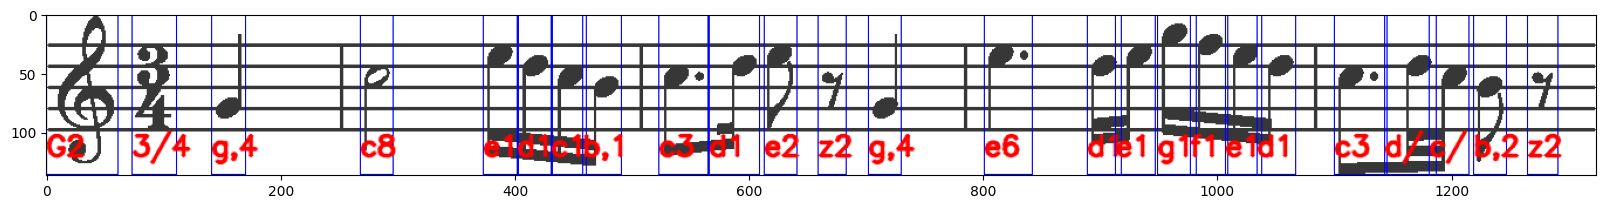

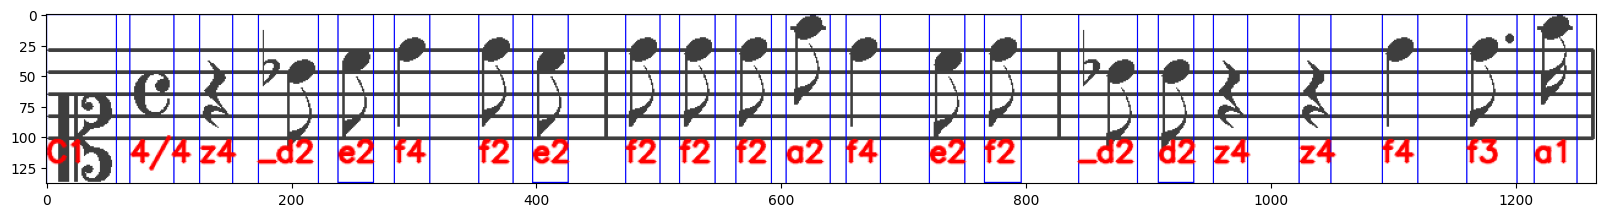

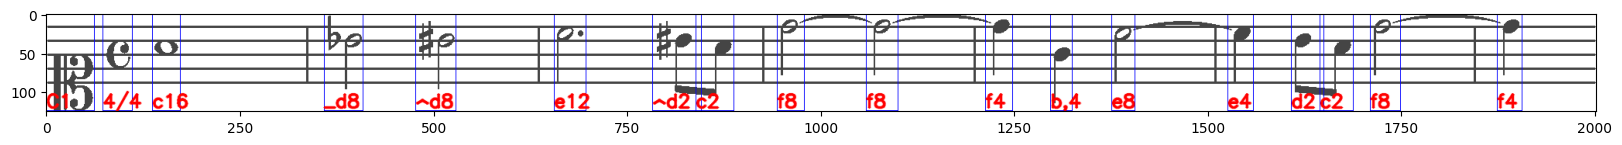

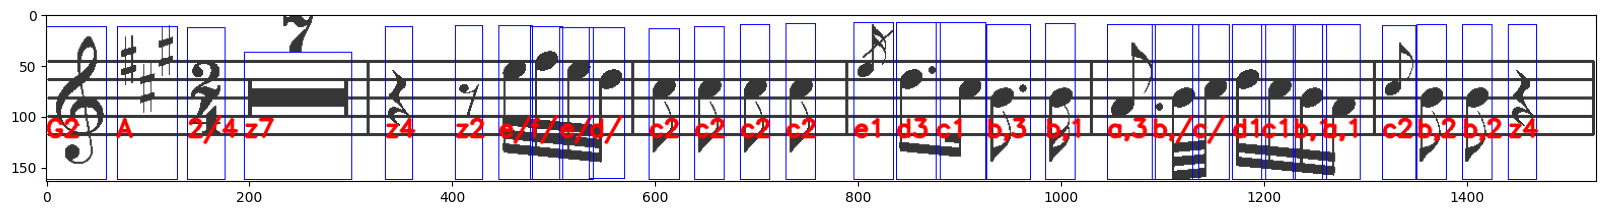

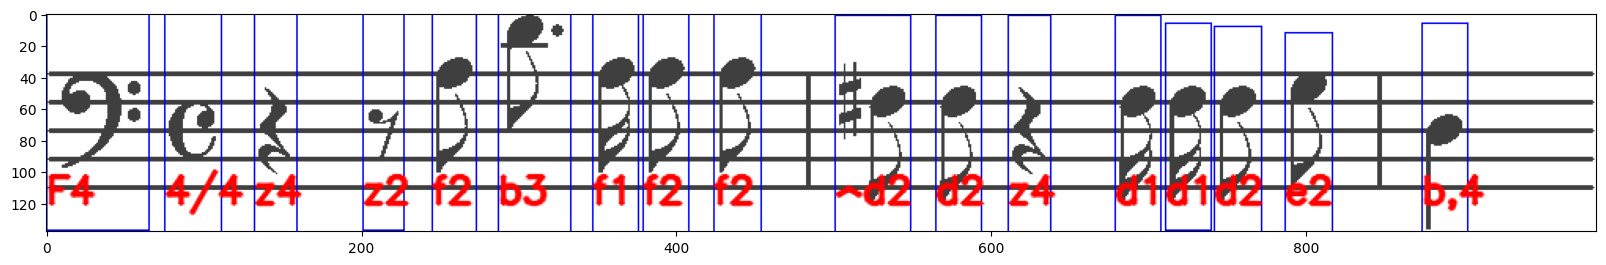

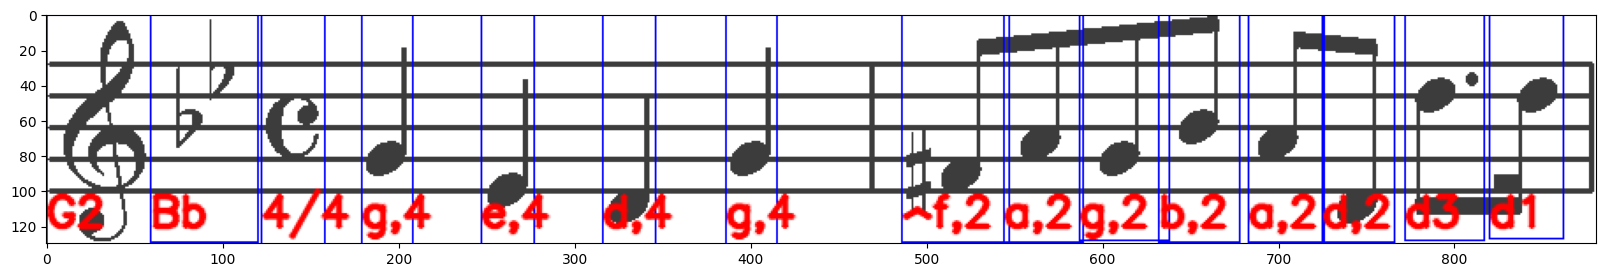

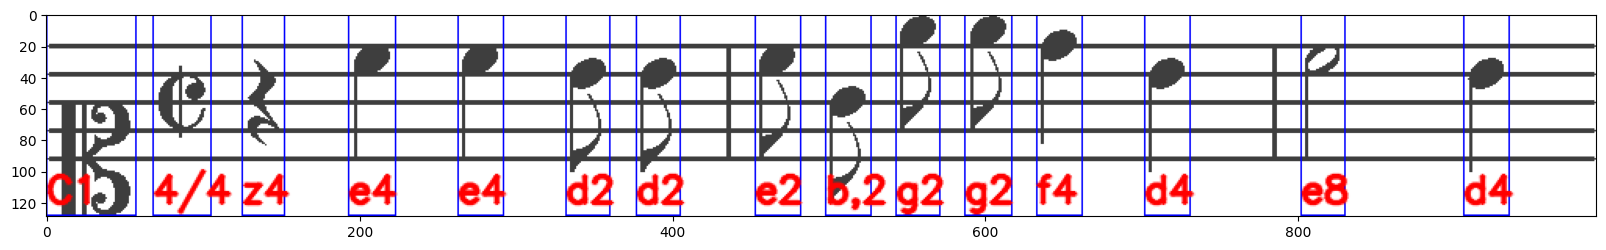

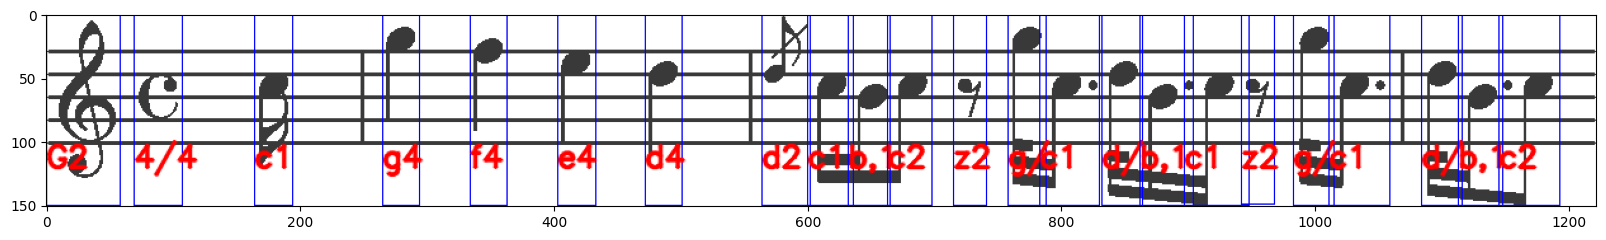

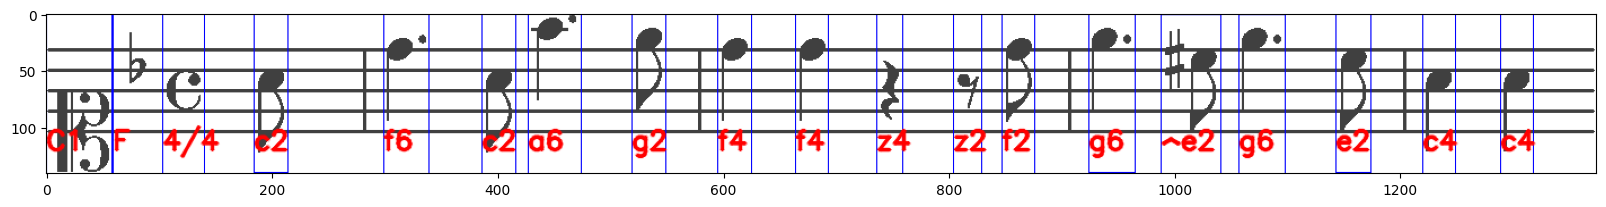

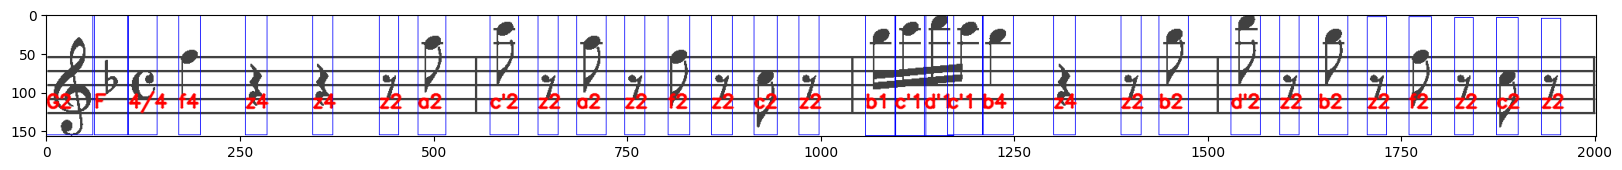

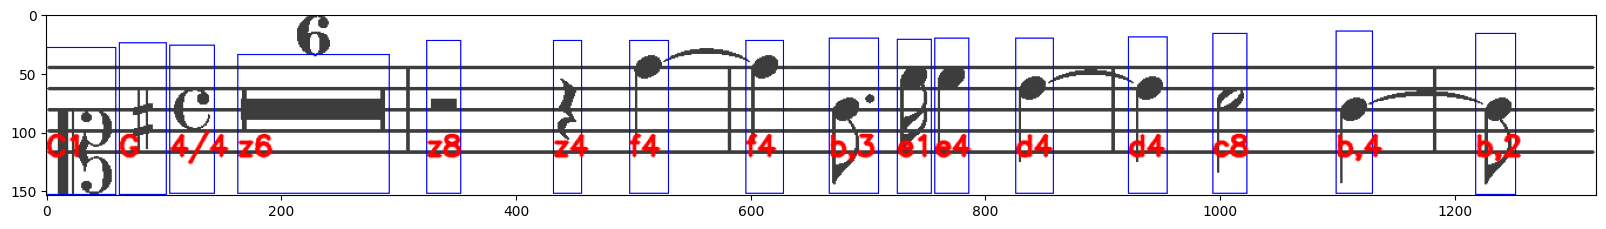

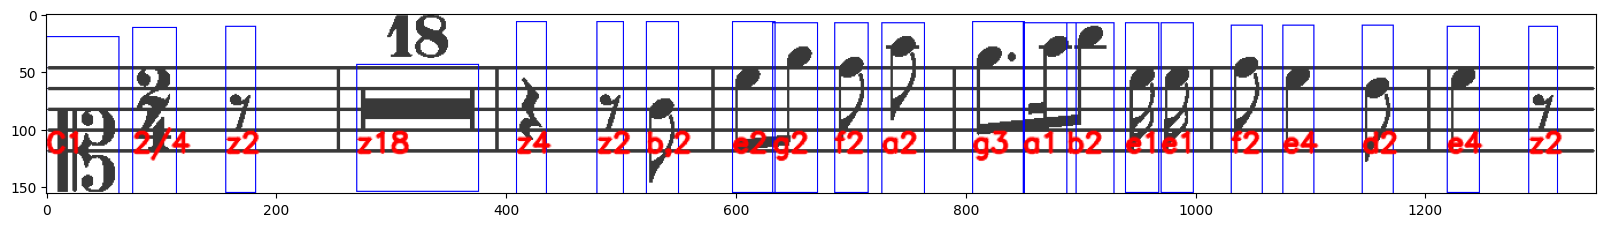

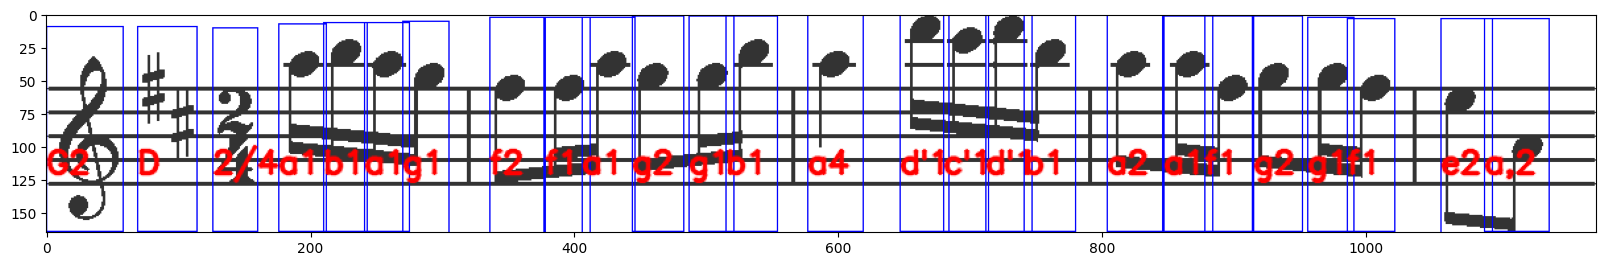

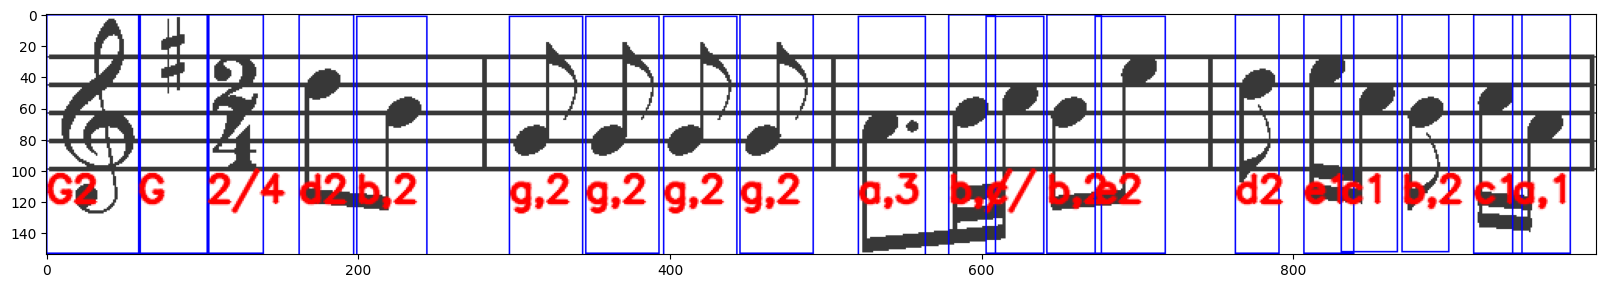

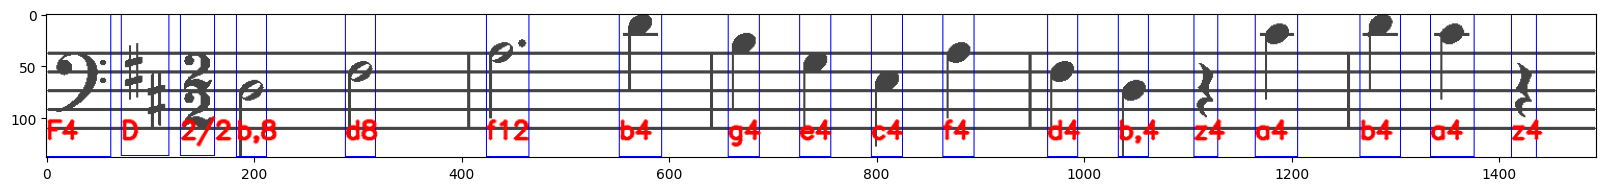

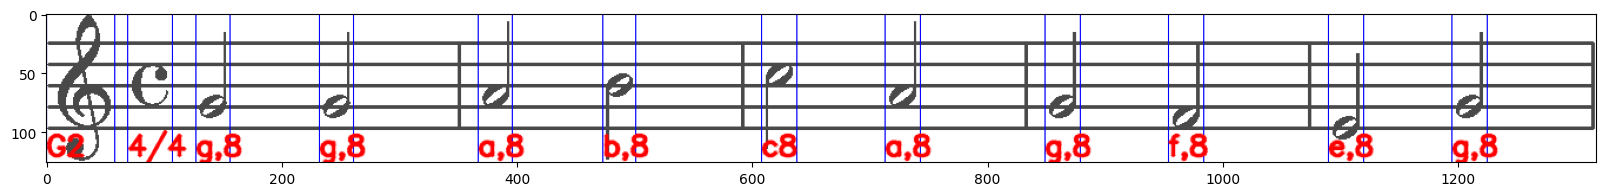

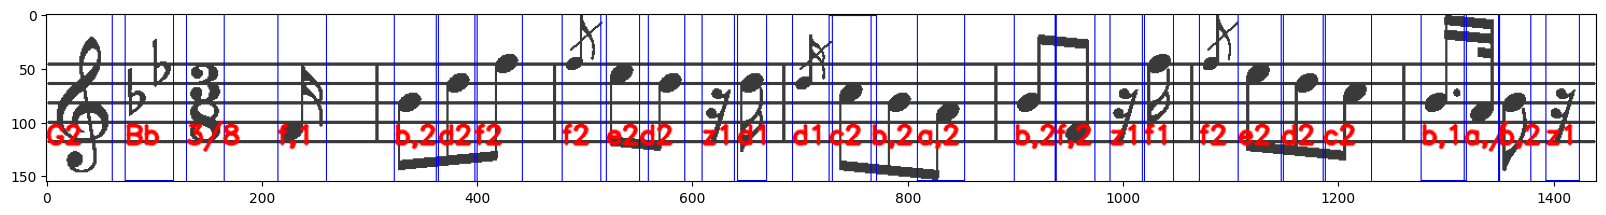

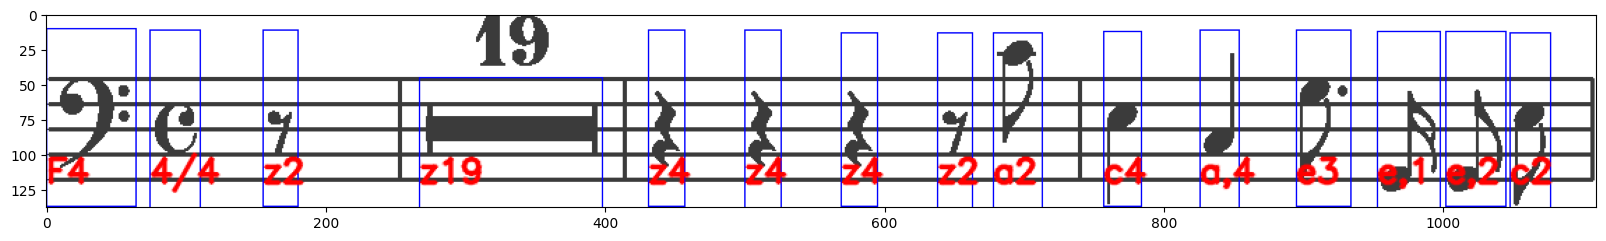

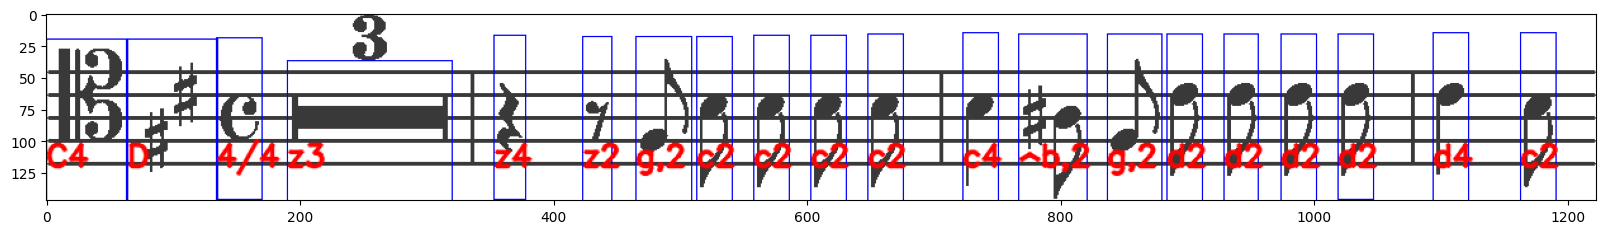

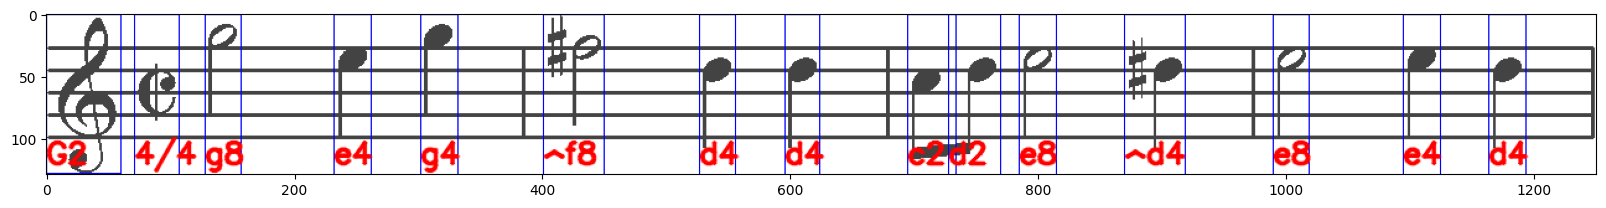

In [ ]:
def get_class_name(class_index, yaml_path='../resources/dataset/dataset.yaml'):
    with open(yaml_path, 'r') as file:
        data = yaml.safe_load(file)
        print
    return data['names'][int(class_index)]  # Return class name or index if not found


i = 40
for file in os.listdir('../resources/dataset/batch_1/match/yolo_input'):
    if file.endswith('.txt'):
        img = cv2.imread(f'../resources/dataset/batch_1/match/yolo_input/{file.replace(".txt", ".png")}')
        height_img, width_img = img.shape[0], img.shape[1]
        
        with open(f'../resources/dataset/batch_1/match/yolo_input/{file}') as f:
            yolo = f.readlines()
        for box in yolo:
            # class_label = '1'
            box = box.split(' ')
            class_label = get_class_name(box[0])
            x, y = (float(box[1])*width_img, float(box[2])*height_img)
            width, height = (float(box[3])*width_img, float(box[4])*height_img)
            start = (int((x - width/2)), int((y-height/2)))
            end = (int((x + width/2)), int((y+height/2)))
            cv2.rectangle(img, start, end, color=(255,0,0))
            
            # Put label text above the bounding box
            text_position = (max(start[0], 0), max(start[1] - 100, 120))
            cv2.putText(img, class_label, text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)

        # Convert to RGB for matplotlib
        plt.figure(figsize=(20,20))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.show()

        i+=1
        if i>=60:
            break

# Display no match

In [ ]:


for file in os.listdir('../resources/dataset/no_match/images/'):
    if file.endswith('.png'):
        img = cv2.imread(f'../resources/dataset/no_match/images/{file}')
        
        with open(f'../resources/dataset/no_match/labels/{file.replace(".png", ".mei")}') as f:
            mei = MEIConverter(content=f.read())
            print(mei.mei_to_abc())
            print(mei.notes_labels, mei.pause_labels)

        result = model(f'../resources/dataset/no_match/images/{file}')[0]
        names = [result.names[cls.item()] for cls in result.boxes.cls.int()]
        unique_names, counts = np.unique(names, return_counts=True)
        print(unique_names, counts)
        print(len(mei.notes_labels), len(mei.pause_labels))
        result.show()
        


        # Convert to RGB for matplotlib
        plt.figure(figsize=(20,20))
        plt.imshow(img)
        plt.show()

NameError: name 'associate_class_labels' is not defined